<a id="home"></a>
# IEEE Fraud Detection transactions columns reference

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.core.display import HTML
import warnings
warnings.filterwarnings("ignore")

INPUT_DIR = 'data/'
COLS_TO_SHOW = 150

def h(content):
    display(HTML(content))

def timehist1(col):
    N = 8000 if col in ['TransactionAmt'] else 9999999999999999 # clip trans amount for better view
    tr[tr['isFraud'] == 0].set_index('TransactionDT')[col].clip(0, N).plot(style='.', title='Hist ' + col, figsize=(15, 3))
    tr[tr['isFraud'] == 1].set_index('TransactionDT')[col].clip(0, N).plot(style='.', title='Hist ' + col, figsize=(15, 3))
    te.set_index('TransactionDT')[col].clip(0, N).plot(style='.', title=col + ' values over time (blue=no-fraud, orange=fraud, green=test)', figsize=(15, 3))
    plt.show()
    
def _desc(data, col, label):
    d0 = data.describe().reset_index()
    d0.columns = [col, label]
    return d0.append({col:'unique values', label:data.unique().shape[0]}, ignore_index=True) \
             .append({col:'NaNs', label:data.isnull().sum()}, ignore_index=True) \
             .append({col:'NaNs share', label:np.round(data.isnull().sum() / data.shape[0], 4)}, ignore_index=True) \
    
def desc1(col):
    d0 = _desc(tr[col], col, 'Train')
    d1 = _desc(tr.loc[tr['isFraud'] == 1, col], col, 'Train fraud')
    d2 = _desc(tr.loc[tr['isFraud'] == 0, col], col, 'Train Not fraud')
    d3 = _desc(te[col], col, 'Test')
    n_public = int(te.shape[0] * 0.2)
    d4 = _desc(te.loc[:n_public, col], col, 'Test public')
    d5 = _desc(te.loc[n_public:, col], col, 'Test private')
    dd = d0.merge(d1).merge(d2).merge(d3).merge(d4).merge(d5)
    display(dd)
    
    if col not in ['TransactionID']:
        h('<b>Most popular values (NaN = -999):</b>')
        N = 10
        d0 = tr[['isFraud',col]].fillna(-999).groupby(col)['isFraud'].agg(['size','mean','sum']).reset_index().sort_values('size', ascending=False).reset_index(drop=True)
        d1 = te[['TransactionID',col]].fillna(-999).groupby(col)['TransactionID'].count().reset_index()
        dd = d0.merge(d1, how='left', on=col).head(N)
        dd = dd.rename({'size':'Count in train (desc)','mean':'Mean target','sum':'Sum target','TransactionID':'Count in test'}, axis=1)
        display(dd)

        h('<b>Biggest fraud sum values in train (NaN = -999):</b>')
        dd = d0.sort_values('sum', ascending=False).reset_index(drop=True).head(N).merge(d1, how='left', on=col)
        dd = dd.rename({'size':'Count in train','mean':'Mean target','sum':'Sum target (desc)','TransactionID':'Count in test'}, axis=1)
        display(dd)

def hist1(col):
    plt.figure(figsize=(15, 3))
    plt.subplot(121)
    plt.hist(tr[col], bins=70);
    plt.title('Train histogram: ' + col);
    plt.subplot(122)
    plt.hist(te[col], bins=70);
    plt.title('Test histogram: ' + col);
    plt.show()

def corr1(col):
    N = None #10000
    num_vars = [f for f in tr.columns if tr[f].dtype != 'object']
    trx = tr.head(N) if N is not None else tr.copy()
    corrs = trx[num_vars].corrwith(trx[col]).reset_index().sort_values(0, ascending=False).reset_index(drop=True).rename({'index':'Column',0:'Correlation with ' + col}, axis=1)
    h('<b>Most correlated values with ' + col + ':</b>')
    trx = pd.concat([corrs.head(6), corrs.dropna().tail(5)])
    def linkx(val):
        return '<a href="#c_{}">{}</a>'.format(val, val) if val in included_cols else val
    trx['Column'] = trx['Column'].apply(linkx)
    h(trx.to_html(escape=False))
    
def numeric(col):
    timehist1(col)
    hist1(col)
    desc1(col)
    corr1(col) 
    
def categorical(col):
    desc1(col)

def proc(col):
    if col not in ['isFraud','TransactionDT']:
        h('<h3 id="c_' + col + '">' + col + '</h3>' + '<a style="font-size:11px" href="#home">(Jump to top)</a>')
        categorical(col) if tr[col].dtype == 'object' else numeric(col)
        
tr = pd.read_csv(INPUT_DIR + 'train_transaction.csv')
te = pd.read_csv(INPUT_DIR + 'test_transaction.csv')
trid = pd.read_csv(INPUT_DIR + 'train_identity.csv')
teid = pd.read_csv(INPUT_DIR + 'test_identity.csv')

included_cols = list(tr.columns.values[:COLS_TO_SHOW])
split_on = ['TransactionID','card1','addr1','C1','D1','M1','V1']
h('<b>Links to column info:</b> ' + ', '.join([('<li>' if col in split_on else '') + '<a href="#c_' + col + '">' + col + '</a>' for col in included_cols]))
h('Train transactions shape: <b>' + str(tr.shape) + '</b>, identity <b>' + str(trid.shape) + '</b>' + 
  '<br>Test transactions shape: <b>' + str(te.shape) + '</b>, identity <b>' + str(teid.shape) + '</b>')
h('Train transactions preview:')
display(tr.head(10))

TransactionID  isFraud  TransactionDT  TransactionAmt ProductCD  card1  \
0        2987000        0          86400            68.5         W  13926   
1        2987001        0          86401            29.0         W   2755   
2        2987002        0          86469            59.0         W   4663   
3        2987003        0          86499            50.0         W  18132   
4        2987004        0          86506            50.0         H   4497   
5        2987005        0          86510            49.0         W   5937   
6        2987006        0          86522           159.0         W  12308   
7        2987007        0          86529           422.5         W  12695   
8        2987008        0          86535            15.0         H   2803   
9        2987009        0          86536           117.0         W  17399   

   card2  card3       card4  card5  ... V330  V331  V332  V333  V334 V335  \
0    NaN  150.0    discover  142.0  ...  NaN   NaN   NaN   NaN   NaN  NaN   
1  404.0  150.0  mastercard  102.0  ...  NaN   NaN   NaN   NaN   NaN  NaN   
2  490.0  150.0        visa  166.0  ...  NaN   NaN   NaN   NaN   NaN  NaN   
3  567.0  150.0  mastercard  117.0  ...  NaN   NaN   NaN   NaN   NaN  NaN   
4  514.0  150.0  mastercard  102.0  ...  0.0   0.0   0.0   0.0   0.0  0.0   
5  555.0  150.0        visa  226.0  ...  NaN   NaN   NaN   NaN   NaN  NaN   
6  360.0  150.0        visa  166.0  ...  NaN   NaN   NaN   NaN   NaN  NaN   
7  490.0  150.0        visa  226.0  ...  NaN   NaN   NaN   NaN   NaN  NaN   
8  100.0  150.0        visa  226.0  ...  0.0   0.0   0.0   0.0   0.0  0.0   
9  111.0  150.0  mastercard  224.0  ...  NaN   NaN   NaN   NaN   NaN  NaN   

  V336  V337  V338  V339  
0  NaN   NaN   NaN   NaN  
1  NaN   NaN   NaN   NaN  
2  NaN   NaN   NaN   NaN  
3  NaN   NaN   NaN   NaN  
4  0.0   0.0   0.0   0.0  
5  NaN   NaN   NaN   NaN  
6  NaN   NaN   NaN   NaN  
7  NaN   NaN   NaN   NaN  
8  0.0   0.0   0.0   0.0  
9  NaN   NaN   NaN   NaN  

[10 rows x 394 columns]

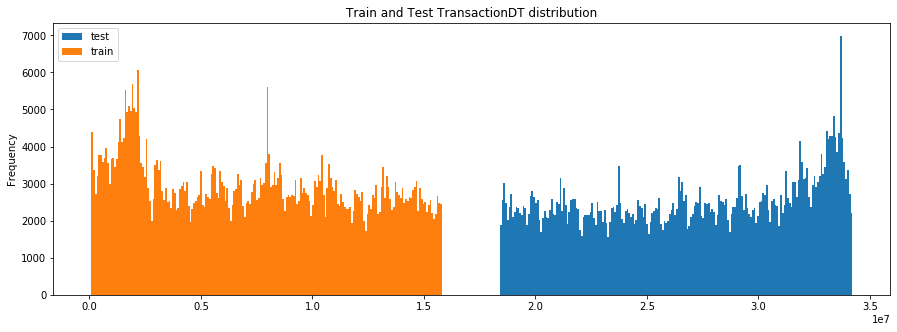

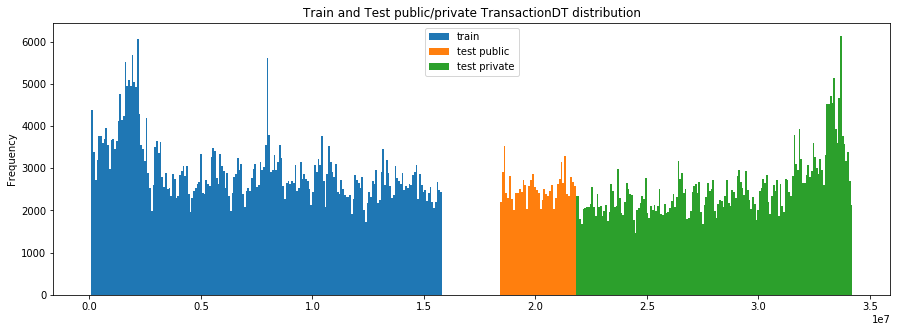

In [2]:
COL = 'TransactionDT'
h('<h2 id="c_' + COL + '">' + COL + '</h2>' + '<a style="font-size:11px" href="#home">(Jump to top)</a>')

te['TransactionDT'].plot(kind='hist', figsize=(15, 5), label='test', bins=200, title='Train and Test TransactionDT distribution')
tr['TransactionDT'].plot(kind='hist', label='train', bins=200)
plt.legend()
plt.show()
tr['TransactionDT'].plot(kind='hist', figsize=(15, 5), label='train', bins=200, title='Train and Test public/private TransactionDT distribution')
n_public = int(te.shape[0] * 0.2)
te.loc[:n_public, 'TransactionDT'].plot(kind='hist', label='test public', bins=40)
te.loc[n_public:, 'TransactionDT'].plot(kind='hist', label='test private', bins=160)
plt.legend()
plt.show()
corr1(COL)

In [3]:
COL = 'isFraud'
h('<h2 id="c_' + COL + '">' + COL + '</h2>' + '<a style="font-size:11px" href="#home">(Jump to top)</a>')
h('This is target column.')
trx = tr['isFraud'].value_counts().reset_index().rename({'index':'Value','isFraud':'Count'}, axis=1)
trx['Share'] = np.round(trx['Count'] / trx['Count'].sum(), 6)
display(trx)
corr1(COL)

Value   Count    Share
0      0  569877  0.96501
1      1   20663  0.03499

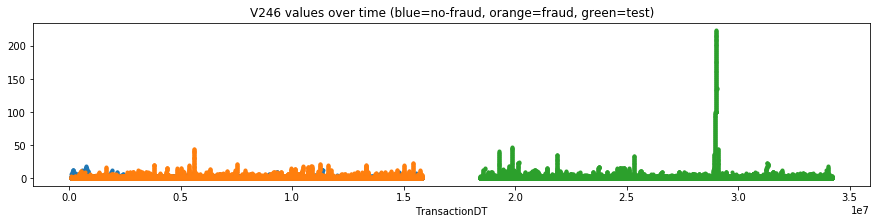

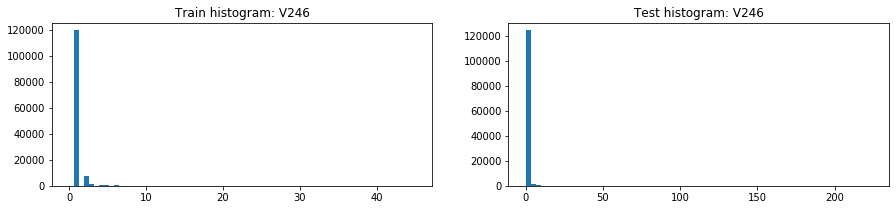

V246          Train   Train fraud  Train Not fraud  \
0           count  130430.000000  10192.000000    120238.000000   
1            mean       1.183723      2.494702         1.072598   
2             std       1.040363      3.138070         0.425933   
3             min       0.000000      0.000000         0.000000   
4             25%       1.000000      1.000000         1.000000   
5             50%       1.000000      1.000000         1.000000   
6             75%       1.000000      3.000000         1.000000   
7             max      45.000000     45.000000        18.000000   
8   unique values      47.000000     47.000000        20.000000   
9            NaNs  460110.000000  10471.000000    449639.000000   
10     NaNs share       0.779100      0.506800         0.789000   

             Test   Test public   Test private  
0   126728.000000  16421.000000  110307.000000  
1        1.414384      1.457585       1.407952  
2        5.773307      2.315700       6.123269  
3        0.000000      0.000000       1.000000  
4        1.000000      1.000000       1.000000  
5        1.000000      1.000000       1.000000  
6        1.000000      1.000000       1.000000  
7      224.000000     47.000000     224.000000  
8      226.000000     49.000000     225.000000  
9   379963.000000  84918.000000  295046.000000  
10       0.749900      0.838000       0.727900

V246  Count in train (desc)  Mean target  Sum target  Count in test
0 -999.0                 460110     0.022758       10471         379963
1    1.0                 119374     0.046392        5538         115434
2    2.0                   7258     0.263709        1914           7212
3    3.0                   1562     0.580666         907           1693
4    4.0                    691     0.777135         537            711
5    5.0                    417     0.808153         337            399
6    6.0                    299     0.849498         254            272
7    7.0                    212     0.900943         191            149
8    8.0                    123     0.804878          99            100
9    9.0                     95     0.852632          81            108

V246  Count in train  Mean target  Sum target (desc)  Count in test
0 -999.0          460110     0.022758              10471         379963
1    1.0          119374     0.046392               5538         115434
2    2.0            7258     0.263709               1914           7212
3    3.0            1562     0.580666                907           1693
4    4.0             691     0.777135                537            711
5    5.0             417     0.808153                337            399
6    6.0             299     0.849498                254            272
7    7.0             212     0.900943                191            149
8    8.0             123     0.804878                 99            100
9    9.0              95     0.852632                 81            108

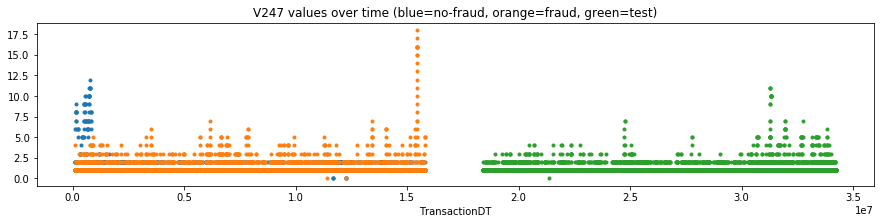

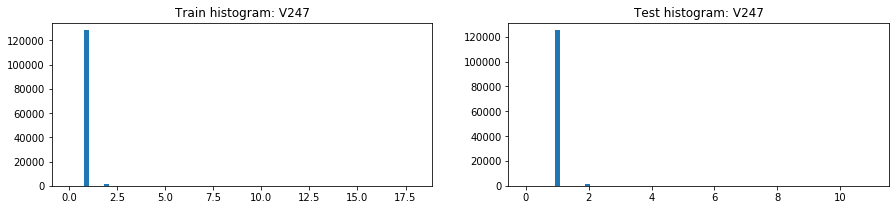

V247          Train   Train fraud  Train Not fraud          Test  \
0           count  130430.000000  10192.000000    120238.000000  126728.00000   
1            mean       1.025355      1.199176         1.010621       1.01777   
2             std       0.281604      0.740734         0.191675       0.19077   
3             min       0.000000      0.000000         0.000000       0.00000   
4             25%       1.000000      1.000000         1.000000       1.00000   
5             50%       1.000000      1.000000         1.000000       1.00000   
6             75%       1.000000      1.000000         1.000000       1.00000   
7             max      18.000000     18.000000        12.000000      11.00000   
8   unique values      20.000000     20.000000        14.000000      12.00000   
9            NaNs  460110.000000  10471.000000    449639.000000  379963.00000   
10     NaNs share       0.779100      0.506800         0.789000       0.74990   

    Test public   Test private  
0   16421.00000  110307.000000  
1       1.01900       1.017587  
2       0.15294       0.195777  
3       0.00000       1.000000  
4       1.00000       1.000000  
5       1.00000       1.000000  
6       1.00000       1.000000  
7       4.00000      11.000000  
8       6.00000      11.000000  
9   84918.00000  295046.000000  
10      0.83800       0.727900

V247  Count in train (desc)  Mean target  Sum target  Count in test
0 -999.0                 460110     0.022758       10471       379963.0
1    1.0                 128180     0.068568        8789       125002.0
2    2.0                   1860     0.595699        1108         1478.0
3    3.0                    186     0.935484         174          123.0
4    4.0                     64     0.953125          61           56.0
5    5.0                     36     0.750000          27           39.0
6    6.0                     23     0.478261          11            9.0
7    7.0                     20     0.200000           4            7.0
8    8.0                     13     0.076923           1            NaN
9    9.0                     11     0.090909           1            2.0

V247  Count in train  Mean target  Sum target (desc)  Count in test
0 -999.0          460110     0.022758              10471       379963.0
1    1.0          128180     0.068568               8789       125002.0
2    2.0            1860     0.595699               1108         1478.0
3    3.0             186     0.935484                174          123.0
4    4.0              64     0.953125                 61           56.0
5    5.0              36     0.750000                 27           39.0
6    6.0              23     0.478261                 11            9.0
7   16.0               5     1.000000                  5            NaN
8    7.0              20     0.200000                  4            7.0
9   15.0               2     1.000000                  2            NaN

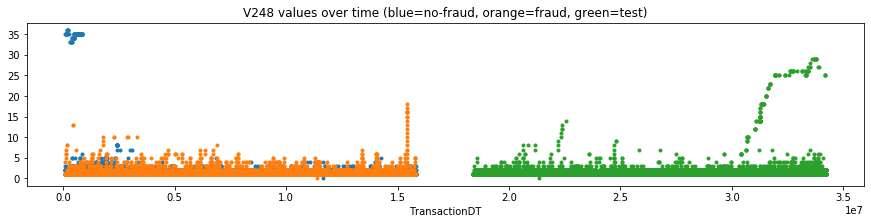

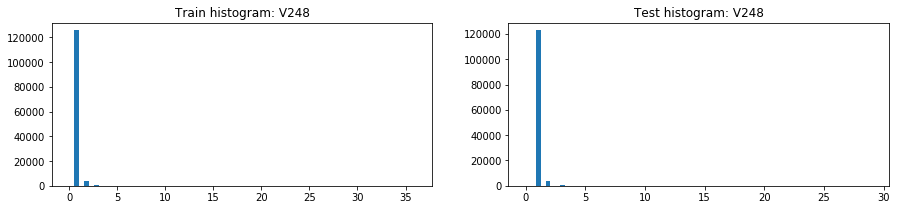

V248          Train   Train fraud  Train Not fraud  \
0           count  130430.000000  10192.000000    120238.000000   
1            mean       1.069493      1.309066         1.049186   
2             std       0.888341      0.917264         0.882866   
3             min       0.000000      0.000000         0.000000   
4             25%       1.000000      1.000000         1.000000   
5             50%       1.000000      1.000000         1.000000   
6             75%       1.000000      1.000000         1.000000   
7             max      36.000000     18.000000        36.000000   
8   unique values      24.000000     20.000000        14.000000   
9            NaNs  460110.000000  10471.000000    449639.000000   
10     NaNs share       0.779100      0.506800         0.789000   

             Test   Test public   Test private  
0   126728.000000  16421.000000  110307.000000  
1        1.058227      1.047561       1.059815  
2        0.710979      0.273233       0.754725  
3        0.000000      0.000000       1.000000  
4        1.000000      1.000000       1.000000  
5        1.000000      1.000000       1.000000  
6        1.000000      1.000000       1.000000  
7       29.000000      8.000000      29.000000  
8       28.000000     10.000000      27.000000  
9   379963.000000  84918.000000  295046.000000  
10       0.749900      0.838000       0.727900

V248  Count in train (desc)  Mean target  Sum target  Count in test
0 -999.0                 460110     0.022758       10471       379963.0
1    1.0                 125554     0.065279        8196       122660.0
2    2.0                   3956     0.372599        1474         3520.0
3    3.0                    499     0.533066         266          247.0
4    4.0                    180     0.722222         130           81.0
5    5.0                     77     0.714286          55           33.0
6   35.0                     58     0.000000           0            NaN
7    6.0                     32     0.968750          31           20.0
8    7.0                     14     0.714286          10           12.0
9    8.0                     14     0.357143           5            5.0

V248  Count in train  Mean target  Sum target (desc)  Count in test
0 -999.0          460110     0.022758              10471         379963
1    1.0          125554     0.065279               8196         122660
2    2.0            3956     0.372599               1474           3520
3    3.0             499     0.533066                266            247
4    4.0             180     0.722222                130             81
5    5.0              77     0.714286                 55             33
6    6.0              32     0.968750                 31             20
7    7.0              14     0.714286                 10             12
8   10.0               7     1.000000                  7              7
9   16.0               5     1.000000                  5              3

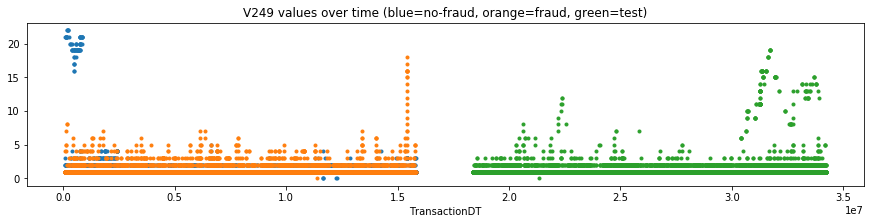

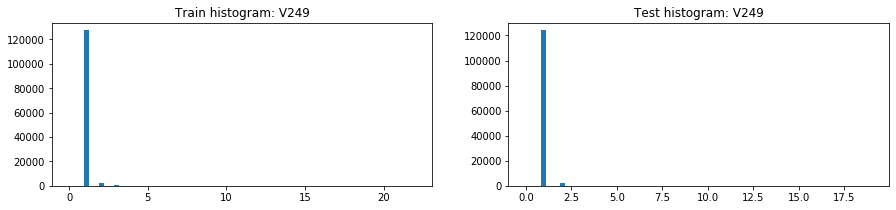

V249          Train   Train fraud  Train Not fraud  \
0           count  130430.000000  10192.000000    120238.000000   
1            mean       1.042851      1.249706         1.025316   
2             std       0.528812      0.807767         0.494074   
3             min       0.000000      0.000000         0.000000   
4             25%       1.000000      1.000000         1.000000   
5             50%       1.000000      1.000000         1.000000   
6             75%       1.000000      1.000000         1.000000   
7             max      22.000000     18.000000        22.000000   
8   unique values      24.000000     20.000000        14.000000   
9            NaNs  460110.000000  10471.000000    449639.000000   
10     NaNs share       0.779100      0.506800         0.789000   

             Test   Test public   Test private  
0   126728.000000  16421.000000  110307.000000  
1        1.036851      1.029353       1.037967  
2        0.447183      0.221809       0.471602  
3        0.000000      0.000000       1.000000  
4        1.000000      1.000000       1.000000  
5        1.000000      1.000000       1.000000  
6        1.000000      1.000000       1.000000  
7       19.000000      8.000000      19.000000  
8       20.000000     10.000000      19.000000  
9   379963.000000  84918.000000  295046.000000  
10       0.749900      0.838000       0.727900

V249  Count in train (desc)  Mean target  Sum target  Count in test
0 -999.0                 460110     0.022758       10471       379963.0
1    1.0                 127197     0.066770        8493       123994.0
2    2.0                   2631     0.489548        1288         2372.0
3    3.0                    314     0.745223         234          134.0
4    4.0                    121     0.776860          94           38.0
5    5.0                     40     0.975000          39           22.0
6   19.0                     29     0.000000           0            5.0
7   21.0                     21     0.000000           0            NaN
8    6.0                     18     1.000000          18           13.0
9   20.0                     15     0.000000           0            NaN

V249  Count in train  Mean target  Sum target (desc)  Count in test
0 -999.0          460110     0.022758              10471         379963
1    1.0          127197     0.066770               8493         123994
2    2.0            2631     0.489548               1288           2372
3    3.0             314     0.745223                234            134
4    4.0             121     0.776860                 94             38
5    5.0              40     0.975000                 39             22
6    6.0              18     1.000000                 18             13
7    7.0               7     1.000000                  7              8
8   16.0               7     0.714286                  5             16
9    8.0               3     1.000000                  3             11

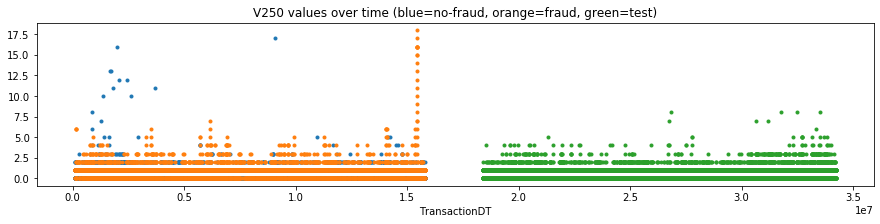

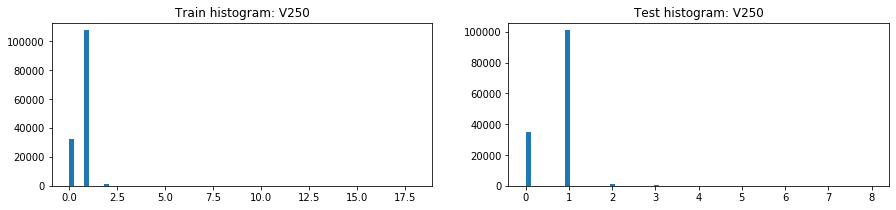

V250          Train   Train fraud  Train Not fraud  \
0           count  141416.000000  10982.000000    130434.000000   
1            mean       0.788588      0.864688         0.782181   
2             std       0.488386      0.859225         0.442629   
3             min       0.000000      0.000000         0.000000   
4             25%       1.000000      0.000000         1.000000   
5             50%       1.000000      1.000000         1.000000   
6             75%       1.000000      1.000000         1.000000   
7             max      18.000000     18.000000        17.000000   
8   unique values      20.000000     20.000000        16.000000   
9            NaNs  449124.000000   9681.000000    439443.000000   
10     NaNs share       0.760500      0.468500         0.771100   

             Test   Test public   Test private  
0   137316.000000  17734.000000  119582.000000  
1        0.758746      0.728826       0.763183  
2        0.467194      0.500545       0.461880  
3        0.000000      0.000000       0.000000  
4        0.000000      0.000000       1.000000  
5        1.000000      1.000000       1.000000  
6        1.000000      1.000000       1.000000  
7        8.000000      5.000000       8.000000  
8       10.000000      7.000000      10.000000  
9   369375.000000  83605.000000  285771.000000  
10       0.729000      0.825000       0.705000

V250  Count in train (desc)  Mean target  Sum target  Count in test
0 -999.0                 449124     0.021555        9681       369375.0
1    1.0                 107386     0.064710        6949       100920.0
2    0.0                  32341     0.093998        3040        34967.0
3    2.0                   1365     0.538462         735         1115.0
4    3.0                    196     0.806122         158          257.0
5    4.0                     65     0.861538          56           37.0
6    5.0                     20     0.700000          14           12.0
7    6.0                     12     0.916667          11            1.0
8   16.0                      6     0.833333           5            NaN
9    7.0                      4     0.750000           3            3.0

V250  Count in train  Mean target  Sum target (desc)  Count in test
0 -999.0          449124     0.021555               9681       369375.0
1    1.0          107386     0.064710               6949       100920.0
2    0.0           32341     0.093998               3040        34967.0
3    2.0            1365     0.538462                735         1115.0
4    3.0             196     0.806122                158          257.0
5    4.0              65     0.861538                 56           37.0
6    5.0              20     0.700000                 14           12.0
7    6.0              12     0.916667                 11            1.0
8   16.0               6     0.833333                  5            NaN
9    7.0               4     0.750000                  3            3.0

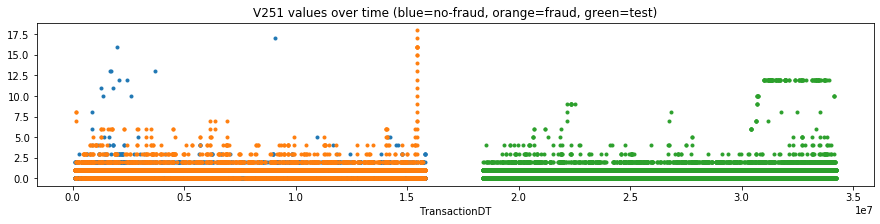

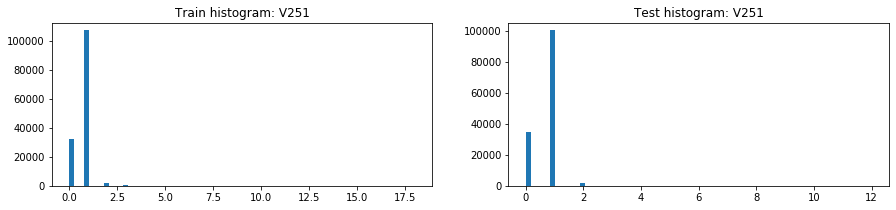

V251          Train   Train fraud  Train Not fraud  \
0           count  141416.000000  10982.000000    130434.000000   
1            mean       0.794231      0.903661         0.785018   
2             std       0.501240      0.918799         0.447471   
3             min       0.000000      0.000000         0.000000   
4             25%       1.000000      0.000000         1.000000   
5             50%       1.000000      1.000000         1.000000   
6             75%       1.000000      1.000000         1.000000   
7             max      18.000000     18.000000        17.000000   
8   unique values      20.000000     20.000000        15.000000   
9            NaNs  449124.000000   9681.000000    439443.000000   
10     NaNs share       0.760500      0.468500         0.771100   

             Test   Test public   Test private  
0   137316.000000  17734.000000  119582.000000  
1        0.774433      0.732830       0.780602  
2        0.593961      0.512415       0.604877  
3        0.000000      0.000000       0.000000  
4        0.000000      0.000000       1.000000  
5        1.000000      1.000000       1.000000  
6        1.000000      1.000000       1.000000  
7       12.000000      6.000000      12.000000  
8       13.000000      8.000000      13.000000  
9   369375.000000  83605.000000  285771.000000  
10       0.729000      0.825000       0.705000

V251  Count in train (desc)  Mean target  Sum target  Count in test
0 -999.0                 449124     0.021555        9681       369375.0
1    1.0                 106932     0.062666        6701       100270.0
2    0.0                  32264     0.093882        3029        34900.0
3    2.0                   1806     0.512182         925         1800.0
4    3.0                    240     0.775000         186          119.0
5    4.0                     88     0.840909          74           41.0
6    5.0                     25     0.760000          19           16.0
7    6.0                     25     0.960000          24           11.0
8    7.0                      6     1.000000           6            7.0
9   16.0                      6     0.833333           5            NaN

V251  Count in train  Mean target  Sum target (desc)  Count in test
0 -999.0          449124     0.021555               9681       369375.0
1    1.0          106932     0.062666               6701       100270.0
2    0.0           32264     0.093882               3029        34900.0
3    2.0            1806     0.512182                925         1800.0
4    3.0             240     0.775000                186          119.0
5    4.0              88     0.840909                 74           41.0
6    6.0              25     0.960000                 24           11.0
7    5.0              25     0.760000                 19           16.0
8    7.0               6     1.000000                  6            7.0
9   16.0               6     0.833333                  5            NaN

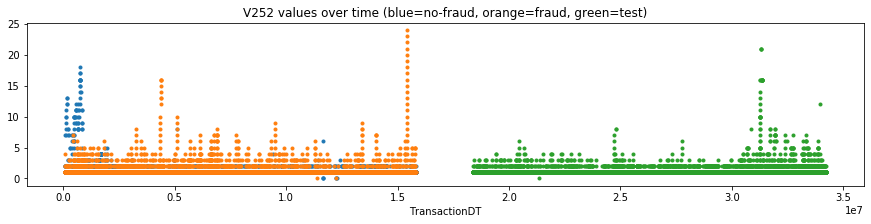

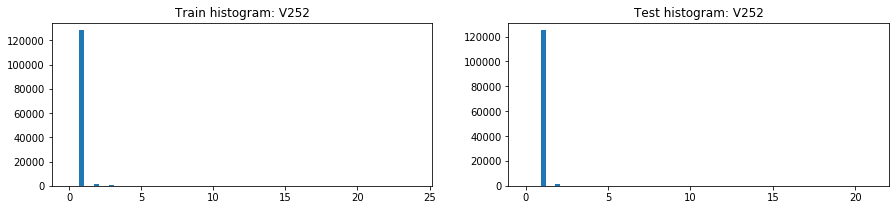

V252          Train   Train fraud  Train Not fraud  \
0           count  130430.000000  10192.000000    120238.000000   
1            mean       1.032048      1.237245         1.014654   
2             std       0.389546      1.020078         0.269335   
3             min       0.000000      0.000000         0.000000   
4             25%       1.000000      1.000000         1.000000   
5             50%       1.000000      1.000000         1.000000   
6             75%       1.000000      1.000000         1.000000   
7             max      24.000000     24.000000        18.000000   
8   unique values      26.000000     26.000000        20.000000   
9            NaNs  460110.000000  10471.000000    449639.000000   
10     NaNs share       0.779100      0.506800         0.789000   

             Test   Test public   Test private  
0   126728.000000  16421.000000  110307.000000  
1        1.021487      1.015285       1.022410  
2        0.271807      0.159392       0.284761  
3        0.000000      0.000000       1.000000  
4        1.000000      1.000000       1.000000  
5        1.000000      1.000000       1.000000  
6        1.000000      1.000000       1.000000  
7       21.000000      6.000000      21.000000  
8       18.000000      8.000000      17.000000  
9   379963.000000  84918.000000  295046.000000  
10       0.749900      0.838000       0.727900

V252  Count in train (desc)  Mean target  Sum target  Count in test
0 -999.0                 460110     0.022758       10471       379963.0
1    1.0                 128186     0.070132        8990       124943.0
2    2.0                   1613     0.445133         718         1420.0
3    3.0                    282     0.868794         245          187.0
4    4.0                    130     0.838462         109           75.0
5    5.0                     54     0.833333          45           39.0
6    6.0                     31     0.838710          26           17.0
7    7.0                     27     0.703704          19           12.0
8    8.0                     20     0.400000           8            9.0
9    9.0                     13     0.384615           5            1.0

V252  Count in train  Mean target  Sum target (desc)  Count in test
0 -999.0          460110     0.022758              10471         379963
1    1.0          128186     0.070132               8990         124943
2    2.0            1613     0.445133                718           1420
3    3.0             282     0.868794                245            187
4    4.0             130     0.838462                109             75
5    5.0              54     0.833333                 45             39
6    6.0              31     0.838710                 26             17
7    7.0              27     0.703704                 19             12
8    8.0              20     0.400000                  8              9
9    9.0              13     0.384615                  5              1

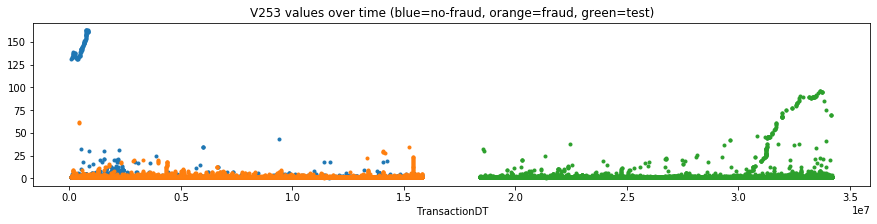

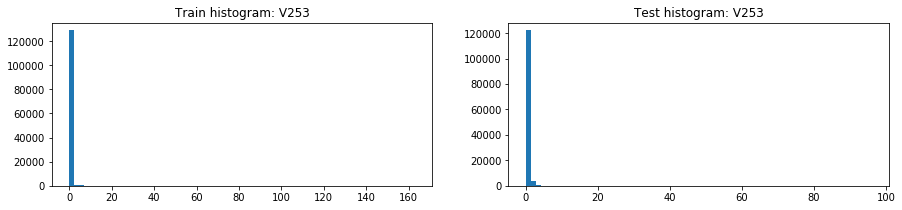

V253          Train   Train fraud  Train Not fraud  \
0           count  130430.000000  10192.000000    120238.000000   
1            mean       1.162164      1.406005         1.141494   
2             std       3.612553      1.736321         3.727705   
3             min       0.000000      0.000000         0.000000   
4             25%       1.000000      1.000000         1.000000   
5             50%       1.000000      1.000000         1.000000   
6             75%       1.000000      1.000000         1.000000   
7             max     163.000000     62.000000       163.000000   
8   unique values      67.000000     32.000000        60.000000   
9            NaNs  460110.000000  10471.000000    449639.000000   
10     NaNs share       0.779100      0.506800         0.789000   

             Test   Test public   Test private  
0   126728.000000  16421.000000  110307.000000  
1        1.117488      1.056026       1.126637  
2        2.099977      0.574131       2.239795  
3        0.000000      0.000000       1.000000  
4        1.000000      1.000000       1.000000  
5        1.000000      1.000000       1.000000  
6        1.000000      1.000000       1.000000  
7       96.000000     32.000000      96.000000  
8       73.000000     18.000000      72.000000  
9   379963.000000  84918.000000  295046.000000  
10       0.749900      0.838000       0.727900

V253  Count in train (desc)  Mean target  Sum target  Count in test
0 -999.0                 460110     0.022758       10471       379963.0
1    1.0                 125102     0.068032        8511       122066.0
2    2.0                   3748     0.240662         902         3654.0
3    3.0                    718     0.487465         350          480.0
4    4.0                    295     0.552542         163          154.0
5    5.0                    175     0.531429          93           70.0
6    6.0                     89     0.573034          51           36.0
7    7.0                     60     0.583333          35           21.0
8    8.0                     28     0.678571          19           19.0
9    9.0                     26     0.423077          11           12.0

V253  Count in train  Mean target  Sum target (desc)  Count in test
0 -999.0          460110     0.022758              10471         379963
1    1.0          125102     0.068032               8511         122066
2    2.0            3748     0.240662                902           3654
3    3.0             718     0.487465                350            480
4    4.0             295     0.552542                163            154
5    5.0             175     0.531429                 93             70
6    6.0              89     0.573034                 51             36
7    7.0              60     0.583333                 35             21
8    8.0              28     0.678571                 19             19
9    9.0              26     0.423077                 11             12

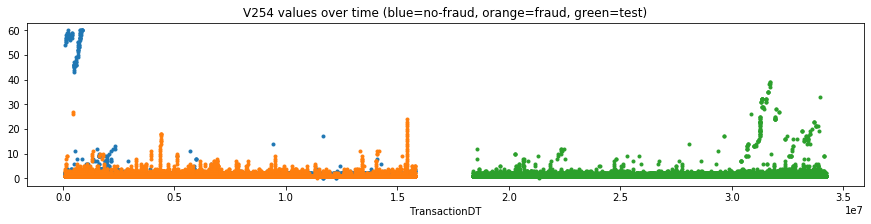

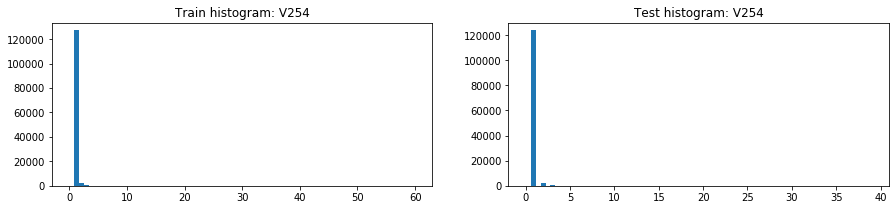

V254          Train   Train fraud  Train Not fraud  \
0           count  130430.000000  10192.000000     120238.00000   
1            mean       1.075113      1.307790          1.05539   
2             std       1.357550      1.218921          1.36684   
3             min       0.000000      0.000000          0.00000   
4             25%       1.000000      1.000000          1.00000   
5             50%       1.000000      1.000000          1.00000   
6             75%       1.000000      1.000000          1.00000   
7             max      60.000000     27.000000         60.00000   
8   unique values      46.000000     28.000000         35.00000   
9            NaNs  460110.000000  10471.000000     449639.00000   
10     NaNs share       0.779100      0.506800          0.78900   

             Test   Test public   Test private  
0   126728.000000  16421.000000  110307.000000  
1        1.052759      1.027708       1.056488  
2        0.771366      0.290783       0.819078  
3        0.000000      0.000000       1.000000  
4        1.000000      1.000000       1.000000  
5        1.000000      1.000000       1.000000  
6        1.000000      1.000000       1.000000  
7       39.000000     12.000000      39.000000  
8       38.000000     13.000000      37.000000  
9   379963.000000  84918.000000  295046.000000  
10       0.749900      0.838000       0.727900

V254  Count in train (desc)  Mean target  Sum target  Count in test
0 -999.0                 460110     0.022758       10471       379963.0
1    1.0                 126996     0.068939        8755       123750.0
2    2.0                   2448     0.326797         800         2402.0
3    3.0                    451     0.698448         315          252.0
4    4.0                    210     0.676190         142           71.0
5    5.0                     68     0.882353          60           37.0
6    6.0                     46     0.717391          33           20.0
7    7.0                     30     0.666667          20           15.0
8    9.0                     24     0.541667          13           19.0
9    8.0                     21     0.571429          12            9.0

V254  Count in train  Mean target  Sum target (desc)  Count in test
0 -999.0          460110     0.022758              10471         379963
1    1.0          126996     0.068939               8755         123750
2    2.0            2448     0.326797                800           2402
3    3.0             451     0.698448                315            252
4    4.0             210     0.676190                142             71
5    5.0              68     0.882353                 60             37
6    6.0              46     0.717391                 33             20
7    7.0              30     0.666667                 20             15
8    9.0              24     0.541667                 13             19
9    8.0              21     0.571429                 12              9

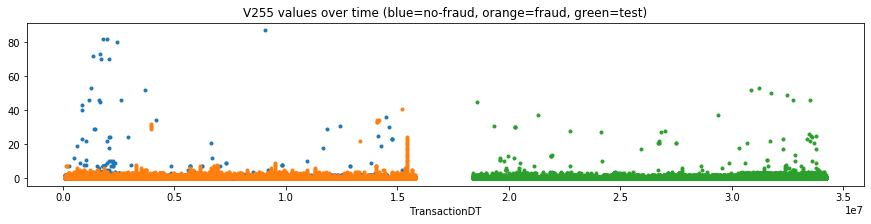

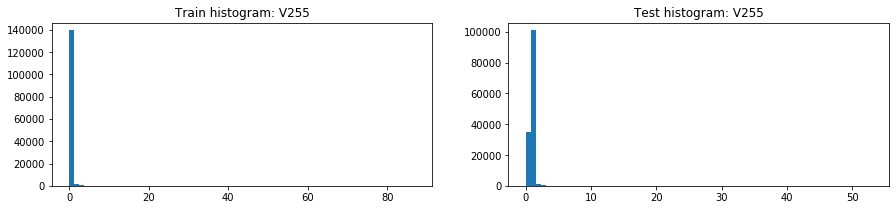

V255          Train   Train fraud  Train Not fraud  \
0           count  141416.000000  10982.000000    130434.000000   
1            mean       0.806656      0.929885         0.796280   
2             std       0.939124      1.388086         0.890288   
3             min       0.000000      0.000000         0.000000   
4             25%       1.000000      0.000000         1.000000   
5             50%       1.000000      1.000000         1.000000   
6             75%       1.000000      1.000000         1.000000   
7             max      87.000000     41.000000        87.000000   
8   unique values      47.000000     33.000000        38.000000   
9            NaNs  449124.000000   9681.000000    439443.000000   
10     NaNs share       0.760500      0.468500         0.771100   

             Test   Test public   Test private  
0   137316.000000  17734.000000  119582.000000  
1        0.768104      0.735762       0.772901  
2        0.696111      0.817731       0.676087  
3        0.000000      0.000000       0.000000  
4        0.000000      0.000000       1.000000  
5        1.000000      1.000000       1.000000  
6        1.000000      1.000000       1.000000  
7       53.000000     45.000000      53.000000  
8       35.000000     18.000000      31.000000  
9   369375.000000  83605.000000  285771.000000  
10       0.729000      0.825000       0.705000

V255  Count in train (desc)  Mean target  Sum target  Count in test
0 -999.0                 449124     0.021555        9681       369375.0
1    1.0                 107128     0.064577        6918       100948.0
2    0.0                  32341     0.093998        3040        34967.0
3    2.0                   1369     0.428780         587          955.0
4    3.0                    277     0.898917         249          311.0
5    4.0                    116     0.741379          86           39.0
6    5.0                     42     0.880952          37           21.0
7    7.0                     34     0.470588          16            6.0
8    6.0                     19     0.947368          18           10.0
9    8.0                     11     0.363636           4            1.0

V255  Count in train  Mean target  Sum target (desc)  Count in test
0 -999.0          449124     0.021555               9681         369375
1    1.0          107128     0.064577               6918         100948
2    0.0           32341     0.093998               3040          34967
3    2.0            1369     0.428780                587            955
4    3.0             277     0.898917                249            311
5    4.0             116     0.741379                 86             39
6    5.0              42     0.880952                 37             21
7    6.0              19     0.947368                 18             10
8    7.0              34     0.470588                 16              6
9    8.0              11     0.363636                  4              1

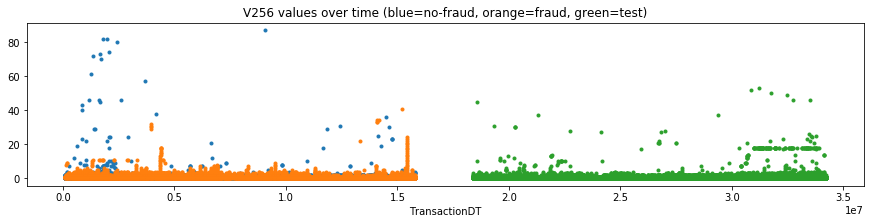

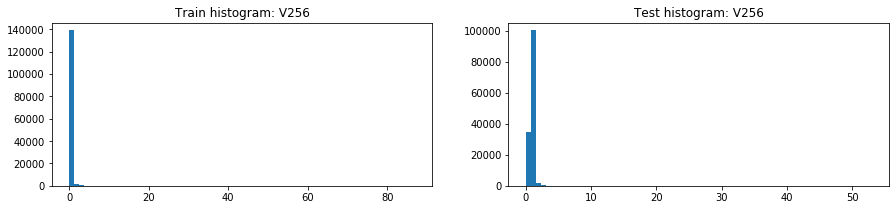

V256          Train   Train fraud  Train Not fraud  \
0           count  141416.000000  10982.000000    130434.000000   
1            mean       0.814950      0.992260         0.800021   
2             std       0.969953      1.546662         0.903193   
3             min       0.000000      0.000000         0.000000   
4             25%       1.000000      0.000000         1.000000   
5             50%       1.000000      1.000000         1.000000   
6             75%       1.000000      1.000000         1.000000   
7             max      87.000000     41.000000        87.000000   
8   unique values      49.000000     33.000000        39.000000   
9            NaNs  449124.000000   9681.000000    439443.000000   
10     NaNs share       0.760500      0.468500         0.771100   

             Test   Test public   Test private  
0   137316.000000  17734.000000  119582.000000  
1        0.791080      0.740329       0.798607  
2        0.889047      0.831390       0.897041  
3        0.000000      0.000000       0.000000  
4        0.000000      0.000000       1.000000  
5        1.000000      1.000000       1.000000  
6        1.000000      1.000000       1.000000  
7       53.000000     45.000000      53.000000  
8       35.000000     19.000000      32.000000  
9   369375.000000  83605.000000  285771.000000  
10       0.729000      0.825000       0.705000

V256  Count in train (desc)  Mean target  Sum target  Count in test
0 -999.0                 449124     0.021555        9681       369375.0
1    1.0                 106671     0.063269        6749       100192.0
2    0.0                  32264     0.093882        3029        34900.0
3    2.0                   1764     0.370181         653         1708.0
4    3.0                    317     0.854890         271          201.0
5    4.0                    158     0.797468         126           51.0
6    5.0                     52     0.923077          48           24.0
7    7.0                     34     0.470588          16           13.0
8    6.0                     31     0.806452          25           12.0
9   11.0                     16     0.937500          15            4.0

V256  Count in train  Mean target  Sum target (desc)  Count in test
0 -999.0          449124     0.021555               9681         369375
1    1.0          106671     0.063269               6749         100192
2    0.0           32264     0.093882               3029          34900
3    2.0            1764     0.370181                653           1708
4    3.0             317     0.854890                271            201
5    4.0             158     0.797468                126             51
6    5.0              52     0.923077                 48             24
7    6.0              31     0.806452                 25             12
8    7.0              34     0.470588                 16             13
9   11.0              16     0.937500                 15              4

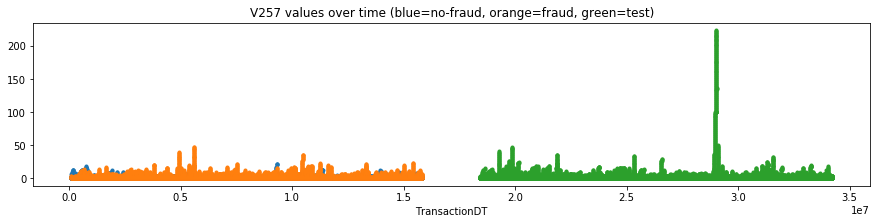

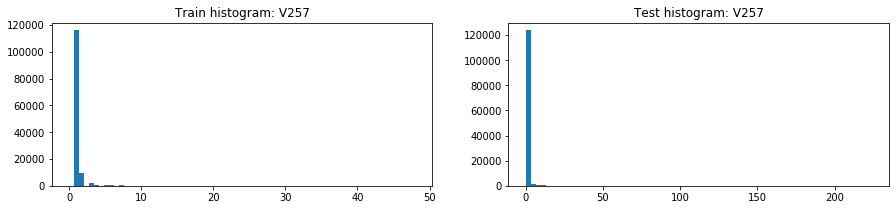

V257          Train   Train fraud  Train Not fraud  \
0           count  130430.000000  10192.000000    120238.000000   
1            mean       1.250993      2.961342         1.106015   
2             std       1.299956      3.923475         0.509331   
3             min       0.000000      0.000000         0.000000   
4             25%       1.000000      1.000000         1.000000   
5             50%       1.000000      2.000000         1.000000   
6             75%       1.000000      3.000000         1.000000   
7             max      48.000000     48.000000        22.000000   
8   unique values      50.000000     50.000000        23.000000   
9            NaNs  460110.000000  10471.000000    449639.000000   
10     NaNs share       0.779100      0.506800         0.789000   

             Test   Test public   Test private  
0   126728.000000  16421.000000  110307.000000  
1        1.484857      1.586870       1.469671  
2        5.829067      2.560324       6.169171  
3        0.000000      0.000000       1.000000  
4        1.000000      1.000000       1.000000  
5        1.000000      1.000000       1.000000  
6        1.000000      1.000000       1.000000  
7      224.000000     47.000000     224.000000  
8      226.000000     49.000000     225.000000  
9   379963.000000  84918.000000  295046.000000  
10       0.749900      0.838000       0.727900

V257  Count in train (desc)  Mean target  Sum target  Count in test
0 -999.0                 460110     0.022758       10471         379963
1    1.0                 115835     0.042768        4954         112522
2    2.0                   9578     0.200877        1924           8935
3    3.0                   2196     0.460383        1011           2129
4    4.0                    843     0.730724         616            911
5    5.0                    489     0.842536         412            475
6    6.0                    325     0.876923         285            338
7    7.0                    239     0.866109         207            215
8    8.0                    168     0.761905         128            147
9    9.0                    134     0.850746         114            123

V257  Count in train  Mean target  Sum target (desc)  Count in test
0 -999.0          460110     0.022758              10471         379963
1    1.0          115835     0.042768               4954         112522
2    2.0            9578     0.200877               1924           8935
3    3.0            2196     0.460383               1011           2129
4    4.0             843     0.730724                616            911
5    5.0             489     0.842536                412            475
6    6.0             325     0.876923                285            338
7    7.0             239     0.866109                207            215
8    8.0             168     0.761905                128            147
9    9.0             134     0.850746                114            123

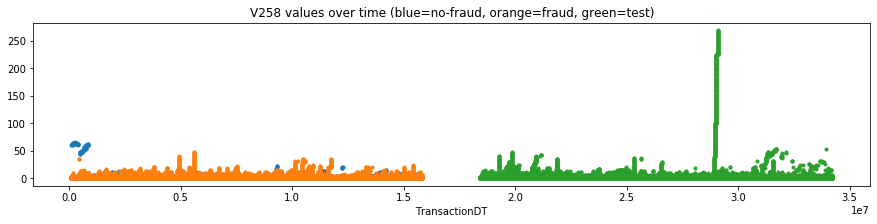

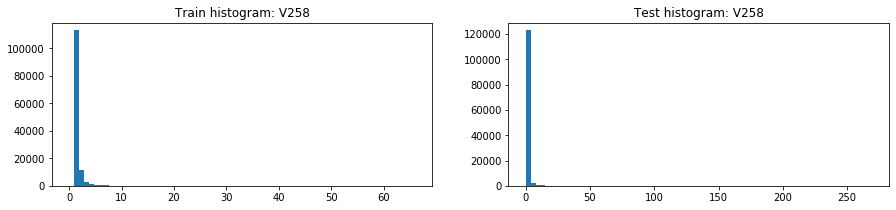

V258          Train   Train fraud  Train Not fraud  \
0           count  130430.000000  10192.000000    120238.000000   
1            mean       1.343510      3.400903         1.169115   
2             std       2.015811      4.493237         1.519058   
3             min       0.000000      0.000000         0.000000   
4             25%       1.000000      1.000000         1.000000   
5             50%       1.000000      2.000000         1.000000   
6             75%       1.000000      4.000000         1.000000   
7             max      66.000000     48.000000        66.000000   
8   unique values      68.000000     50.000000        47.000000   
9            NaNs  460110.000000  10471.000000    449639.000000   
10     NaNs share       0.779100      0.506800         0.789000   

             Test   Test public   Test private  
0   126728.000000  16421.000000  110307.000000  
1        1.667824      1.767127       1.653041  
2        7.692319      3.205198       8.151661  
3        0.000000      0.000000       1.000000  
4        1.000000      1.000000       1.000000  
5        1.000000      1.000000       1.000000  
6        1.000000      1.000000       1.000000  
7      269.000000     47.000000     269.000000  
8      271.000000     49.000000     270.000000  
9   379963.000000  84918.000000  295046.000000  
10       0.749900      0.838000       0.727900

V258  Count in train (desc)  Mean target  Sum target  Count in test
0 -999.0                 460110     0.022758       10471         379963
1    1.0                 112953     0.039698        4484         109727
2    2.0                  11247     0.168934        1900          10508
3    3.0                   2696     0.403190        1087           2555
4    4.0                   1062     0.644068         684           1081
5    5.0                    569     0.782074         445            593
6    6.0                    368     0.847826         312            402
7    7.0                    280     0.846429         237            260
8    8.0                    214     0.799065         171            188
9    9.0                    147     0.891156         131            154

V258  Count in train  Mean target  Sum target (desc)  Count in test
0 -999.0          460110     0.022758              10471         379963
1    1.0          112953     0.039698               4484         109727
2    2.0           11247     0.168934               1900          10508
3    3.0            2696     0.403190               1087           2555
4    4.0            1062     0.644068                684           1081
5    5.0             569     0.782074                445            593
6    6.0             368     0.847826                312            402
7    7.0             280     0.846429                237            260
8    8.0             214     0.799065                171            188
9    9.0             147     0.891156                131            154

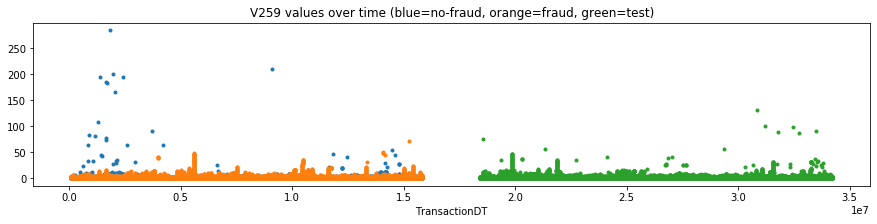

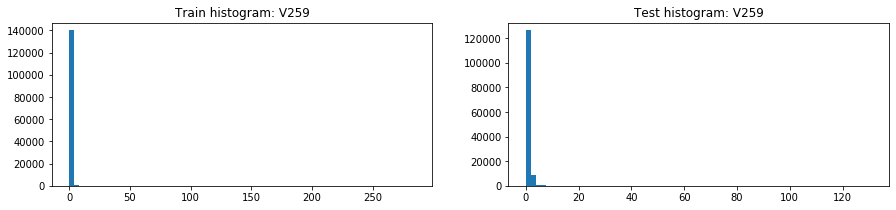

V259          Train   Train fraud  Train Not fraud  \
0           count  141416.000000  10982.000000    130434.000000   
1            mean       0.967832      2.072300         0.874841   
2             std       2.113447      3.741202         1.884947   
3             min       0.000000      0.000000         0.000000   
4             25%       1.000000      0.000000         1.000000   
5             50%       1.000000      1.000000         1.000000   
6             75%       1.000000      2.000000         1.000000   
7             max     285.000000     71.000000       285.000000   
8   unique values      69.000000     53.000000        48.000000   
9            NaNs  449124.000000   9681.000000    439443.000000   
10     NaNs share       0.760500      0.468500         0.771100   

             Test   Test public   Test private  
0   137316.000000  17734.000000  119582.000000  
1        0.931006      1.061126       0.911709  
2        1.481376      2.141260       1.355401  
3        0.000000      0.000000       0.000000  
4        0.000000      0.000000       1.000000  
5        1.000000      1.000000       1.000000  
6        1.000000      1.000000       1.000000  
7      131.000000     76.000000     131.000000  
8       58.000000     51.000000      49.000000  
9   369375.000000  83605.000000  285771.000000  
10       0.729000      0.825000       0.705000

V259  Count in train (desc)  Mean target  Sum target  Count in test
0 -999.0                 449124     0.021555        9681       369375.0
1    1.0                  97473     0.041119        4008        91389.0
2    0.0                  32341     0.093998        3040        34967.0
3    2.0                   7884     0.189371        1493         7080.0
4    3.0                   1651     0.497274         821         1912.0
5    4.0                    639     0.683881         437          583.0
6    5.0                    412     0.834951         344          420.0
7    6.0                    213     0.854460         182          196.0
8    7.0                    163     0.822086         134          131.0
9    8.0                     99     0.686869          68           84.0

V259  Count in train  Mean target  Sum target (desc)  Count in test
0 -999.0          449124     0.021555               9681         369375
1    1.0           97473     0.041119               4008          91389
2    0.0           32341     0.093998               3040          34967
3    2.0            7884     0.189371               1493           7080
4    3.0            1651     0.497274                821           1912
5    4.0             639     0.683881                437            583
6    5.0             412     0.834951                344            420
7    6.0             213     0.854460                182            196
8    7.0             163     0.822086                134            131
9    9.0              92     0.869565                 80            124

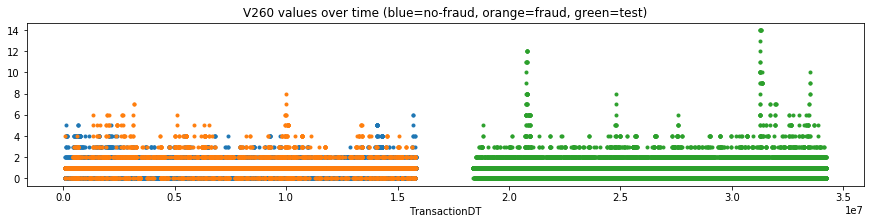

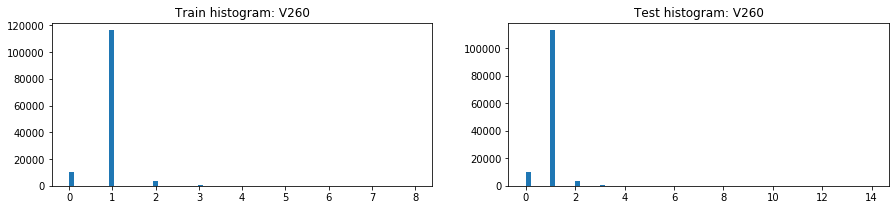

V260          Train   Train fraud  Train Not fraud  \
0           count  130430.000000  10192.000000    120238.000000   
1            mean       0.964425      1.127355         0.950615   
2             std       0.379828      0.683625         0.338300   
3             min       0.000000      0.000000         0.000000   
4             25%       1.000000      1.000000         1.000000   
5             50%       1.000000      1.000000         1.000000   
6             75%       1.000000      1.000000         1.000000   
7             max       8.000000      8.000000         6.000000   
8   unique values      10.000000     10.000000         8.000000   
9            NaNs  460110.000000  10471.000000    449639.000000   
10     NaNs share       0.779100      0.506800         0.789000   

             Test   Test public   Test private  
0   126728.000000  16421.000000  110307.000000  
1        0.965643      0.967054       0.965433  
2        0.429803      0.570978       0.404600  
3        0.000000      0.000000       0.000000  
4        1.000000      1.000000       1.000000  
5        1.000000      1.000000       1.000000  
6        1.000000      1.000000       1.000000  
7       14.000000     12.000000      14.000000  
8       16.000000     14.000000      16.000000  
9   379963.000000  84918.000000  295046.000000  
10       0.749900      0.838000       0.727900

V260  Count in train (desc)  Mean target  Sum target  Count in test
0 -999.0                 460110     0.022758       10471         379963
1    1.0                 116252     0.068833        8002         112879
2    0.0                  10040     0.078088         784           9909
3    2.0                   3254     0.300553         978           3175
4    3.0                    607     0.426689         259            443
5    4.0                    200     0.560000         112            153
6    5.0                     58     0.689655          40             53
7    6.0                     15     0.866667          13             44
8    7.0                      3     1.000000           3             17
9    8.0                      1     1.000000           1             14

V260  Count in train  Mean target  Sum target (desc)  Count in test
0 -999.0          460110     0.022758              10471         379963
1    1.0          116252     0.068833               8002         112879
2    2.0            3254     0.300553                978           3175
3    0.0           10040     0.078088                784           9909
4    3.0             607     0.426689                259            443
5    4.0             200     0.560000                112            153
6    5.0              58     0.689655                 40             53
7    6.0              15     0.866667                 13             44
8    7.0               3     1.000000                  3             17
9    8.0               1     1.000000                  1             14

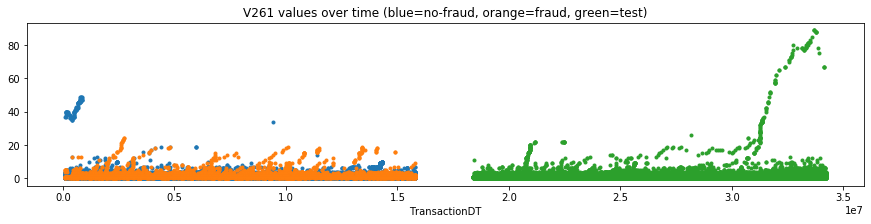

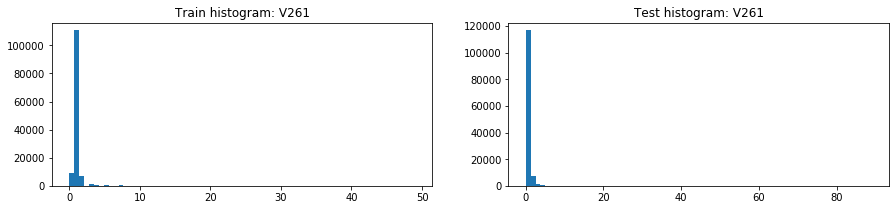

V261          Train   Train fraud  Train Not fraud  \
0           count  130430.000000  10192.000000    120238.000000   
1            mean       1.107161      1.583399         1.066793   
2             std       1.323230      1.946924         1.247890   
3             min       0.000000      0.000000         0.000000   
4             25%       1.000000      1.000000         1.000000   
5             50%       1.000000      1.000000         1.000000   
6             75%       1.000000      2.000000         1.000000   
7             max      49.000000     24.000000        49.000000   
8   unique values      42.000000     26.000000        37.000000   
9            NaNs  460110.000000  10471.000000    449639.000000   
10     NaNs share       0.779100      0.506800         0.789000   

             Test   Test public   Test private  
0   126728.000000  16421.000000  110307.000000  
1        1.115689      1.108398       1.116774  
2        1.937568      1.158064       2.028152  
3        0.000000      0.000000       0.000000  
4        1.000000      1.000000       1.000000  
5        1.000000      1.000000       1.000000  
6        1.000000      1.000000       1.000000  
7       89.000000     22.000000      89.000000  
8       68.000000     24.000000      68.000000  
9   379963.000000  84918.000000  295046.000000  
10       0.749900      0.838000       0.727900

V261  Count in train (desc)  Mean target  Sum target  Count in test
0 -999.0                 460110     0.022758       10471       379963.0
1    1.0                 110560     0.062229        6880       107365.0
2    0.0                   9388     0.074244         697         9214.0
3    2.0                   6984     0.199599        1394         7180.0
4    3.0                   1611     0.318436         513         1486.0
5    4.0                    655     0.412214         270          594.0
6    5.0                    267     0.486891         130          249.0
7    7.0                    224     0.183036          41           87.0
8    8.0                    173     0.202312          35           52.0
9    6.0                    167     0.455090          76          149.0

V261  Count in train  Mean target  Sum target (desc)  Count in test
0 -999.0          460110     0.022758              10471         379963
1    1.0          110560     0.062229               6880         107365
2    2.0            6984     0.199599               1394           7180
3    0.0            9388     0.074244                697           9214
4    3.0            1611     0.318436                513           1486
5    4.0             655     0.412214                270            594
6    5.0             267     0.486891                130            249
7    6.0             167     0.455090                 76            149
8    7.0             224     0.183036                 41             87
9    8.0             173     0.202312                 35             52

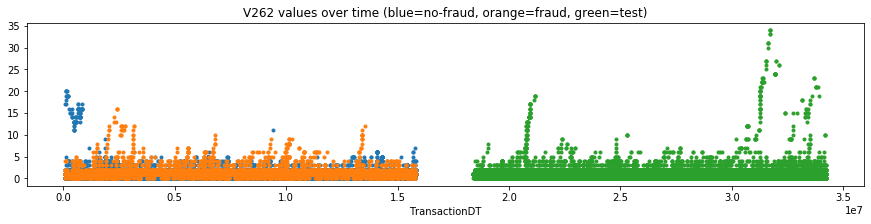

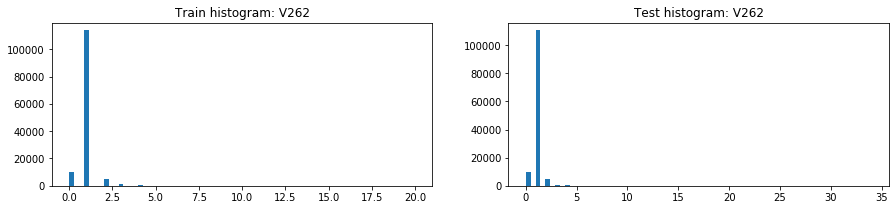

V262          Train   Train fraud  Train Not fraud  \
0           count  130430.000000  10192.000000    120238.000000   
1            mean       1.013279      1.336244         0.985903   
2             std       0.625455      1.185672         0.543699   
3             min       0.000000      0.000000         0.000000   
4             25%       1.000000      1.000000         1.000000   
5             50%       1.000000      1.000000         1.000000   
6             75%       1.000000      1.000000         1.000000   
7             max      20.000000     16.000000        20.000000   
8   unique values      22.000000     17.000000        20.000000   
9            NaNs  460110.000000  10471.000000    449639.000000   
10     NaNs share       0.779100      0.506800         0.789000   

             Test   Test public   Test private  
0   126728.000000  16421.000000  110307.000000  
1        1.020895      1.038731       1.018240  
2        0.820113      0.977872       0.793923  
3        0.000000      0.000000       0.000000  
4        1.000000      1.000000       1.000000  
5        1.000000      1.000000       1.000000  
6        1.000000      1.000000       1.000000  
7       34.000000     19.000000      34.000000  
8       33.000000     21.000000      33.000000  
9   379963.000000  84918.000000  295046.000000  
10       0.749900      0.838000       0.727900

V262  Count in train (desc)  Mean target  Sum target  Count in test
0 -999.0                 460110     0.022758       10471         379963
1    1.0                 113703     0.064387        7321         110439
2    0.0                   9751     0.075172         733           9544
3    2.0                   5085     0.257620        1310           5184
4    3.0                   1004     0.362550         364            804
5    4.0                    456     0.447368         204            315
6    5.0                    170     0.582353          99             96
7    6.0                     82     0.792683          65             68
8    7.0                     26     0.884615          23             38
9    8.0                     25     1.000000          25             12

V262  Count in train  Mean target  Sum target (desc)  Count in test
0 -999.0          460110     0.022758              10471         379963
1    1.0          113703     0.064387               7321         110439
2    2.0            5085     0.257620               1310           5184
3    0.0            9751     0.075172                733           9544
4    3.0            1004     0.362550                364            804
5    4.0             456     0.447368                204            315
6    5.0             170     0.582353                 99             96
7    6.0              82     0.792683                 65             68
8    8.0              25     1.000000                 25             12
9    7.0              26     0.884615                 23             38

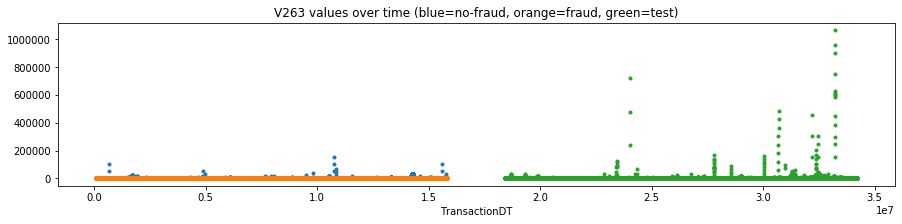

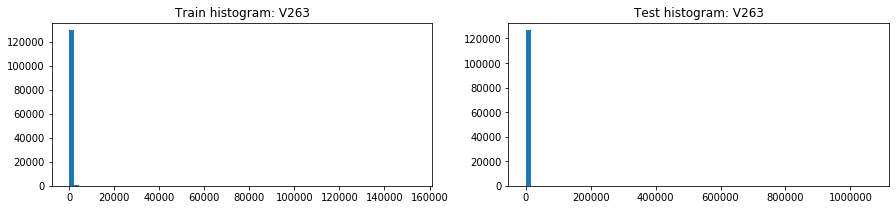

V263          Train   Train fraud  Train Not fraud          Test  \
0           count  130430.000000  10192.000000    120238.000000  1.267280e+05   
1            mean     117.390676    182.903241       111.837490  2.630722e+02   
2             std    1294.851543    381.478067      1343.887442  8.144608e+03   
3             min       0.000000      0.000000         0.000000  0.000000e+00   
4             25%       0.000000      0.000000         0.000000  0.000000e+00   
5             50%       0.000000     44.976200         0.000000  0.000000e+00   
6             75%       0.000000    200.000000         0.000000  8.607200e+00   
7             max  153600.000000   5450.000000    153600.000000  1.065496e+06   
8   unique values   10423.000000   3606.000000      8158.000000  9.588000e+03   
9            NaNs  460110.000000  10471.000000    449639.000000  3.799630e+05   
10     NaNs share       0.779100      0.506800         0.789000  7.499000e-01   

     Test public  Test private  
0   16421.000000  1.103070e+05  
1     142.909451  2.809604e+02  
2     938.770836  8.722160e+03  
3       0.000000  0.000000e+00  
4       0.000000  0.000000e+00  
5       0.000000  0.000000e+00  
6      39.593201  0.000000e+00  
7   33360.000000  1.065496e+06  
8    2601.000000  8.234000e+03  
9   84918.000000  2.950460e+05  
10      0.838000  7.279000e-01

V263  Count in train (desc)  Mean target  Sum target  Count in test
0 -999.0                 460110     0.022758       10471       379963.0
1    0.0                  98285     0.040179        3949        94140.0
2  100.0                   2175     0.068506         149         1599.0
3  200.0                   1494     0.113119         169         1316.0
4   50.0                   1412     0.063031          89          894.0
5  150.0                   1258     0.148649         187          857.0
6  300.0                   1053     0.174739         184          827.0
7  400.0                    584     0.135274          79          745.0
8   25.0                    530     0.039623          21          405.0
9   75.0                    481     0.062370          30          340.0

V263  Count in train  Mean target  Sum target (desc)  Count in test
0 -999.0          460110     0.022758              10471         379963
1    0.0           98285     0.040179               3949          94140
2  150.0            1258     0.148649                187            857
3  300.0            1053     0.174739                184            827
4  200.0            1494     0.113119                169           1316
5  100.0            2175     0.068506                149           1599
6  600.0             460     0.202174                 93            447
7   50.0            1412     0.063031                 89            894
8  400.0             584     0.135274                 79            745
9  450.0             262     0.297710                 78            164

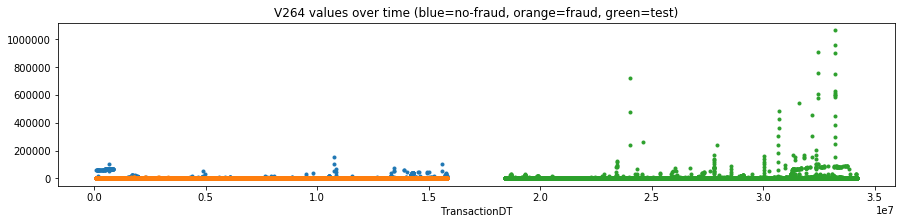

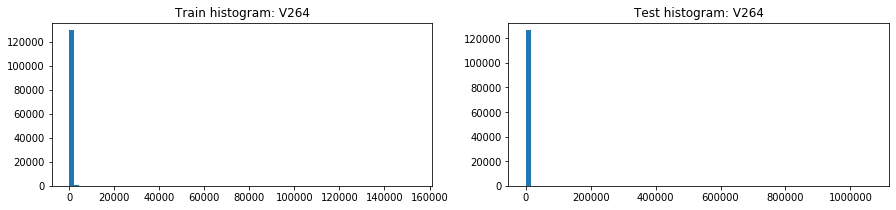

V264          Train   Train fraud  Train Not fraud          Test  \
0           count  130430.000000  10192.000000    120238.000000  1.267280e+05   
1            mean     201.657617    275.094347       195.432737  3.907419e+02   
2             std    2284.827492    553.838224      2374.122496  9.525812e+03   
3             min       0.000000      0.000000         0.000000  0.000000e+00   
4             25%       0.000000      0.000000         0.000000  0.000000e+00   
5             50%       0.000000     78.924500         0.000000  0.000000e+00   
6             75%      33.593498    300.000000        19.817801  3.500000e+01   
7             max  153600.000000  10035.000000    153600.000000  1.065496e+06   
8   unique values   13359.000000   4328.000000     10458.000000  1.270100e+04   
9            NaNs  460110.000000  10471.000000    449639.000000  3.799630e+05   
10     NaNs share       0.779100      0.506800         0.789000  7.499000e-01   

     Test public  Test private  
0   16421.000000  1.103070e+05  
1     184.352515  4.214663e+02  
2    1066.420120  1.020161e+04  
3       0.000000  0.000000e+00  
4       0.000000  0.000000e+00  
5       0.000000  0.000000e+00  
6      76.855202  2.975690e+01  
7   33360.000000  1.065496e+06  
8    3198.000000  1.095000e+04  
9   84918.000000  2.950460e+05  
10      0.838000  7.279000e-01

V264  Count in train (desc)  Mean target  Sum target  Count in test
0 -999.0                 460110     0.022758       10471       379963.0
1    0.0                  90334     0.035081        3169        86000.0
2  100.0                   2462     0.057677         142         1860.0
3   50.0                   1660     0.051205          85         1117.0
4  200.0                   1613     0.094854         153         1481.0
5  150.0                   1363     0.123991         169          958.0
6  300.0                   1141     0.157756         180          887.0
7   25.0                    698     0.028653          20          479.0
8  400.0                    648     0.138889          90          784.0
9   75.0                    575     0.046957          27          411.0

V264  Count in train  Mean target  Sum target (desc)  Count in test
0 -999.0          460110     0.022758              10471         379963
1    0.0           90334     0.035081               3169          86000
2  300.0            1141     0.157756                180            887
3  150.0            1363     0.123991                169            958
4  200.0            1613     0.094854                153           1481
5  100.0            2462     0.057677                142           1860
6  600.0             507     0.183432                 93            472
7  400.0             648     0.138889                 90            784
8   50.0            1660     0.051205                 85           1117
9  450.0             285     0.263158                 75            175

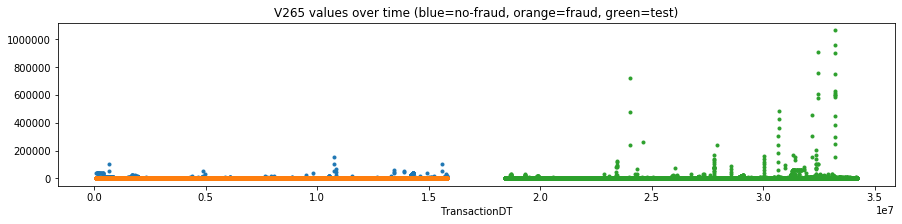

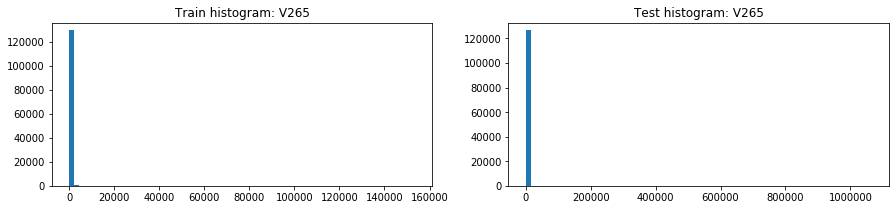

V265          Train   Train fraud  Train Not fraud          Test  \
0           count  130430.000000  10192.000000    120238.000000  1.267280e+05   
1            mean     153.520534    231.958628       146.871712  3.278710e+02   
2             std    1605.512276    459.758418      1666.639314  9.182103e+03   
3             min       0.000000      0.000000         0.000000  0.000000e+00   
4             25%       0.000000      0.000000         0.000000  0.000000e+00   
5             50%       0.000000     62.353401         0.000000  0.000000e+00   
6             75%      20.897525    256.954865         0.000000  2.213280e+01   
7             max  153600.000000   5475.000000    153600.000000  1.065496e+06   
8   unique values   11758.000000   4029.000000      9100.000000  1.109200e+04   
9            NaNs  460110.000000  10471.000000    449639.000000  3.799630e+05   
10     NaNs share       0.779100      0.506800         0.789000  7.499000e-01   

     Test public  Test private  
0   16421.000000  1.103070e+05  
1     164.947629  3.521248e+02  
2     986.478635  9.834267e+03  
3       0.000000  0.000000e+00  
4       0.000000  0.000000e+00  
5       0.000000  0.000000e+00  
6      51.889099  1.801360e+01  
7   33360.000000  1.065496e+06  
8    2888.000000  9.532000e+03  
9   84918.000000  2.950460e+05  
10      0.838000  7.279000e-01

V265  Count in train (desc)  Mean target  Sum target  Count in test
0 -999.0                 460110     0.022758       10471       379963.0
1    0.0                  94337     0.036529        3446        89956.0
2  100.0                   2335     0.061242         143         1739.0
3   50.0                   1572     0.057252          90         1042.0
4  200.0                   1551     0.102515         159         1387.0
5  150.0                   1316     0.135258         178          898.0
6  300.0                   1108     0.175090         194          857.0
7  400.0                    621     0.146538          91          756.0
8   25.0                    619     0.033926          21          479.0
9   75.0                    538     0.068773          37          391.0

V265  Count in train  Mean target  Sum target (desc)  Count in test
0 -999.0          460110     0.022758              10471         379963
1    0.0           94337     0.036529               3446          89956
2  300.0            1108     0.175090                194            857
3  150.0            1316     0.135258                178            898
4  200.0            1551     0.102515                159           1387
5  100.0            2335     0.061242                143           1739
6  600.0             490     0.193878                 95            462
7  400.0             621     0.146538                 91            756
8   50.0            1572     0.057252                 90           1042
9  450.0             273     0.285714                 78            168

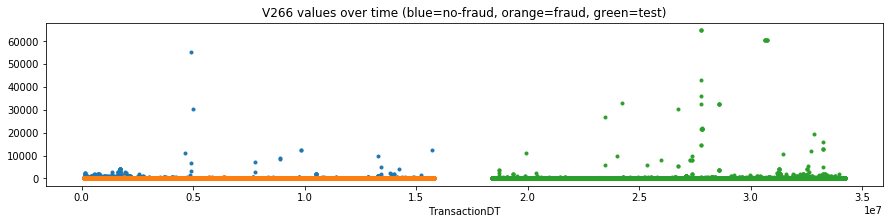

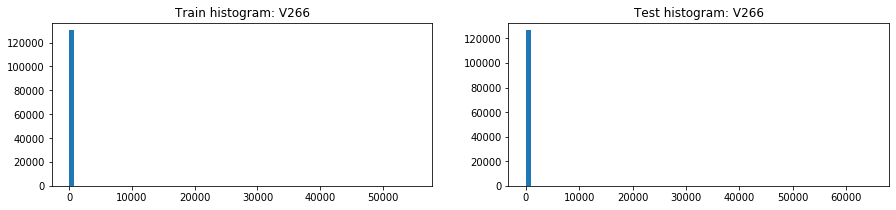

V266          Train   Train fraud  Train Not fraud  \
0           count  130430.000000  10192.000000    120238.000000   
1            mean       9.167839      5.411525         9.486243   
2             std     208.038863     28.666797       216.513053   
3             min       0.000000      0.000000         0.000000   
4             25%       0.000000      0.000000         0.000000   
5             50%       0.000000      0.000000         0.000000   
6             75%       0.000000      0.000000         0.000000   
7             max   55125.000000    635.000000     55125.000000   
8   unique values    2179.000000    225.000000      2093.000000   
9            NaNs  460110.000000  10471.000000    449639.000000   
10     NaNs share       0.779100      0.506800         0.789000   

             Test   Test public   Test private  
0   126728.000000  16421.000000  110307.000000  
1       18.501697      6.464701      20.293600  
2      665.240151    107.040350     711.824897  
3        0.000000      0.000000       0.000000  
4        0.000000      0.000000       0.000000  
5        0.000000      0.000000       0.000000  
6        0.000000      0.000000       0.000000  
7    64800.000000  11000.000000   64800.000000  
8     1916.000000    435.000000    1737.000000  
9   379963.000000  84918.000000  295046.000000  
10       0.749900      0.838000       0.727900

V266  Count in train (desc)  Mean target  Sum target  Count in test
0 -999.0                 460110     0.022758       10471       379963.0
1    0.0                 120515     0.077492        9339       117163.0
2   50.0                    391     0.074169          29          257.0
3  100.0                    343     0.061224          21          304.0
4   25.0                    202     0.064356          13          193.0
5  150.0                    173     0.127168          22          132.0
6  106.0                    165     0.000000           0            NaN
7  181.0                    146     0.000000           0            NaN
8   20.0                    123     0.016260           2          133.0
9  200.0                    111     0.126126          14          195.0

V266  Count in train  Mean target  Sum target (desc)  Count in test
0 -999.000000          460110     0.022758              10471       379963.0
1    0.000000          120515     0.077492               9339       117163.0
2   50.000000             391     0.074169                 29          257.0
3   20.844900              28     0.928571                 26            NaN
4   17.337400              29     0.862069                 25           12.0
5  150.000000             173     0.127168                 22          132.0
6  100.000000             343     0.061224                 21          304.0
7   44.106602              23     0.826087                 19            NaN
8   86.317902              18     1.000000                 18            NaN
9    8.914600              20     0.900000                 18           19.0

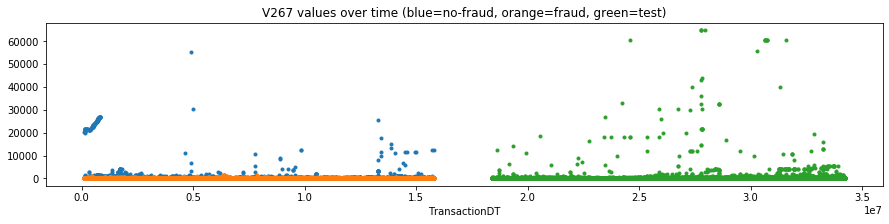

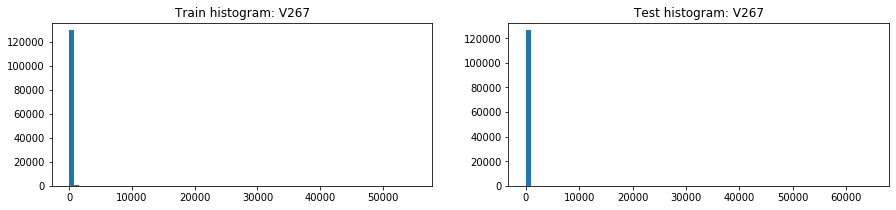

V267          Train   Train fraud  Train Not fraud  \
0           count  130430.000000  10192.000000    120238.000000   
1            mean      36.525103     20.156896        37.912557   
2             std     644.878586     80.393649       671.228294   
3             min       0.000000      0.000000         0.000000   
4             25%       0.000000      0.000000         0.000000   
5             50%       0.000000      0.000000         0.000000   
6             75%       0.000000      0.000000         0.000000   
7             max   55125.000000   1495.000000     55125.000000   
8   unique values    3617.000000    397.000000      3475.000000   
9            NaNs  460110.000000  10471.000000    449639.000000   
10     NaNs share       0.779100      0.506800         0.789000   

             Test   Test public   Test private  
0   126728.000000  16421.000000  110307.000000  
1       37.740975     18.802159      40.560327  
2      828.662878    246.709039     883.054517  
3        0.000000      0.000000       0.000000  
4        0.000000      0.000000       0.000000  
5        0.000000      0.000000       0.000000  
6        0.000000      0.000000       0.000000  
7    64800.000000  18400.000000   64800.000000  
8     3366.000000    762.000000    3066.000000  
9   379963.000000  84918.000000  295046.000000  
10       0.749900      0.838000       0.727900

V267  Count in train (desc)  Mean target  Sum target  Count in test
0  -999.0                 460110     0.022758       10471       379963.0
1     0.0                 112053     0.073073        8188       108515.0
2   100.0                    761     0.051248          39          642.0
3    50.0                    740     0.047297          35          570.0
4    25.0                    397     0.047859          19          325.0
5   150.0                    341     0.126100          43          293.0
6  1259.0                    328     0.000000           0            NaN
7   200.0                    299     0.107023          32          370.0
8    20.0                    266     0.026316           7          245.0
9    75.0                    259     0.131274          34          194.0

V267  Count in train  Mean target  Sum target (desc)  Count in test
0 -999.000000          460110     0.022758              10471       379963.0
1    0.000000          112053     0.073073               8188       108515.0
2   39.575100              50     1.000000                 50            NaN
3  150.000000             341     0.126100                 43          293.0
4  450.000000              70     0.614286                 43           49.0
5  100.000000             761     0.051248                 39          642.0
6   86.317902              43     0.883721                 38            1.0
7   50.000000             740     0.047297                 35          570.0
8   75.000000             259     0.131274                 34          194.0
9  300.000000             181     0.182320                 33          188.0

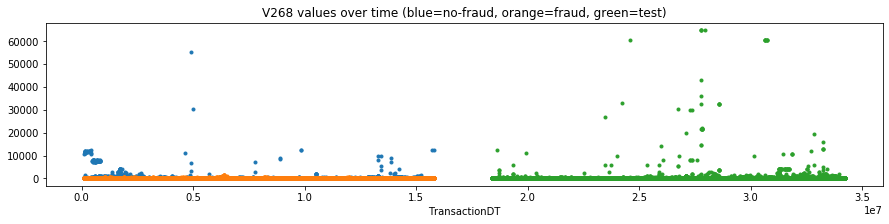

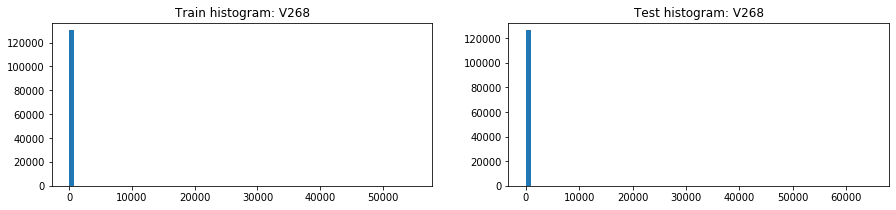

V268          Train   Train fraud  Train Not fraud  \
0           count  130430.000000  10192.000000    120238.000000   
1            mean      18.813407     13.295416        19.281140   
2             std     311.280181     63.343620       323.675597   
3             min       0.000000      0.000000         0.000000   
4             25%       0.000000      0.000000         0.000000   
5             50%       0.000000      0.000000         0.000000   
6             75%       0.000000      0.000000         0.000000   
7             max   55125.000000   1495.000000     55125.000000   
8   unique values    2757.000000    313.000000      2643.000000   
9            NaNs  460110.000000  10471.000000    449639.000000   
10     NaNs share       0.779100      0.506800         0.789000   

             Test   Test public   Test private  
0   126728.000000  16421.000000  110307.000000  
1       25.521301     10.379182      27.775453  
2      731.803178    153.627926     782.117240  
3        0.000000      0.000000       0.000000  
4        0.000000      0.000000       0.000000  
5        0.000000      0.000000       0.000000  
6        0.000000      0.000000       0.000000  
7    64800.000000  12500.000000   64800.000000  
8     2460.000000    575.000000    2240.000000  
9   379963.000000  84918.000000  295046.000000  
10       0.749900      0.838000       0.727900

V268  Count in train (desc)  Mean target  Sum target  Count in test
0 -999.0                 460110     0.022758       10471       379963.0
1    0.0                 116323     0.074448        8660       112754.0
2   50.0                    587     0.071550          42          442.0
3  100.0                    549     0.058288          32          470.0
4   25.0                    339     0.076696          26          286.0
5  619.0                    328     0.000000           0            NaN
6  150.0                    265     0.132075          35          209.0
7   30.0                    230     0.047826          11          160.0
8   20.0                    218     0.022936           5          218.0
9   15.0                    206     0.038835           8          148.0

V268  Count in train  Mean target  Sum target (desc)  Count in test
0 -999.000000          460110     0.022758              10471       379963.0
1    0.000000          116323     0.074448               8660       112754.0
2   50.000000             587     0.071550                 42          442.0
3   86.317902              38     1.000000                 38            1.0
4  150.000000             265     0.132075                 35          209.0
5  100.000000             549     0.058288                 32          470.0
6  300.000000             136     0.227941                 31          128.0
7   25.452700              34     0.911765                 31            6.0
8   20.844900              33     0.909091                 30            NaN
9   39.575100              27     1.000000                 27            NaN

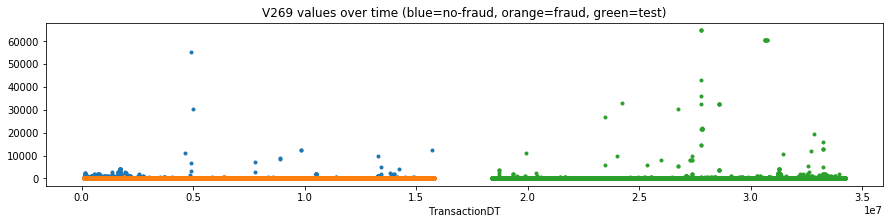

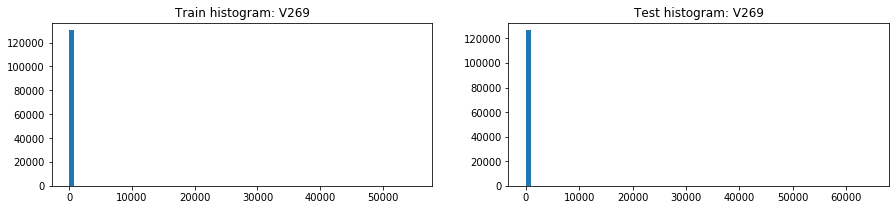

V269          Train   Train fraud  Train Not fraud  \
0           count  130430.000000  10192.000000    120238.000000   
1            mean       5.997508      1.793073         6.353898   
2             std     207.317539     22.423101       215.823094   
3             min       0.000000      0.000000         0.000000   
4             25%       0.000000      0.000000         0.000000   
5             50%       0.000000      0.000000         0.000000   
6             75%       0.000000      0.000000         0.000000   
7             max   55125.000000    635.000000     55125.000000   
8   unique values     152.000000     40.000000       138.000000   
9            NaNs  460110.000000  10471.000000    449639.000000   
10     NaNs share       0.779100      0.506800         0.789000   

             Test   Test public   Test private  
0   126728.000000  16421.000000  110307.000000  
1       14.804019      3.423756      16.498157  
2      664.266326    105.317735     710.819472  
3        0.000000      0.000000       0.000000  
4        0.000000      0.000000       0.000000  
5        0.000000      0.000000       0.000000  
6        0.000000      0.000000       0.000000  
7    64800.000000  11000.000000   64800.000000  
8      155.000000     42.000000     152.000000  
9   379963.000000  84918.000000  295046.000000  
10       0.749900      0.838000       0.727900

V269  Count in train (desc)  Mean target  Sum target  Count in test
0  -999.0                 460110     0.022758       10471       379963.0
1     0.0                 128257     0.078538       10073       124854.0
2   100.0                    212     0.042453           9          209.0
3   106.0                    165     0.000000           0            NaN
4   181.0                    146     0.000000           0            NaN
5    50.0                    138     0.057971           8          134.0
6   150.0                    110     0.063636           7           76.0
7    25.0                     90     0.033333           3          112.0
8    20.0                     90     0.022222           2          124.0
9  1000.0                     88     0.000000           0           47.0

V269  Count in train  Mean target  Sum target (desc)  Count in test
0 -999.0          460110     0.022758              10471       379963.0
1    0.0          128257     0.078538              10073       124854.0
2   15.0              72     0.138889                 10           53.0
3  100.0             212     0.042453                  9          209.0
4   50.0             138     0.057971                  8          134.0
5  150.0             110     0.063636                  7           76.0
6  200.0              80     0.075000                  6          145.0
7   34.0               6     1.000000                  6            NaN
8  250.0              66     0.090909                  6           74.0
9  125.0              46     0.130435                  6           21.0

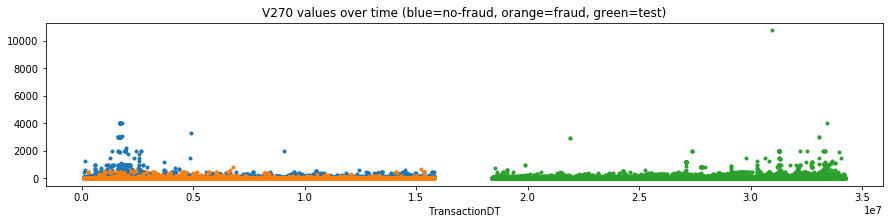

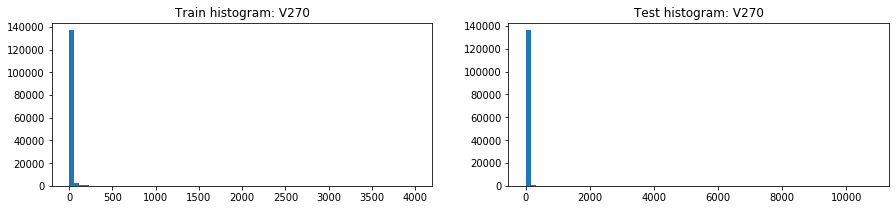

V270          Train   Train fraud  Train Not fraud  \
0           count  141416.000000  10982.000000    130434.000000   
1            mean       7.712764     11.253346         7.414661   
2             std      65.507232     48.069232        66.759462   
3             min       0.000000      0.000000         0.000000   
4             25%       0.000000      0.000000         0.000000   
5             50%       0.000000      0.000000         0.000000   
6             75%       0.000000      0.000000         0.000000   
7             max    4000.000000    800.000000      4000.000000   
8   unique values    2341.000000    238.000000      2263.000000   
9            NaNs  449124.000000   9681.000000    439443.000000   
10     NaNs share       0.760500      0.468500         0.771100   

             Test   Test public   Test private  
0   137316.000000  17734.000000  119582.000000  
1        7.208853      5.234527       7.501645  
2       62.642960     28.918147      66.192296  
3        0.000000      0.000000       0.000000  
4        0.000000      0.000000       0.000000  
5        0.000000      0.000000       0.000000  
6        0.000000      0.000000       0.000000  
7    10791.570312   1000.000000   10791.570312  
8     1982.000000    452.000000    1799.000000  
9   369375.000000  83605.000000  285771.000000  
10       0.729000      0.825000       0.705000

V270  Count in train (desc)  Mean target  Sum target  Count in test
0 -999.0                 449124     0.021555        9681       369375.0
1    0.0                 128634     0.073192        9415       124829.0
2   50.0                    674     0.078635          53          536.0
3  100.0                    660     0.059091          39          510.0
4   25.0                    351     0.039886          14          345.0
5  150.0                    272     0.169118          46          213.0
6   20.0                    245     0.085714          21          216.0
7   15.0                    243     0.222222          54          137.0
8  200.0                    223     0.130045          29          213.0
9   30.0                    205     0.014634           3          183.0

V270  Count in train  Mean target  Sum target (desc)  Count in test
0 -999.000000          449124     0.021555               9681         369375
1    0.000000          128634     0.073192               9415         124829
2   15.000000             243     0.222222                 54            137
3   50.000000             674     0.078635                 53            536
4   19.550600              48     0.979167                 47             15
5  150.000000             272     0.169118                 46            213
6  450.000000              63     0.698413                 44             26
7  100.000000             660     0.059091                 39            510
8   86.317902              41     0.902439                 37              1
9   40.000000             132     0.257576                 34            134

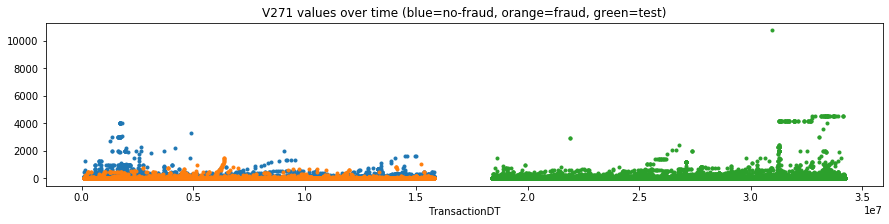

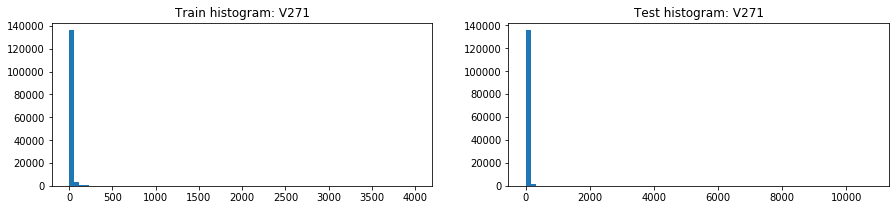

V271          Train   Train fraud  Train Not fraud  \
0           count  141416.000000  10982.000000    130434.000000   
1            mean       9.445133     16.408079         8.858882   
2             std      74.147726     74.354161        74.100747   
3             min       0.000000      0.000000         0.000000   
4             25%       0.000000      0.000000         0.000000   
5             50%       0.000000      0.000000         0.000000   
6             75%       0.000000      0.000000         0.000000   
7             max    4000.000000   1495.000000      4000.000000   
8   unique values    2788.000000    314.000000      2673.000000   
9            NaNs  449124.000000   9681.000000    439443.000000   
10     NaNs share       0.760500      0.468500         0.771100   

             Test   Test public   Test private  
0   137316.000000  17734.000000  119582.000000  
1       12.672403      7.681951      13.412486  
2      136.602559     43.256245     145.416247  
3        0.000000      0.000000       0.000000  
4        0.000000      0.000000       0.000000  
5        0.000000      0.000000       0.000000  
6        0.000000      0.000000       0.000000  
7    10791.570312   1500.000000   10791.570312  
8     2615.000000    567.000000    2358.000000  
9   369375.000000  83605.000000  285771.000000  
10       0.729000      0.825000       0.705000

V271  Count in train (desc)  Mean target  Sum target  Count in test
0 -999.0                 449124     0.021555        9681       369375.0
1    0.0                 128066     0.072830        9327       124022.0
2  100.0                    642     0.054517          35          507.0
3   50.0                    639     0.056338          36          509.0
4   25.0                    323     0.043344          14          283.0
5  150.0                    273     0.157509          43          243.0
6  200.0                    239     0.142259          34          216.0
7   75.0                    203     0.162562          33          156.0
8   20.0                    199     0.035176           7          146.0
9   30.0                    173     0.034682           6          141.0

V271  Count in train  Mean target  Sum target (desc)  Count in test
0 -999.000000          449124     0.021555               9681       369375.0
1    0.000000          128066     0.072830               9327       124022.0
2  450.000000              69     0.666667                 46           40.0
3  150.000000             273     0.157509                 43          243.0
4   52.134998              47     0.914894                 43            NaN
5   86.317902              41     0.902439                 37            1.0
6   50.000000             639     0.056338                 36          509.0
7  100.000000             642     0.054517                 35          507.0
8  200.000000             239     0.142259                 34          216.0
9   75.000000             203     0.162562                 33          156.0

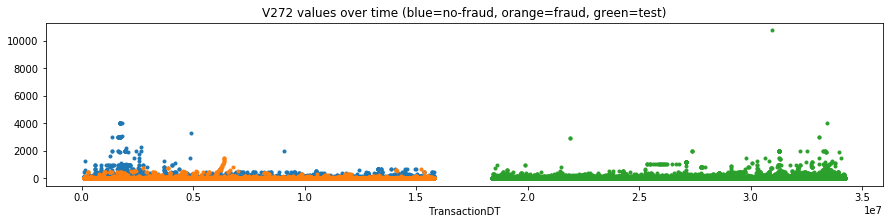

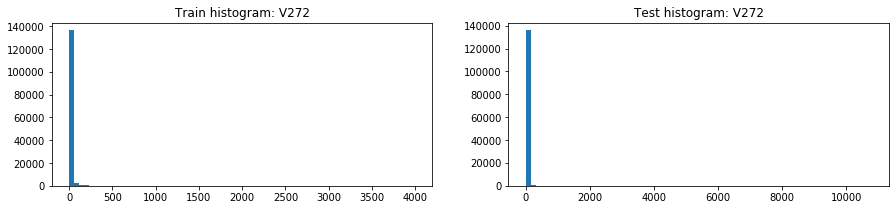

V272          Train   Train fraud  Train Not fraud  \
0           count  141416.000000  10982.000000    130434.000000   
1            mean       8.464571     14.563545         7.951063   
2             std      69.723735     68.029692        69.840441   
3             min       0.000000      0.000000         0.000000   
4             25%       0.000000      0.000000         0.000000   
5             50%       0.000000      0.000000         0.000000   
6             75%       0.000000      0.000000         0.000000   
7             max    4000.000000   1495.000000      4000.000000   
8   unique values    2508.000000    279.000000      2403.000000   
9            NaNs  449124.000000   9681.000000    439443.000000   
10     NaNs share       0.760500      0.468500         0.771100   

             Test   Test public   Test private  
0   137316.000000  17734.000000  119582.000000  
1        8.060808      6.194418       8.337594  
2       66.397778     34.011104      69.930990  
3        0.000000      0.000000       0.000000  
4        0.000000      0.000000       0.000000  
5        0.000000      0.000000       0.000000  
6        0.000000      0.000000       0.000000  
7    10791.570312   1000.000000   10791.570312  
8     2189.000000    492.000000    1984.000000  
9   369375.000000  83605.000000  285771.000000  
10       0.729000      0.825000       0.705000

V272  Count in train (desc)  Mean target  Sum target  Count in test
0 -999.0                 449124     0.021555        9681       369375.0
1    0.0                 128436     0.072986        9374       124655.0
2  100.0                    711     0.080169          57          500.0
3   50.0                    653     0.053599          35          530.0
4   25.0                    344     0.040698          14          283.0
5  150.0                    265     0.173585          46          222.0
6  200.0                    240     0.137500          33          203.0
7   20.0                    195     0.035897           7          141.0
8   30.0                    193     0.036269           7          179.0
9   75.0                    192     0.166667          32          154.0

V272  Count in train  Mean target  Sum target (desc)  Count in test
0 -999.000000          449124     0.021555               9681       369375.0
1    0.000000          128436     0.072986               9374       124655.0
2  100.000000             711     0.080169                 57          500.0
3  150.000000             265     0.173585                 46          222.0
4  450.000000              67     0.671642                 45           30.0
5   52.134998              47     0.914894                 43            NaN
6   86.317902              41     0.902439                 37            1.0
7   50.000000             653     0.053599                 35          530.0
8  200.000000             240     0.137500                 33          203.0
9   75.000000             192     0.166667                 32          154.0

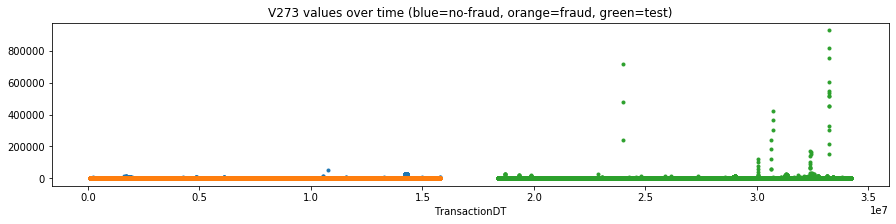

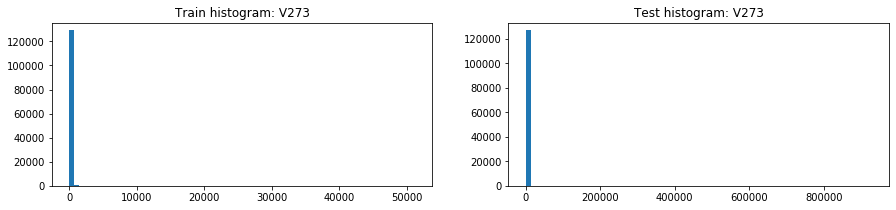

V273          Train   Train fraud  Train Not fraud  \
0           count  130430.000000  10192.000000    120238.000000   
1            mean      73.825549    124.177259        69.557475   
2             std     935.187927    302.272394       969.914136   
3             min       0.000000      0.000000         0.000000   
4             25%       0.000000      0.000000         0.000000   
5             50%       0.000000      0.000000         0.000000   
6             75%       0.000000    121.081802         0.000000   
7             max   51200.000000   5450.000000     51200.000000   
8   unique values    7178.000000   3085.000000      4991.000000   
9            NaNs  460110.000000  10471.000000    449639.000000   
10     NaNs share       0.779100      0.506800         0.789000   

             Test   Test public   Test private  
0   126728.000000  16421.000000  110307.000000  
1      169.879957     96.154644     180.855175  
2     6772.033884    773.580908    7252.418263  
3        0.000000      0.000000       0.000000  
4        0.000000      0.000000       0.000000  
5        0.000000      0.000000       0.000000  
6        0.000000      0.000000       0.000000  
7   928882.000000  26400.000000  928882.000000  
8     6777.000000   1937.000000    5646.000000  
9   379963.000000  84918.000000  295046.000000  
10       0.749900      0.838000       0.727900

V273  Count in train (desc)  Mean target  Sum target  Count in test
0 -999.0                 460110     0.022758       10471       379963.0
1    0.0                 112885     0.047101        5317       109490.0
2  100.0                    976     0.115779         113          529.0
3  200.0                    650     0.176923         115          486.0
4  150.0                    642     0.196262         126          359.0
5   50.0                    637     0.080063          51          331.0
6  300.0                    523     0.217973         114          305.0
7   75.0                    234     0.115385          27          127.0
8  400.0                    229     0.218341          50          255.0
9   25.0                    210     0.071429          15          118.0

V273  Count in train  Mean target  Sum target (desc)  Count in test
0 -999.0          460110     0.022758              10471         379963
1    0.0          112885     0.047101               5317         109490
2  150.0             642     0.196262                126            359
3  200.0             650     0.176923                115            486
4  300.0             523     0.217973                114            305
5  100.0             976     0.115779                113            529
6   50.0             637     0.080063                 51            331
7  400.0             229     0.218341                 50            255
8  450.0             128     0.320312                 41             74
9  600.0             197     0.187817                 37            182

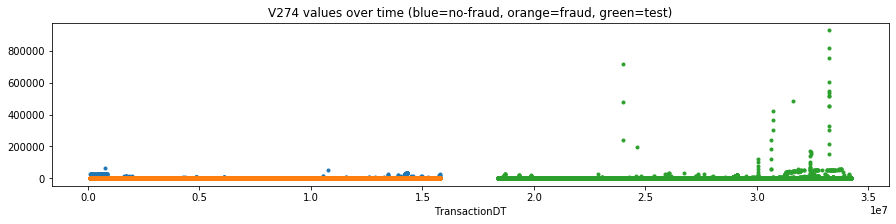

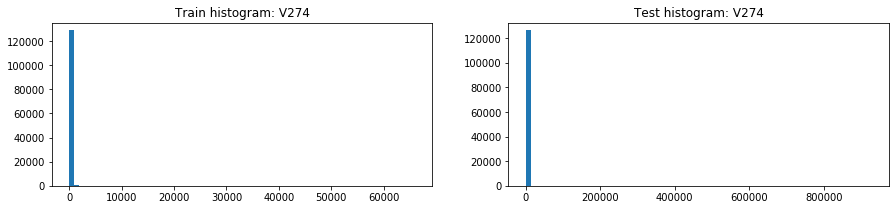

V274          Train   Train fraud  Train Not fraud  \
0           count  130430.000000  10192.000000    120238.000000   
1            mean     107.151636    174.240926       101.464798   
2             std    1258.734139    373.562643      1306.320800   
3             min       0.000000      0.000000         0.000000   
4             25%       0.000000      0.000000         0.000000   
5             50%       0.000000     20.558701         0.000000   
6             75%       0.000000    179.749496         0.000000   
7             max   66000.000000   5450.000000     66000.000000   
8   unique values    8316.000000   3527.000000      5674.000000   
9            NaNs  460110.000000  10471.000000    449639.000000   
10     NaNs share       0.779100      0.506800         0.789000   

             Test   Test public   Test private  
0   126728.000000  16421.000000  110307.000000  
1      231.561159    115.254711     248.875275  
2     7072.082110    810.369728    7573.625079  
3        0.000000      0.000000       0.000000  
4        0.000000      0.000000       0.000000  
5        0.000000      0.000000       0.000000  
6        0.000000      0.000000       0.000000  
7   928882.000000  26400.000000  928882.000000  
8     7955.000000   2182.000000    6620.000000  
9   379963.000000  84918.000000  295046.000000  
10       0.749900      0.838000       0.727900

V274  Count in train (desc)  Mean target  Sum target  Count in test
0 -999.0                 460110     0.022758       10471       379963.0
1    0.0                 110617     0.043257        4785       107458.0
2  100.0                    974     0.120123         117          570.0
3  200.0                    698     0.174785         122          505.0
4  150.0                    684     0.190058         130          370.0
5   50.0                    653     0.079632          52          374.0
6  300.0                    567     0.231041         131          318.0
7  400.0                    259     0.196911          51          264.0
8   75.0                    239     0.104603          25          143.0
9  600.0                    235     0.195745          46          189.0

V274  Count in train  Mean target  Sum target (desc)  Count in test
0 -999.0          460110     0.022758              10471         379963
1    0.0          110617     0.043257               4785         107458
2  300.0             567     0.231041                131            318
3  150.0             684     0.190058                130            370
4  200.0             698     0.174785                122            505
5  100.0             974     0.120123                117            570
6   50.0             653     0.079632                 52            374
7  400.0             259     0.196911                 51            264
8  450.0             152     0.322368                 49             77
9  600.0             235     0.195745                 46            189

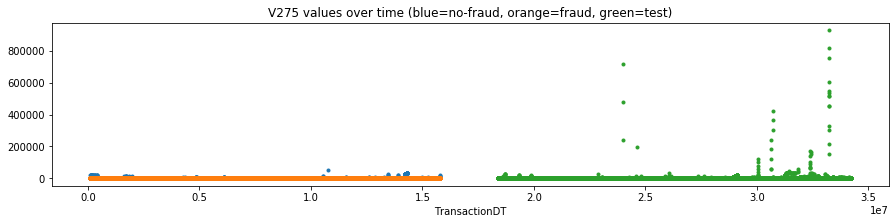

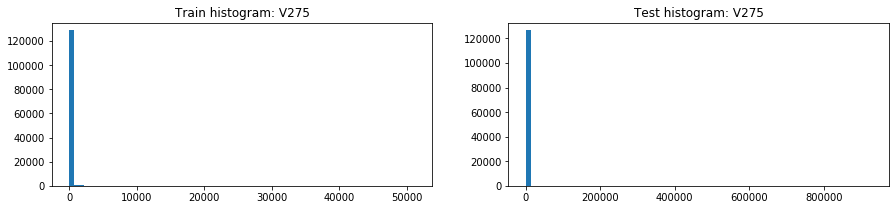

V275          Train   Train fraud  Train Not fraud  \
0           count  130430.000000  10192.000000    120238.000000   
1            mean      88.899939    151.988036        83.552263   
2             std    1072.883139    339.219874      1112.893253   
3             min       0.000000      0.000000         0.000000   
4             25%       0.000000      0.000000         0.000000   
5             50%       0.000000     10.000000         0.000000   
6             75%       0.000000    153.360271         0.000000   
7             max   51200.000000   5450.000000     51200.000000   
8   unique values    7777.000000   3352.000000      5284.000000   
9            NaNs  460110.000000  10471.000000    449639.000000   
10     NaNs share       0.779100      0.506800         0.789000   

             Test   Test public   Test private  
0   126728.000000  16421.000000  110307.000000  
1      197.489221    111.011756     210.362806  
2     6835.809781    803.958639    7320.323442  
3        0.000000      0.000000       0.000000  
4        0.000000      0.000000       0.000000  
5        0.000000      0.000000       0.000000  
6        0.000000      0.000000       0.000000  
7   928882.000000  26400.000000  928882.000000  
8     7495.000000   2079.000000    6236.000000  
9   379963.000000  84918.000000  295046.000000  
10       0.749900      0.838000       0.727900

V275  Count in train (desc)  Mean target  Sum target  Count in test
0 -999.0                 460110     0.022758       10471       379963.0
1    0.0                 111756     0.044839        5011       108466.0
2  100.0                    964     0.116183         112          549.0
3  200.0                    684     0.175439         120          502.0
4  150.0                    663     0.197587         131          363.0
5   50.0                    639     0.078247          50          357.0
6  300.0                    554     0.222022         123          317.0
7  400.0                    252     0.198413          50          259.0
8   75.0                    238     0.105042          25          126.0
9  600.0                    225     0.182222          41          190.0

V275  Count in train  Mean target  Sum target (desc)  Count in test
0 -999.0          460110     0.022758              10471         379963
1    0.0          111756     0.044839               5011         108466
2  150.0             663     0.197587                131            363
3  300.0             554     0.222022                123            317
4  200.0             684     0.175439                120            502
5  100.0             964     0.116183                112            549
6   50.0             639     0.078247                 50            357
7  400.0             252     0.198413                 50            259
8  450.0             146     0.335616                 49             78
9  350.0              71     0.605634                 43             47

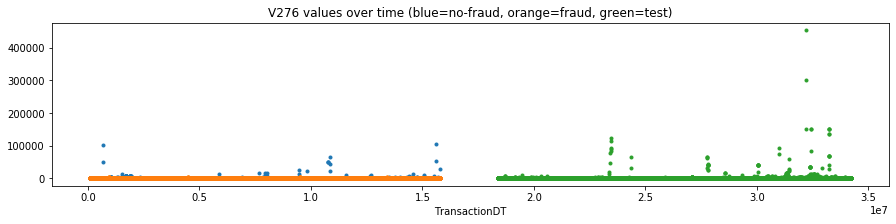

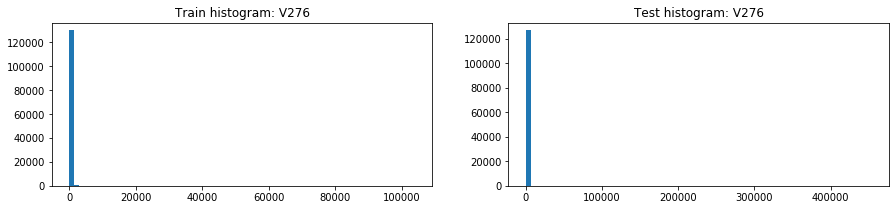

V276          Train   Train fraud  Train Not fraud  \
0           count  130430.000000  10192.000000    120238.000000   
1            mean      31.797277     52.268202        30.062054   
2             std     615.659714    207.245465       638.347369   
3             min       0.000000      0.000000         0.000000   
4             25%       0.000000      0.000000         0.000000   
5             50%       0.000000      0.000000         0.000000   
6             75%       0.000000      0.000000         0.000000   
7             max  104060.000000   4500.000000    104060.000000   
8   unique values    2264.000000    506.000000      2014.000000   
9            NaNs  460110.000000  10471.000000    449639.000000   
10     NaNs share       0.779100      0.506800         0.789000   

             Test   Test public   Test private  
0   126728.000000  16421.000000  110307.000000  
1       69.708952     32.881038      75.191389  
2     2250.666029    241.201938    2410.538157  
3        0.000000      0.000000       0.000000  
4        0.000000      0.000000       0.000000  
5        0.000000      0.000000       0.000000  
6        0.000000      0.000000       0.000000  
7   453750.000000  10000.000000  453750.000000  
8     1963.000000    425.000000    1804.000000  
9   379963.000000  84918.000000  295046.000000  
10       0.749900      0.838000       0.727900

V276  Count in train (desc)  Mean target  Sum target  Count in test
0 -999.0                 460110     0.022758       10471       379963.0
1    0.0                 117724     0.067854        7988       114010.0
2  100.0                   1265     0.086166         109         1040.0
3  200.0                    919     0.130577         120          852.0
4  150.0                    681     0.176211         120          538.0
5   50.0                    650     0.106154          69          511.0
6  300.0                    620     0.224194         139          532.0
7  400.0                    323     0.160991          52          503.0
8  250.0                    301     0.079734          24          371.0
9  600.0                    272     0.224265          61          277.0

V276  Count in train  Mean target  Sum target (desc)  Count in test
0 -999.0          460110     0.022758              10471         379963
1    0.0          117724     0.067854               7988         114010
2  300.0             620     0.224194                139            532
3  200.0             919     0.130577                120            852
4  150.0             681     0.176211                120            538
5  100.0            1265     0.086166                109           1040
6   50.0             650     0.106154                 69            511
7  600.0             272     0.224265                 61            277
8  450.0             155     0.380645                 59             90
9  400.0             323     0.160991                 52            503

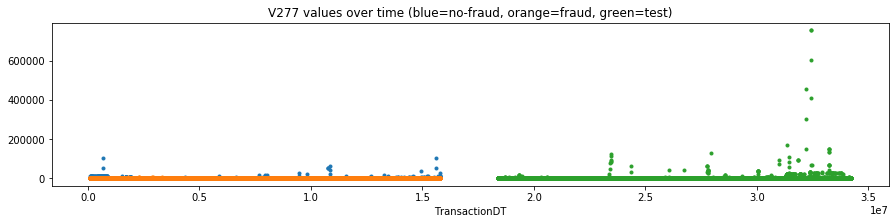

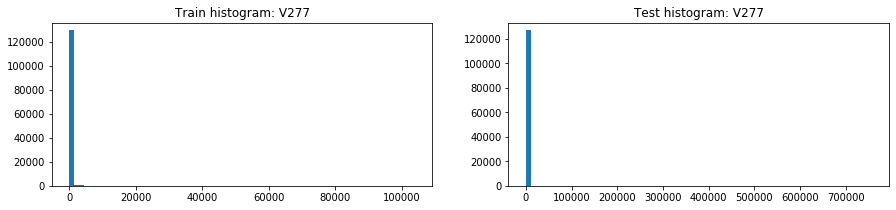

V277          Train   Train fraud  Train Not fraud  \
0           count  130430.000000  10192.000000    120238.000000   
1            mean      51.956645     78.958558        49.667822   
2             std     732.145368    307.370447       757.231698   
3             min       0.000000      0.000000         0.000000   
4             25%       0.000000      0.000000         0.000000   
5             50%       0.000000      0.000000         0.000000   
6             75%       0.000000     17.106775         0.000000   
7             max  104060.000000   6390.000000    104060.000000   
8   unique values    2541.000000    593.000000      2256.000000   
9            NaNs  460110.000000  10471.000000    449639.000000   
10     NaNs share       0.779100      0.506800         0.789000   

             Test   Test public   Test private  
0   126728.000000  16421.000000  110307.000000  
1      115.530497     42.505812     126.401416  
2     4376.075400    400.039240    4687.869829  
3        0.000000      0.000000       0.000000  
4        0.000000      0.000000       0.000000  
5        0.000000      0.000000       0.000000  
6        0.000000      0.000000       0.000000  
7   756250.000000  19200.000000  756250.000000  
8     2229.000000    497.000000    2047.000000  
9   379963.000000  84918.000000  295046.000000  
10       0.749900      0.838000       0.727900

V277  Count in train (desc)  Mean target  Sum target  Count in test
0 -999.0                 460110     0.022758       10471       379963.0
1    0.0                 115566     0.063842        7378       111713.0
2  100.0                   1339     0.091860         123         1097.0
3  200.0                    969     0.121775         118          891.0
4   50.0                    729     0.098765          72          563.0
5  150.0                    710     0.176056         125          556.0
6  300.0                    646     0.207430         134          576.0
7  400.0                    360     0.180556          65          524.0
8  250.0                    306     0.078431          24          388.0
9  600.0                    298     0.244966          73          294.0

V277  Count in train  Mean target  Sum target (desc)  Count in test
0 -999.000000          460110     0.022758              10471       379963.0
1    0.000000          115566     0.063842               7378       111713.0
2  300.000000             646     0.207430                134          576.0
3  150.000000             710     0.176056                125          556.0
4  100.000000            1339     0.091860                123         1097.0
5  200.000000             969     0.121775                118          891.0
6  600.000000             298     0.244966                 73          294.0
7   50.000000             729     0.098765                 72          563.0
8  400.000000             360     0.180556                 65          524.0
9  176.426407              52     0.980769                 51            NaN

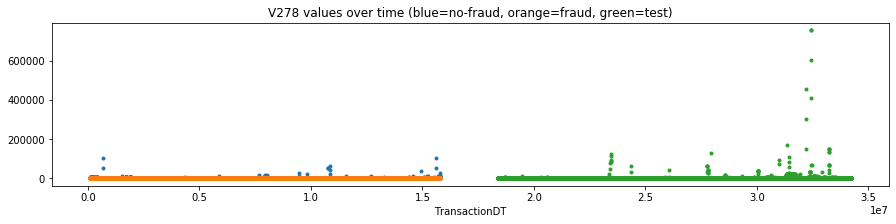

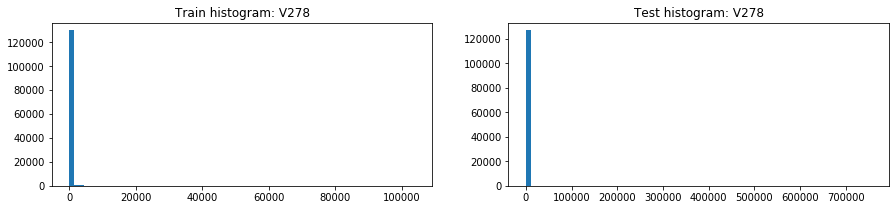

V278          Train   Train fraud  Train Not fraud  \
0           count  130430.000000  10192.000000    120238.000000   
1            mean      42.328228     65.108035        40.397293   
2             std     660.611820    247.687530       684.217058   
3             min       0.000000      0.000000         0.000000   
4             25%       0.000000      0.000000         0.000000   
5             50%       0.000000      0.000000         0.000000   
6             75%       0.000000      0.000000         0.000000   
7             max  104060.000000   4500.000000    104060.000000   
8   unique values    2399.000000    552.000000      2126.000000   
9            NaNs  460110.000000  10471.000000    449639.000000   
10     NaNs share       0.779100      0.506800         0.789000   

             Test   Test public   Test private  
0   126728.000000  16421.000000  110307.000000  
1       99.519602     35.995625     108.976184  
2     4313.107711    254.757050    4621.895439  
3        0.000000      0.000000       0.000000  
4        0.000000      0.000000       0.000000  
5        0.000000      0.000000       0.000000  
6        0.000000      0.000000       0.000000  
7   756250.000000  10000.000000  756250.000000  
8     2081.000000    456.000000    1919.000000  
9   379963.000000  84918.000000  295046.000000  
10       0.749900      0.838000       0.727900

V278  Count in train (desc)  Mean target  Sum target  Count in test
0 -999.0                 460110     0.022758       10471       379963.0
1    0.0                 116709     0.065813        7681       112917.0
2  100.0                   1295     0.088803         115         1060.0
3  200.0                    949     0.124341         118          882.0
4  150.0                    694     0.175793         122          552.0
5   50.0                    687     0.107715          74          548.0
6  300.0                    644     0.228261         147          560.0
7  400.0                    342     0.175439          60          502.0
8  250.0                    303     0.079208          24          382.0
9  600.0                    286     0.227273          65          284.0

V278  Count in train  Mean target  Sum target (desc)  Count in test
0 -999.0          460110     0.022758              10471         379963
1    0.0          116709     0.065813               7681         112917
2  300.0             644     0.228261                147            560
3  150.0             694     0.175793                122            552
4  200.0             949     0.124341                118            882
5  100.0            1295     0.088803                115           1060
6   50.0             687     0.107715                 74            548
7  600.0             286     0.227273                 65            284
8  400.0             342     0.175439                 60            502
9  450.0             159     0.345912                 55             88

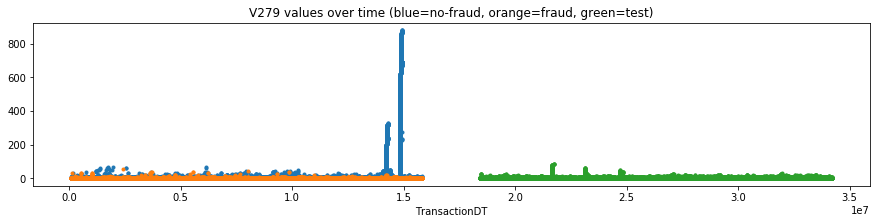

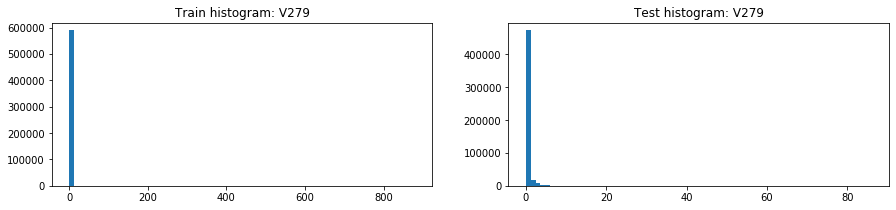

V279          Train   Train fraud  Train Not fraud  \
0           count  590528.000000  20661.000000    569867.000000   
1            mean       1.123061      0.708920         1.138076   
2             std      21.021950      1.894142        21.396452   
3             min       0.000000      0.000000         0.000000   
4             25%       0.000000      0.000000         0.000000   
5             50%       0.000000      0.000000         0.000000   
6             75%       0.000000      1.000000         0.000000   
7             max     880.000000     55.000000       880.000000   
8   unique values     882.000000     39.000000       882.000000   
9            NaNs      12.000000      2.000000        10.000000   
10     NaNs share       0.000000      0.000100         0.000000   

             Test    Test public   Test private  
0   506688.000000  101336.000000  405353.000000  
1        0.338571       0.362319       0.332634  
2        1.320341       1.771958       1.180679  
3        0.000000       0.000000       0.000000  
4        0.000000       0.000000       0.000000  
5        0.000000       0.000000       0.000000  
6        0.000000       0.000000       0.000000  
7       86.000000      86.000000      62.000000  
8       88.000000      88.000000      63.000000  
9        3.000000       3.000000       0.000000  
10       0.000000       0.000000       0.000000

V279  Count in train (desc)  Mean target  Sum target  Count in test
0   0.0                 492169     0.028626       14089       418709.0
1   1.0                  60474     0.059149        3577        54339.0
2   2.0                  18826     0.072825        1371        17106.0
3   3.0                   8016     0.085454         685         7260.0
4   4.0                   4030     0.089826         362         3691.0
5   5.0                   2103     0.095102         200         1927.0
6   6.0                   1235     0.095547         118         1129.0
7   7.0                    736     0.110054          81          723.0
8   8.0                    449     0.106904          48          458.0
9   9.0                    295     0.108475          32          320.0

V279  Count in train  Mean target  Sum target (desc)  Count in test
0   0.0          492169     0.028626              14089         418709
1   1.0           60474     0.059149               3577          54339
2   2.0           18826     0.072825               1371          17106
3   3.0            8016     0.085454                685           7260
4   4.0            4030     0.089826                362           3691
5   5.0            2103     0.095102                200           1927
6   6.0            1235     0.095547                118           1129
7   7.0             736     0.110054                 81            723
8   8.0             449     0.106904                 48            458
9   9.0             295     0.108475                 32            320

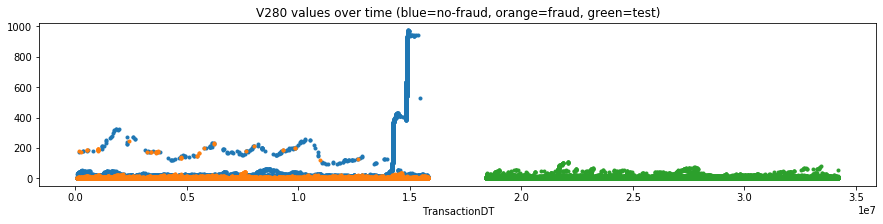

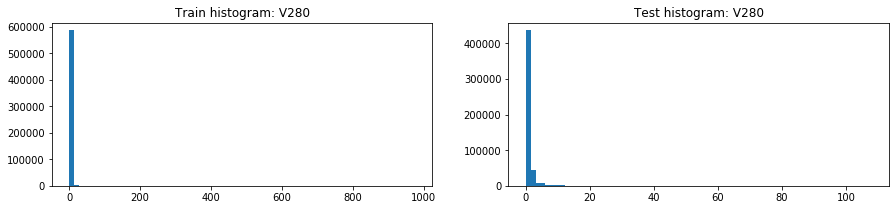

V280          Train   Train fraud  Train Not fraud  \
0           count  590528.000000  20661.000000    569867.000000   
1            mean       1.967082      1.852669         1.971230   
2             std      27.851780      8.797109        28.302649   
3             min       0.000000      0.000000         0.000000   
4             25%       0.000000      0.000000         0.000000   
5             50%       0.000000      0.000000         0.000000   
6             75%       1.000000      2.000000         1.000000   
7             max     975.000000    243.000000       975.000000   
8   unique values     976.000000     82.000000       976.000000   
9            NaNs      12.000000      2.000000        10.000000   
10     NaNs share       0.000000      0.000100         0.000000   

             Test    Test public   Test private  
0   506688.000000  101336.000000  405353.000000  
1        0.744304       0.799943       0.730393  
2        2.376751       2.596933       2.318234  
3        0.000000       0.000000       0.000000  
4        0.000000       0.000000       0.000000  
5        0.000000       0.000000       0.000000  
6        1.000000       1.000000       1.000000  
7      108.000000      89.000000     108.000000  
8      110.000000      91.000000      92.000000  
9        3.000000       3.000000       0.000000  
10       0.000000       0.000000       0.000000

V280  Count in train (desc)  Mean target  Sum target  Count in test
0   0.0                 422464     0.027337       11549       356312.0
1   1.0                  90882     0.040778        3706        80039.0
2   2.0                  32870     0.052997        1742        30342.0
3   3.0                  15309     0.067477        1033        14444.0
4   4.0                   8340     0.078297         653         7916.0
5   5.0                   5173     0.085057         440         5000.0
6   6.0                   3411     0.092935         317         3303.0
7   7.0                   2324     0.098537         229         2206.0
8   8.0                   1618     0.110630         179         1557.0
9   9.0                   1219     0.118950         145         1131.0

V280  Count in train  Mean target  Sum target (desc)  Count in test
0   0.0          422464     0.027337              11549         356312
1   1.0           90882     0.040778               3706          80039
2   2.0           32870     0.052997               1742          30342
3   3.0           15309     0.067477               1033          14444
4   4.0            8340     0.078297                653           7916
5   5.0            5173     0.085057                440           5000
6   6.0            3411     0.092935                317           3303
7   7.0            2324     0.098537                229           2206
8   8.0            1618     0.110630                179           1557
9   9.0            1219     0.118950                145           1131

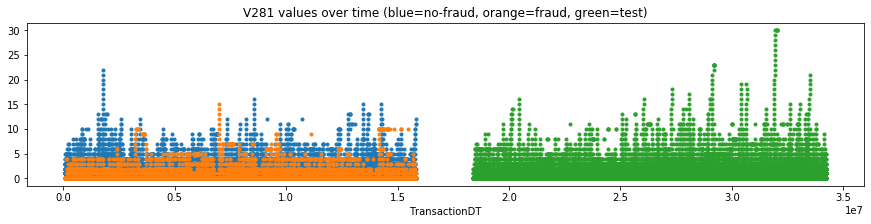

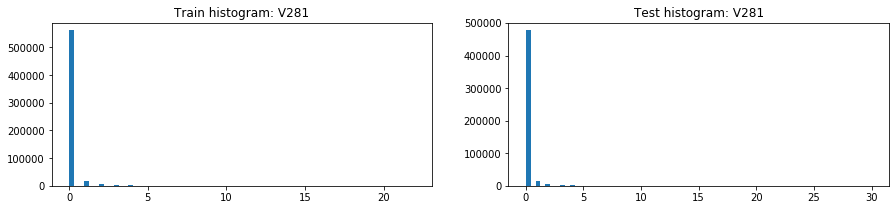

V281          Train   Train fraud  Train Not fraud  \
0           count  589271.000000  20617.000000    568654.000000   
1            mean       0.087783      0.283358         0.080692   
2             std       0.512748      0.996906         0.484742   
3             min       0.000000      0.000000         0.000000   
4             25%       0.000000      0.000000         0.000000   
5             50%       0.000000      0.000000         0.000000   
6             75%       0.000000      0.000000         0.000000   
7             max      22.000000     15.000000        22.000000   
8   unique values      24.000000     17.000000        24.000000   
9            NaNs    1269.000000     46.000000      1223.000000   
10     NaNs share       0.002100      0.002200         0.002100   

             Test    Test public   Test private  
0   500660.000000  100922.000000  399739.000000  
1        0.092492       0.081271       0.095325  
2        0.587742       0.486736       0.610574  
3        0.000000       0.000000       0.000000  
4        0.000000       0.000000       0.000000  
5        0.000000       0.000000       0.000000  
6        0.000000       0.000000       0.000000  
7       30.000000      16.000000      30.000000  
8       32.000000      18.000000      32.000000  
9     6031.000000     417.000000    5614.000000  
10       0.011900       0.004100       0.013800

V281  Count in train (desc)  Mean target  Sum target  Count in test
0    0.0                 561201     0.032149       18042         476893
1    1.0                  16896     0.072917        1232          14399
2    2.0                   5694     0.101862         580           4430
3    3.0                   2484     0.106683         265           2092
4    4.0                   1469     0.187883         276           1227
5 -999.0                   1269     0.036249          46           6031
6    5.0                    604     0.132450          80            566
7    6.0                    351     0.076923          27            371
8    7.0                    225     0.222222          50            187
9    8.0                    102     0.039216           4            149

V281  Count in train  Mean target  Sum target (desc)  Count in test
0    0.0          561201     0.032149              18042         476893
1    1.0           16896     0.072917               1232          14399
2    2.0            5694     0.101862                580           4430
3    4.0            1469     0.187883                276           1227
4    3.0            2484     0.106683                265           2092
5    5.0             604     0.132450                 80            566
6    7.0             225     0.222222                 50            187
7 -999.0            1269     0.036249                 46           6031
8   10.0              86     0.441860                 38             65
9    6.0             351     0.076923                 27            371

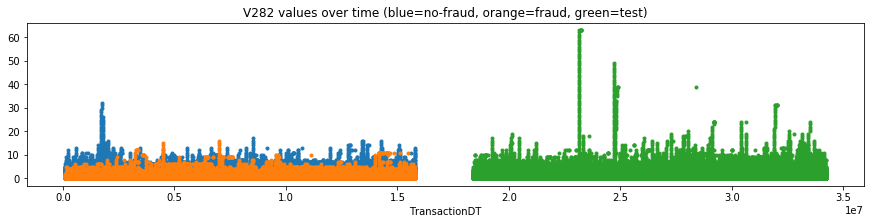

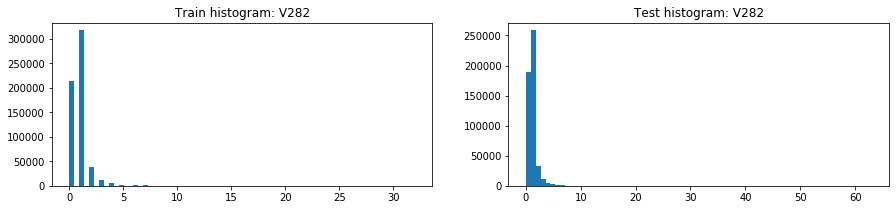

V282          Train   Train fraud  Train Not fraud  \
0           count  589271.000000  20617.000000    568654.000000   
1            mean       0.817171      1.321288         0.798894   
2             std       0.921880      1.329711         0.898346   
3             min       0.000000      0.000000         0.000000   
4             25%       0.000000      1.000000         0.000000   
5             50%       1.000000      1.000000         1.000000   
6             75%       1.000000      1.000000         1.000000   
7             max      32.000000     16.000000        32.000000   
8   unique values      34.000000     18.000000        34.000000   
9            NaNs    1269.000000     46.000000      1223.000000   
10     NaNs share       0.002100      0.002200         0.002100   

             Test    Test public   Test private  
0   500660.000000  100922.000000  399739.000000  
1        0.825470       0.769456       0.839610  
2        1.154029       0.956744       1.198302  
3        0.000000       0.000000       0.000000  
4        0.000000       0.000000       0.000000  
5        1.000000       1.000000       1.000000  
6        1.000000       1.000000       1.000000  
7       63.000000      19.000000      63.000000  
8       65.000000      21.000000      65.000000  
9     6031.000000     417.000000    5614.000000  
10       0.011900       0.004100       0.013800

V282  Count in train (desc)  Mean target  Sum target  Count in test
0    1.0                 316455     0.037983       12020         258242
1    0.0                 212812     0.016714        3557         189170
2    2.0                  37537     0.074220        2786          32735
3    3.0                  12243     0.088132        1079          10738
4    4.0                   4976     0.097468         485           4369
5    5.0                   2525     0.125545         317           2378
6 -999.0                   1269     0.036249          46           6031
7    6.0                   1130     0.141593         160           1068
8    7.0                    652     0.090491          59            604
9    8.0                    312     0.073718          23            377

V282  Count in train  Mean target  Sum target (desc)  Count in test
0    1.0          316455     0.037983              12020         258242
1    0.0          212812     0.016714               3557         189170
2    2.0           37537     0.074220               2786          32735
3    3.0           12243     0.088132               1079          10738
4    4.0            4976     0.097468                485           4369
5    5.0            2525     0.125545                317           2378
6    6.0            1130     0.141593                160           1068
7    9.0             242     0.247934                 60            264
8    7.0             652     0.090491                 59            604
9 -999.0            1269     0.036249                 46           6031

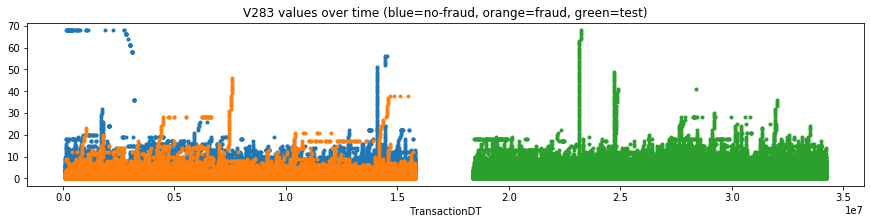

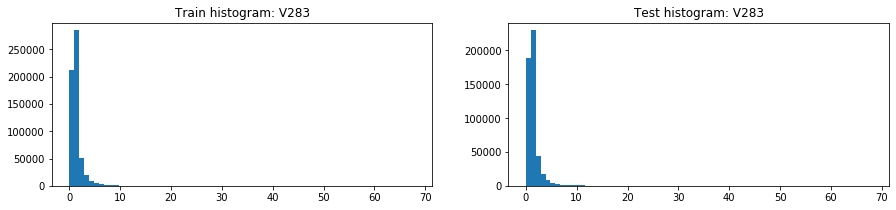

V283          Train   Train fraud  Train Not fraud  \
0           count  589271.000000  20617.000000    568654.000000   
1            mean       0.991114      1.913955         0.957656   
2             std       1.558731      2.932971         1.474404   
3             min       0.000000      0.000000         0.000000   
4             25%       0.000000      1.000000         0.000000   
5             50%       1.000000      1.000000         1.000000   
6             75%       1.000000      2.000000         1.000000   
7             max      68.000000     46.000000        68.000000   
8   unique values      63.000000     48.000000        63.000000   
9            NaNs    1269.000000     46.000000      1223.000000   
10     NaNs share       0.002100      0.002200         0.002100   

             Test    Test public   Test private  
0   500660.000000  100922.000000  399739.000000  
1        1.007614       0.947762       1.022722  
2        1.560327       1.417323       1.594050  
3        0.000000       0.000000       0.000000  
4        0.000000       0.000000       0.000000  
5        1.000000       1.000000       1.000000  
6        1.000000       1.000000       1.000000  
7       68.000000      19.000000      68.000000  
8       70.000000      21.000000      70.000000  
9     6031.000000     417.000000    5614.000000  
10       0.011900       0.004100       0.013800

V283  Count in train (desc)  Mean target  Sum target  Count in test
0    1.0                 284599     0.035601       10132         229390
1    0.0                 211499     0.016648        3521         188164
2    2.0                  51773     0.057907        2998          44471
3    3.0                  18984     0.072061        1368          17017
4    4.0                   8912     0.090664         808           8297
5    5.0                   4955     0.112614         558           4503
6    6.0                   2847     0.106077         302           2767
7    7.0                   1720     0.104651         180           1707
8 -999.0                   1269     0.036249          46           6031
9    8.0                   1118     0.132379         148           1058

V283  Count in train  Mean target  Sum target (desc)  Count in test
0   1.0          284599     0.035601              10132         229390
1   0.0          211499     0.016648               3521         188164
2   2.0           51773     0.057907               2998          44471
3   3.0           18984     0.072061               1368          17017
4   4.0            8912     0.090664                808           8297
5   5.0            4955     0.112614                558           4503
6   6.0            2847     0.106077                302           2767
7   7.0            1720     0.104651                180           1707
8   8.0            1118     0.132379                148           1058
9   9.0             661     0.164902                109            761

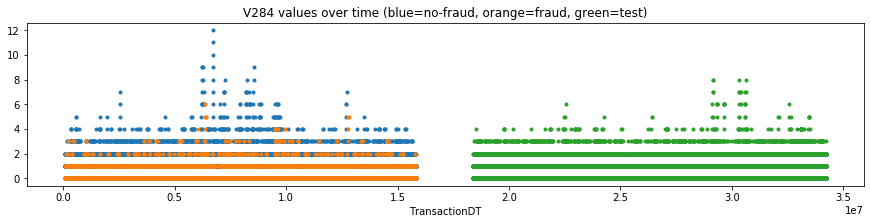

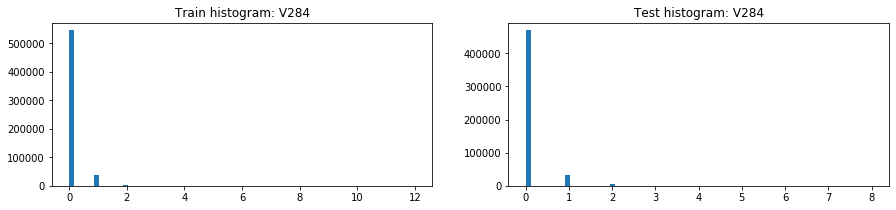

V284          Train   Train fraud  Train Not fraud  \
0           count  590528.000000  20661.000000    569867.000000   
1            mean       0.088543      0.151300         0.086267   
2             std       0.338424      0.435648         0.334147   
3             min       0.000000      0.000000         0.000000   
4             25%       0.000000      0.000000         0.000000   
5             50%       0.000000      0.000000         0.000000   
6             75%       0.000000      0.000000         0.000000   
7             max      12.000000      6.000000        12.000000   
8   unique values      14.000000      8.000000        14.000000   
9            NaNs      12.000000      2.000000        10.000000   
10     NaNs share       0.000000      0.000100         0.000000   

             Test    Test public   Test private  
0   506688.000000  101336.000000  405353.000000  
1        0.087103       0.083870       0.087911  
2        0.332353       0.318415       0.335742  
3        0.000000       0.000000       0.000000  
4        0.000000       0.000000       0.000000  
5        0.000000       0.000000       0.000000  
6        0.000000       0.000000       0.000000  
7        8.000000       4.000000       8.000000  
8       10.000000       6.000000       9.000000  
9        3.000000       3.000000       0.000000  
10       0.000000       0.000000       0.000000

V284  Count in train (desc)  Mean target  Sum target  Count in test
0    0.0                 545552     0.033047       18029       468718.0
1    1.0                  39347     0.057082        2246        33057.0
2    2.0                   4481     0.067396         302         3926.0
3    3.0                    846     0.079196          67          818.0
4    4.0                    190     0.057895          11          119.0
5    5.0                     49     0.102041           5           21.0
6    6.0                     34     0.029412           1           17.0
7    7.0                     15     0.000000           0            8.0
8 -999.0                     12     0.166667           2            3.0
9    8.0                      6     0.000000           0            4.0

V284  Count in train  Mean target  Sum target (desc)  Count in test
0    0.0          545552     0.033047              18029         468718
1    1.0           39347     0.057082               2246          33057
2    2.0            4481     0.067396                302           3926
3    3.0             846     0.079196                 67            818
4    4.0             190     0.057895                 11            119
5    5.0              49     0.102041                  5             21
6 -999.0              12     0.166667                  2              3
7    6.0              34     0.029412                  1             17
8    7.0              15     0.000000                  0              8
9    8.0               6     0.000000                  0              4

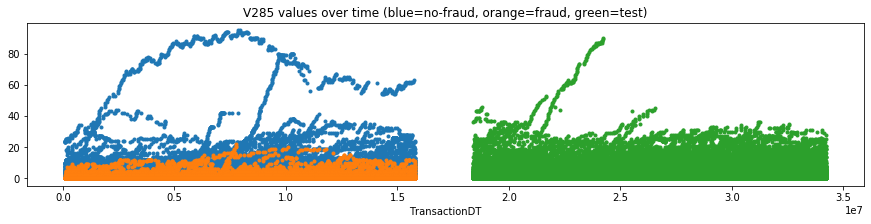

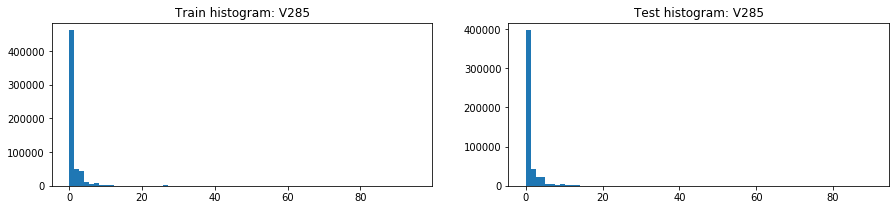

V285          Train   Train fraud  Train Not fraud  \
0           count  590528.000000  20661.000000    569867.000000   
1            mean       1.167660      1.010309         1.173365   
2             std       3.282454      2.203654         3.314839   
3             min       0.000000      0.000000         0.000000   
4             25%       0.000000      0.000000         0.000000   
5             50%       0.000000      0.000000         0.000000   
6             75%       1.000000      1.000000         1.000000   
7             max      95.000000     22.000000        95.000000   
8   unique values      97.000000     24.000000        97.000000   
9            NaNs      12.000000      2.000000        10.000000   
10     NaNs share       0.000000      0.000100         0.000000   

             Test    Test public   Test private  
0   506688.000000  101336.000000  405353.000000  
1        1.150909       1.224175       1.132598  
2        2.724523       2.742624       2.719672  
3        0.000000       0.000000       0.000000  
4        0.000000       0.000000       0.000000  
5        0.000000       0.000000       0.000000  
6        1.000000       1.000000       1.000000  
7       90.000000      53.000000      90.000000  
8       92.000000      55.000000      91.000000  
9        3.000000       3.000000       0.000000  
10       0.000000       0.000000       0.000000

V285  Count in train (desc)  Mean target  Sum target  Count in test
0   0.0                 354815     0.038147       13535       303975.0
1   1.0                 106275     0.029461        3131        92384.0
2   2.0                  50008     0.028016        1401        42284.0
3   3.0                  26969     0.026957         727        22334.0
4   4.0                  17739     0.029145         517        14754.0
5   5.0                   9923     0.033256         330         8034.0
6   6.0                   6596     0.044421         293         5654.0
7   7.0                   4390     0.035991         158         3761.0
8   8.0                   3130     0.036422         114         2741.0
9   9.0                   2329     0.044654         104         2105.0

V285  Count in train  Mean target  Sum target (desc)  Count in test
0   0.0          354815     0.038147              13535         303975
1   1.0          106275     0.029461               3131          92384
2   2.0           50008     0.028016               1401          42284
3   3.0           26969     0.026957                727          22334
4   4.0           17739     0.029145                517          14754
5   5.0            9923     0.033256                330           8034
6   6.0            6596     0.044421                293           5654
7   7.0            4390     0.035991                158           3761
8   8.0            3130     0.036422                114           2741
9   9.0            2329     0.044654                104           2105

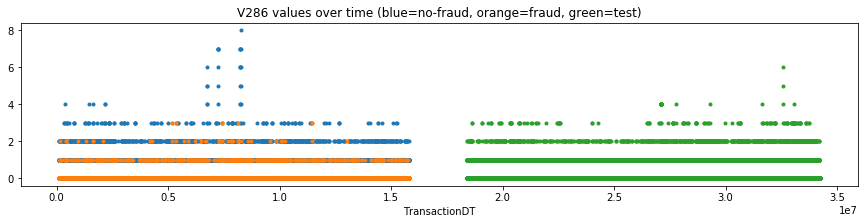

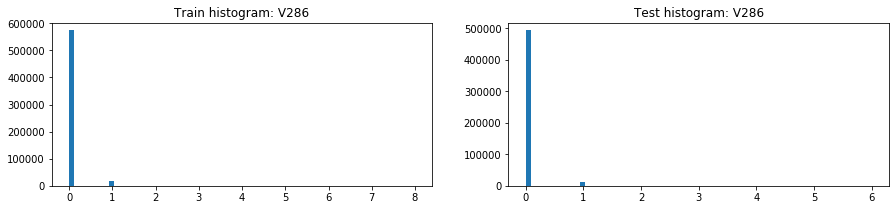

V286          Train   Train fraud  Train Not fraud  \
0           count  590528.000000  20661.000000    569867.000000   
1            mean       0.031492      0.035913         0.031332   
2             std       0.190939      0.202758         0.190495   
3             min       0.000000      0.000000         0.000000   
4             25%       0.000000      0.000000         0.000000   
5             50%       0.000000      0.000000         0.000000   
6             75%       0.000000      0.000000         0.000000   
7             max       8.000000      3.000000         8.000000   
8   unique values      10.000000      5.000000        10.000000   
9            NaNs      12.000000      2.000000        10.000000   
10     NaNs share       0.000000      0.000100         0.000000   

             Test    Test public   Test private  
0   506688.000000  101336.000000  405353.000000  
1        0.030628       0.026220       0.031730  
2        0.189638       0.174094       0.193312  
3        0.000000       0.000000       0.000000  
4        0.000000       0.000000       0.000000  
5        0.000000       0.000000       0.000000  
6        0.000000       0.000000       0.000000  
7        6.000000       3.000000       6.000000  
8        8.000000       5.000000       7.000000  
9        3.000000       3.000000       0.000000  
10       0.000000       0.000000       0.000000

V286  Count in train (desc)  Mean target  Sum target  Count in test
0    0.0                 573290     0.034848       19978       492506.0
1    1.0                  16122     0.039201         632        13058.0
2    2.0                    949     0.045311          43          946.0
3    3.0                    136     0.058824           8          146.0
4 -999.0                     12     0.166667           2            3.0
5    4.0                     11     0.000000           0           30.0
6    7.0                      8     0.000000           0            NaN
7    6.0                      6     0.000000           0            1.0
8    5.0                      5     0.000000           0            1.0
9    8.0                      1     0.000000           0            NaN

V286  Count in train  Mean target  Sum target (desc)  Count in test
0    0.0          573290     0.034848              19978       492506.0
1    1.0           16122     0.039201                632        13058.0
2    2.0             949     0.045311                 43          946.0
3    3.0             136     0.058824                  8          146.0
4 -999.0              12     0.166667                  2            3.0
5    4.0              11     0.000000                  0           30.0
6    7.0               8     0.000000                  0            NaN
7    6.0               6     0.000000                  0            1.0
8    5.0               5     0.000000                  0            1.0
9    8.0               1     0.000000                  0            NaN

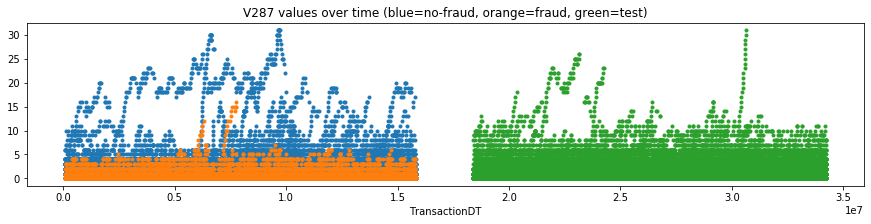

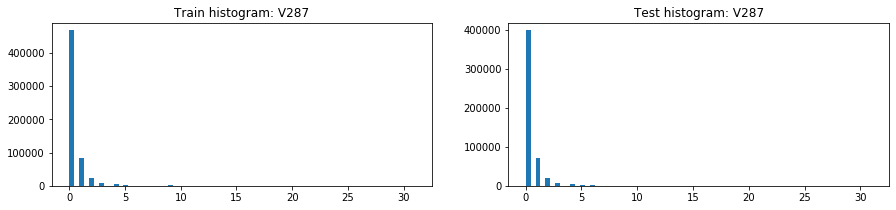

V287          Train   Train fraud  Train Not fraud  \
0           count  590528.000000  20661.000000    569867.000000   
1            mean       0.358579      0.474275         0.354384   
2             std       1.078995      0.999167         1.081547   
3             min       0.000000      0.000000         0.000000   
4             25%       0.000000      0.000000         0.000000   
5             50%       0.000000      0.000000         0.000000   
6             75%       0.000000      1.000000         0.000000   
7             max      31.000000     16.000000        31.000000   
8   unique values      33.000000     18.000000        33.000000   
9            NaNs      12.000000      2.000000        10.000000   
10     NaNs share       0.000000      0.000100         0.000000   

             Test    Test public   Test private  
0   506688.000000  101336.000000  405353.000000  
1        0.353792       0.364431       0.351131  
2        0.940210       0.927710       0.943290  
3        0.000000       0.000000       0.000000  
4        0.000000       0.000000       0.000000  
5        0.000000       0.000000       0.000000  
6        0.000000       0.000000       0.000000  
7       31.000000      21.000000      31.000000  
8       33.000000      23.000000      32.000000  
9        3.000000       3.000000       0.000000  
10       0.000000       0.000000       0.000000

V287  Count in train (desc)  Mean target  Sum target  Count in test
0   0.0                 466863     0.032099       14986         398789
1   1.0                  83560     0.040366        3373          72136
2   2.0                  22186     0.056477        1253          19518
3   3.0                   8784     0.066940         588           7850
4   4.0                   4863     0.070944         345           4666
5   9.0                   1056     0.004735           5            200
6   5.0                    989     0.058645          58           1503
7   7.0                    683     0.008785           6            441
8   6.0                    463     0.060475          28            838
9   8.0                    218     0.009174           2            298

V287  Count in train  Mean target  Sum target (desc)  Count in test
0   0.0          466863     0.032099              14986         398789
1   1.0           83560     0.040366               3373          72136
2   2.0           22186     0.056477               1253          19518
3   3.0            8784     0.066940                588           7850
4   4.0            4863     0.070944                345           4666
5   5.0             989     0.058645                 58           1503
6   6.0             463     0.060475                 28            838
7   7.0             683     0.008785                  6            441
8   9.0            1056     0.004735                  5            200
9  10.0             128     0.031250                  4            149

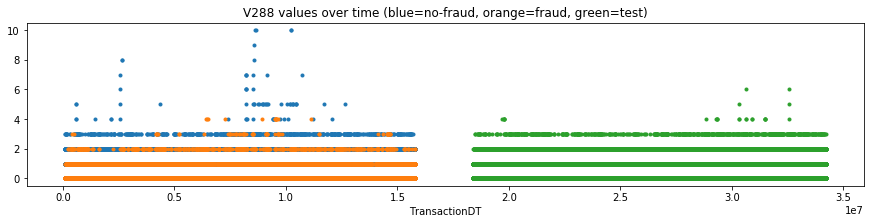

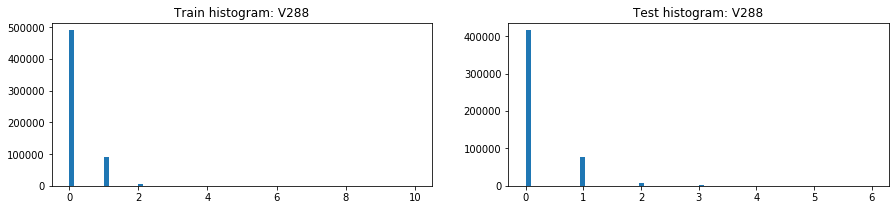

V288          Train   Train fraud  Train Not fraud  \
0           count  589271.000000  20617.000000    568654.000000   
1            mean       0.184350      0.264296         0.181451   
2             std       0.430989      0.526318         0.426852   
3             min       0.000000      0.000000         0.000000   
4             25%       0.000000      0.000000         0.000000   
5             50%       0.000000      0.000000         0.000000   
6             75%       0.000000      0.000000         0.000000   
7             max      10.000000      4.000000        10.000000   
8   unique values      12.000000      6.000000        12.000000   
9            NaNs    1269.000000     46.000000      1223.000000   
10     NaNs share       0.002100      0.002200         0.002100   

             Test    Test public   Test private  
0   500660.000000  100922.000000  399739.000000  
1        0.187273       0.185946       0.187607  
2        0.435739       0.435680       0.435753  
3        0.000000       0.000000       0.000000  
4        0.000000       0.000000       0.000000  
5        0.000000       0.000000       0.000000  
6        0.000000       0.000000       0.000000  
7        6.000000       4.000000       6.000000  
8        8.000000       6.000000       8.000000  
9     6031.000000     417.000000    5614.000000  
10       0.011900       0.004100       0.013800

V288  Count in train (desc)  Mean target  Sum target  Count in test
0    0.0                 489641     0.032507       15917       415370.0
1    1.0                  91654     0.044079        4040        77740.0
2    2.0                   7133     0.081873         584         6661.0
3 -999.0                   1269     0.036249          46         6031.0
4    3.0                    761     0.082786          63          864.0
5    4.0                     33     0.393939          13           21.0
6    5.0                     29     0.000000           0            2.0
7    7.0                      7     0.000000           0            NaN
8    6.0                      5     0.000000           0            2.0
9   10.0                      4     0.000000           0            NaN

V288  Count in train  Mean target  Sum target (desc)  Count in test
0    0.0          489641     0.032507              15917       415370.0
1    1.0           91654     0.044079               4040        77740.0
2    2.0            7133     0.081873                584         6661.0
3    3.0             761     0.082786                 63          864.0
4 -999.0            1269     0.036249                 46         6031.0
5    4.0              33     0.393939                 13           21.0
6    5.0              29     0.000000                  0            2.0
7    7.0               7     0.000000                  0            NaN
8    6.0               5     0.000000                  0            2.0
9   10.0               4     0.000000                  0            NaN

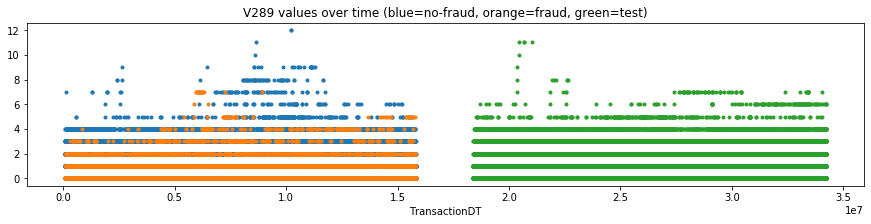

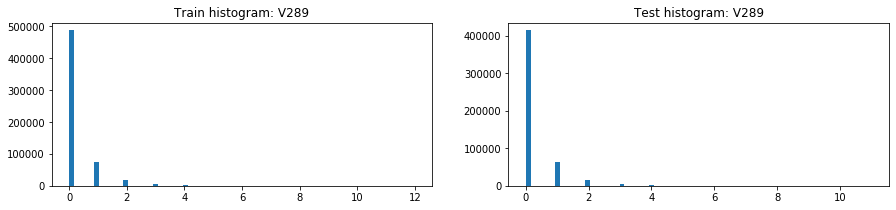

V289          Train   Train fraud  Train Not fraud  \
0           count  589271.000000  20617.000000    568654.000000   
1            mean       0.235975      0.370131         0.231111   
2             std       0.599231      0.804965         0.589855   
3             min       0.000000      0.000000         0.000000   
4             25%       0.000000      0.000000         0.000000   
5             50%       0.000000      0.000000         0.000000   
6             75%       0.000000      0.000000         0.000000   
7             max      12.000000      7.000000        12.000000   
8   unique values      14.000000      9.000000        14.000000   
9            NaNs    1269.000000     46.000000      1223.000000   
10     NaNs share       0.002100      0.002200         0.002100   

             Test    Test public   Test private  
0   500660.000000  100922.000000  399739.000000  
1        0.240742       0.240413       0.240825  
2        0.614691       0.615797       0.614411  
3        0.000000       0.000000       0.000000  
4        0.000000       0.000000       0.000000  
5        0.000000       0.000000       0.000000  
6        0.000000       0.000000       0.000000  
7       11.000000      11.000000       8.000000  
8       13.000000      13.000000      10.000000  
9     6031.000000     417.000000    5614.000000  
10       0.011900       0.004100       0.013800

V289  Count in train (desc)  Mean target  Sum target  Count in test
0    0.0                 487073     0.032394       15778       413471.0
1    1.0                  75947     0.039857        3027        64498.0
2    2.0                  18920     0.063108        1194        15543.0
3    3.0                   5076     0.069149         351         4501.0
4    4.0                   1736     0.117512         204         2112.0
5 -999.0                   1269     0.036249          46         6031.0
6    5.0                    288     0.159722          46          320.0
7    7.0                     82     0.182927          15           64.0
8    6.0                     73     0.027397           2          138.0
9    8.0                     51     0.000000           0            7.0

V289  Count in train  Mean target  Sum target (desc)  Count in test
0    0.0          487073     0.032394              15778         413471
1    1.0           75947     0.039857               3027          64498
2    2.0           18920     0.063108               1194          15543
3    3.0            5076     0.069149                351           4501
4    4.0            1736     0.117512                204           2112
5 -999.0            1269     0.036249                 46           6031
6    5.0             288     0.159722                 46            320
7    7.0              82     0.182927                 15             64
8    6.0              73     0.027397                  2            138
9    8.0              51     0.000000                  0              7

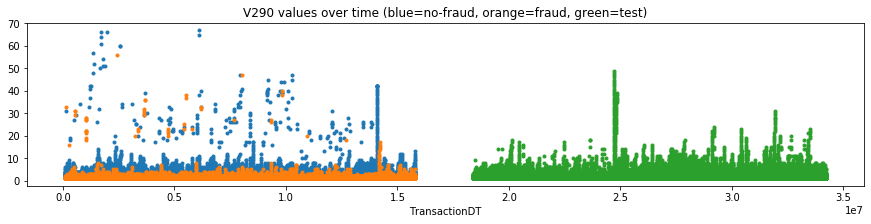

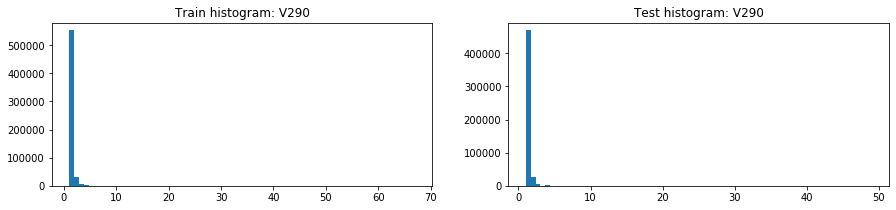

V290          Train   Train fraud  Train Not fraud  \
0           count  590528.000000  20661.000000    569867.000000   
1            mean       1.103011      1.265137         1.097133   
2             std       0.768897      1.433346         0.732916   
3             min       1.000000      1.000000         1.000000   
4             25%       1.000000      1.000000         1.000000   
5             50%       1.000000      1.000000         1.000000   
6             75%       1.000000      1.000000         1.000000   
7             max      67.000000     56.000000        67.000000   
8   unique values      59.000000     39.000000        58.000000   
9            NaNs      12.000000      2.000000        10.000000   
10     NaNs share       0.000000      0.000100         0.000000   

             Test    Test public   Test private  
0   506688.000000  101336.000000  405353.000000  
1        1.119967       1.103418       1.124104  
2        0.674471       0.488160       0.713426  
3        1.000000       1.000000       1.000000  
4        1.000000       1.000000       1.000000  
5        1.000000       1.000000       1.000000  
6        1.000000       1.000000       1.000000  
7       49.000000      18.000000      49.000000  
8       50.000000      19.000000      49.000000  
9        3.000000       3.000000       0.000000  
10       0.000000       0.000000       0.000000

V290  Count in train (desc)  Mean target  Sum target  Count in test
0   1.0                 551866     0.031821       17561       469059.0
1   2.0                  30249     0.076465        2313        27891.0
2   3.0                   4936     0.099068         489         5353.0
3   4.0                   1672     0.090311         151         2004.0
4   5.0                    681     0.083700          57          887.0
5   6.0                    361     0.049861          18          493.0
6   7.0                    206     0.063107          13          269.0
7   8.0                    130     0.038462           5          180.0
8   9.0                     64     0.015625           1          113.0
9  10.0                     38     0.026316           1           97.0

V290  Count in train  Mean target  Sum target (desc)  Count in test
0   1.0          551866     0.031821              17561         469059
1   2.0           30249     0.076465               2313          27891
2   3.0            4936     0.099068                489           5353
3   4.0            1672     0.090311                151           2004
4   5.0             681     0.083700                 57            887
5   6.0             361     0.049861                 18            493
6   7.0             206     0.063107                 13            269
7  22.0              16     0.312500                  5              7
8   8.0             130     0.038462                  5            180
9  27.0              12     0.333333                  4              3

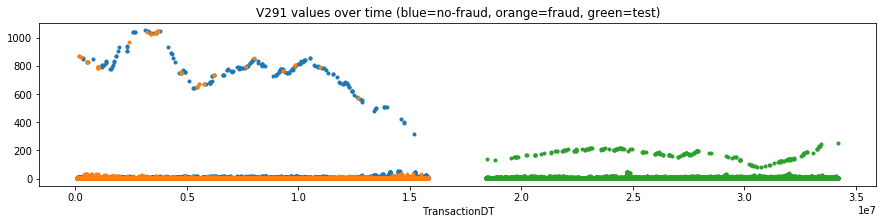

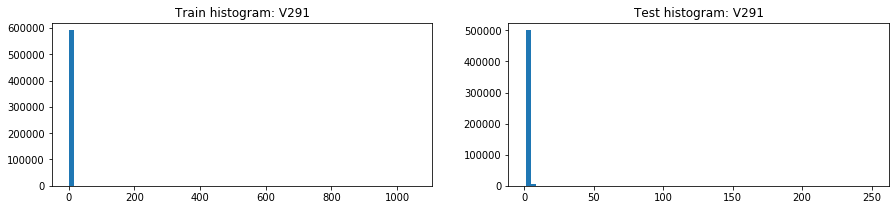

V291          Train  Train fraud  Train Not fraud           Test  \
0           count  590528.000000  20661.00000    569867.000000  506688.000000   
1            mean       1.659811      3.40453         1.596555       1.405097   
2             std      16.252538     38.56033        14.822321       3.652957   
3             min       1.000000      1.00000         1.000000       1.000000   
4             25%       1.000000      1.00000         1.000000       1.000000   
5             50%       1.000000      1.00000         1.000000       1.000000   
6             75%       1.000000      2.00000         1.000000       1.000000   
7             max    1055.000000   1052.00000      1055.000000     250.000000   
8   unique values     220.000000     71.00000       203.000000     146.000000   
9            NaNs      12.000000      2.00000        10.000000       3.000000   
10     NaNs share       0.000000      0.00010         0.000000       0.000000   

      Test public   Test private  
0   101336.000000  405353.000000  
1        1.357494       1.416997  
2        2.570961       3.876454  
3        1.000000       1.000000  
4        1.000000       1.000000  
5        1.000000       1.000000  
6        1.000000       1.000000  
7      198.000000     250.000000  
8       39.000000     138.000000  
9        3.000000       0.000000  
10       0.000000       0.000000

V291  Count in train (desc)  Mean target  Sum target  Count in test
0   1.0                 462929     0.030469       14105       402827.0
1   2.0                  92440     0.043077        3982        71871.0
2   3.0                  21378     0.058518        1251        18206.0
3   4.0                   7251     0.079299         575         6517.0
4   5.0                   2884     0.093273         269         2957.0
5   6.0                   1301     0.090699         118         1468.0
6   7.0                    739     0.123139          91          902.0
7   8.0                    412     0.101942          42          524.0
8   9.0                    258     0.158915          41          342.0
9  10.0                    145     0.179310          26          230.0

V291  Count in train  Mean target  Sum target (desc)  Count in test
0   1.0          462929     0.030469              14105         402827
1   2.0           92440     0.043077               3982          71871
2   3.0           21378     0.058518               1251          18206
3   4.0            7251     0.079299                575           6517
4   5.0            2884     0.093273                269           2957
5   6.0            1301     0.090699                118           1468
6   7.0             739     0.123139                 91            902
7   8.0             412     0.101942                 42            524
8   9.0             258     0.158915                 41            342
9  10.0             145     0.179310                 26            230

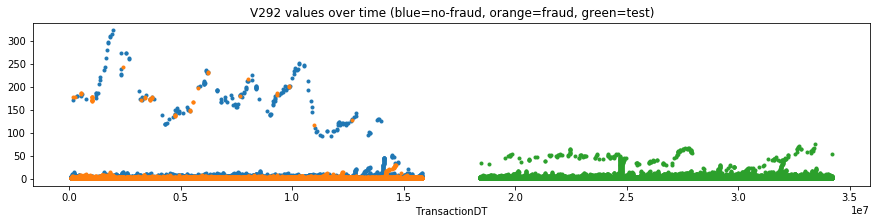

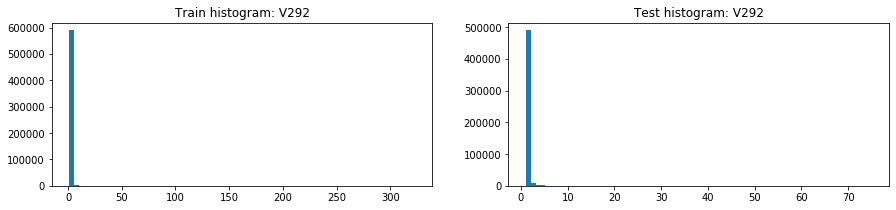

V292          Train   Train fraud  Train Not fraud  \
0           count  590528.000000  20661.000000    569867.000000   
1            mean       1.239916      1.770824         1.220667   
2             std       3.775050      8.173748         3.512115   
3             min       1.000000      1.000000         1.000000   
4             25%       1.000000      1.000000         1.000000   
5             50%       1.000000      1.000000         1.000000   
6             75%       1.000000      1.000000         1.000000   
7             max     323.000000    244.000000       323.000000   
8   unique values     174.000000     62.000000       168.000000   
9            NaNs      12.000000      2.000000        10.000000   
10     NaNs share       0.000000      0.000100         0.000000   

             Test    Test public   Test private  
0   506688.000000  101336.000000  405353.000000  
1        1.211531       1.185206       1.218111  
2        1.229239       0.894880       1.299369  
3        1.000000       1.000000       1.000000  
4        1.000000       1.000000       1.000000  
5        1.000000       1.000000       1.000000  
6        1.000000       1.000000       1.000000  
7       75.000000      53.000000      75.000000  
8       71.000000      35.000000      70.000000  
9        3.000000       3.000000       0.000000  
10       0.000000       0.000000       0.000000

V292  Count in train (desc)  Mean target  Sum target  Count in test
0   1.0                 522151     0.030127       15731       445283.0
1   2.0                  52574     0.062883        3306        44308.0
2   3.0                   9605     0.090578         870         9588.0
3   4.0                   3145     0.123052         387         3499.0
4   5.0                   1221     0.126126         154         1528.0
5   6.0                    596     0.093960          56          788.0
6   7.0                    346     0.101156          35          478.0
7   8.0                    206     0.077670          16          289.0
8   9.0                    145     0.124138          18          184.0
9  10.0                     83     0.072289           6          132.0

V292  Count in train  Mean target  Sum target (desc)  Count in test
0   1.0          522151     0.030127              15731         445283
1   2.0           52574     0.062883               3306          44308
2   3.0            9605     0.090578                870           9588
3   4.0            3145     0.123052                387           3499
4   5.0            1221     0.126126                154           1528
5   6.0             596     0.093960                 56            788
6   7.0             346     0.101156                 35            478
7   9.0             145     0.124138                 18            184
8   8.0             206     0.077670                 16            289
9  10.0              83     0.072289                  6            132

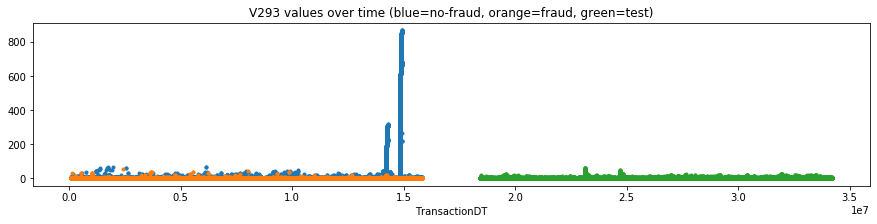

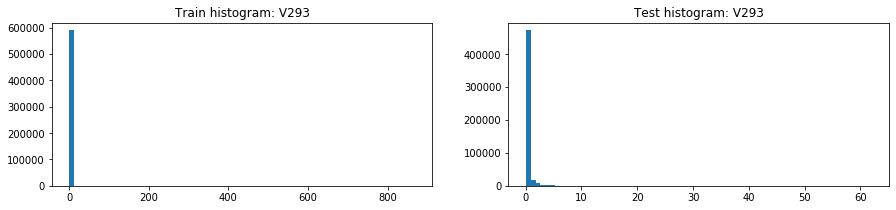

V293          Train   Train fraud  Train Not fraud  \
0           count  590528.000000  20661.000000    569867.000000   
1            mean       0.942599      0.455931         0.960243   
2             std      20.588816      1.713467        20.955974   
3             min       0.000000      0.000000         0.000000   
4             25%       0.000000      0.000000         0.000000   
5             50%       0.000000      0.000000         0.000000   
6             75%       0.000000      0.000000         0.000000   
7             max     869.000000     55.000000       869.000000   
8   unique values     871.000000     39.000000       871.000000   
9            NaNs      12.000000      2.000000        10.000000   
10     NaNs share       0.000000      0.000100         0.000000   

             Test    Test public   Test private  
0   506688.000000  101336.000000  405353.000000  
1        0.156935       0.153766       0.157727  
2        0.925267       0.743585       0.965356  
3        0.000000       0.000000       0.000000  
4        0.000000       0.000000       0.000000  
5        0.000000       0.000000       0.000000  
6        0.000000       0.000000       0.000000  
7       62.000000      25.000000      62.000000  
8       64.000000      27.000000      63.000000  
9        3.000000       3.000000       0.000000  
10       0.000000       0.000000       0.000000

V293  Count in train (desc)  Mean target  Sum target  Count in test
0   0.0                 546442     0.030129       16464       471485.0
1   1.0                  24280     0.098353        2388        18679.0
2   2.0                   8882     0.096487         857         7707.0
3   3.0                   4188     0.095033         398         3620.0
4   4.0                   2103     0.097480         205         1919.0
5   5.0                   1182     0.096447         114         1065.0
6   6.0                    695     0.099281          69          636.0
7   7.0                    423     0.108747          46          433.0
8   8.0                    255     0.094118          24          284.0
9   9.0                    173     0.098266          17          200.0

V293  Count in train  Mean target  Sum target (desc)  Count in test
0   0.0          546442     0.030129              16464         471485
1   1.0           24280     0.098353               2388          18679
2   2.0            8882     0.096487                857           7707
3   3.0            4188     0.095033                398           3620
4   4.0            2103     0.097480                205           1919
5   5.0            1182     0.096447                114           1065
6   6.0             695     0.099281                 69            636
7   7.0             423     0.108747                 46            433
8   8.0             255     0.094118                 24            284
9   9.0             173     0.098266                 17            200

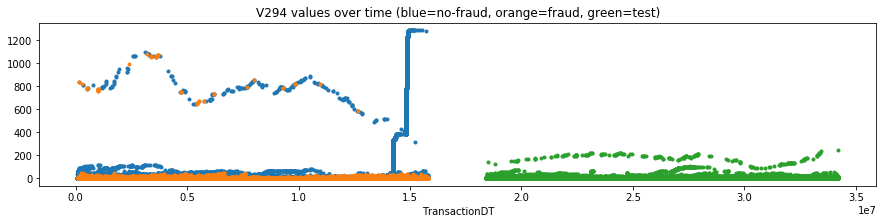

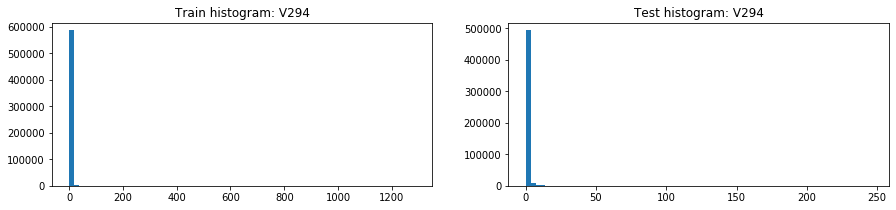

V294          Train   Train fraud  Train Not fraud  \
0           count  590528.000000  20661.000000    569867.000000   
1            mean       2.313863      3.194134         2.281948   
2             std      39.526468     38.656394        39.557319   
3             min       0.000000      0.000000         0.000000   
4             25%       0.000000      0.000000         0.000000   
5             50%       0.000000      0.000000         0.000000   
6             75%       0.000000      1.000000         0.000000   
7             max    1286.000000   1078.000000      1286.000000   
8   unique values    1287.000000     89.000000      1287.000000   
9            NaNs      12.000000      2.000000        10.000000   
10     NaNs share       0.000000      0.000100         0.000000   

             Test    Test public   Test private  
0   506688.000000  101336.000000  405353.000000  
1        0.456154       0.462856       0.454478  
2        4.287307       3.324066       4.495980  
3        0.000000       0.000000       0.000000  
4        0.000000       0.000000       0.000000  
5        0.000000       0.000000       0.000000  
6        0.000000       0.000000       0.000000  
7      246.000000     201.000000     246.000000  
8      191.000000      94.000000     182.000000  
9        3.000000       3.000000       0.000000  
10       0.000000       0.000000       0.000000

V294  Count in train (desc)  Mean target  Sum target  Count in test
0   0.0                 519413     0.027015       14032       452784.0
1   1.0                  29582     0.088736        2625        22555.0
2   2.0                  13719     0.086158        1182        10892.0
3   3.0                   7490     0.089052         667         5957.0
4   4.0                   4576     0.088287         404         3690.0
5   5.0                   2817     0.096557         272         2395.0
6   6.0                   2014     0.091857         185         1649.0
7   7.0                   1519     0.105332         160         1193.0
8   8.0                   1102     0.108893         120          940.0
9   9.0                    837     0.115890          97          723.0

V294  Count in train  Mean target  Sum target (desc)  Count in test
0   0.0          519413     0.027015              14032         452784
1   1.0           29582     0.088736               2625          22555
2   2.0           13719     0.086158               1182          10892
3   3.0            7490     0.089052                667           5957
4   4.0            4576     0.088287                404           3690
5   5.0            2817     0.096557                272           2395
6   6.0            2014     0.091857                185           1649
7   7.0            1519     0.105332                160           1193
8   8.0            1102     0.108893                120            940
9   9.0             837     0.115890                 97            723

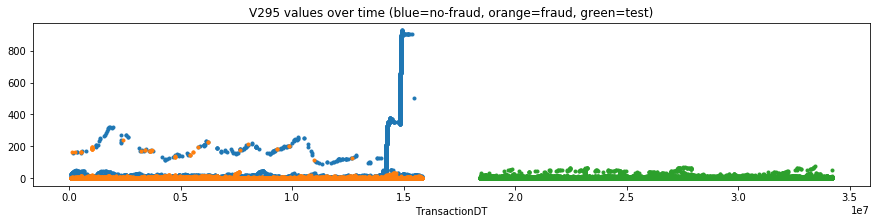

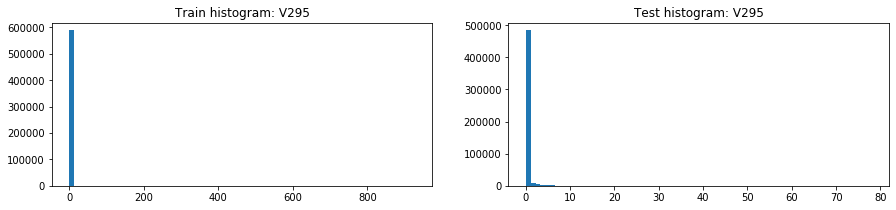

V295          Train   Train fraud  Train Not fraud  \
0           count  590528.000000  20661.000000    569867.000000   
1            mean       1.433424      1.204153         1.441736   
2             std      25.962948      8.524928        26.379483   
3             min       0.000000      0.000000         0.000000   
4             25%       0.000000      0.000000         0.000000   
5             50%       0.000000      0.000000         0.000000   
6             75%       0.000000      1.000000         0.000000   
7             max     928.000000    243.000000       928.000000   
8   unique values     929.000000     84.000000       929.000000   
9            NaNs      12.000000      2.000000        10.000000   
10     NaNs share       0.000000      0.000100         0.000000   

             Test    Test public   Test private  
0   506688.000000  101336.000000  405353.000000  
1        0.258579       0.263579       0.257329  
2        1.624787       1.372440       1.681965  
3        0.000000       0.000000       0.000000  
4        0.000000       0.000000       0.000000  
5        0.000000       0.000000       0.000000  
6        0.000000       0.000000       0.000000  
7       78.000000      56.000000      78.000000  
8       73.000000      50.000000      72.000000  
9        3.000000       3.000000       0.000000  
10       0.000000       0.000000       0.000000

V295  Count in train (desc)  Mean target  Sum target  Count in test
0   0.0                 535074     0.028159       15067       463263.0
1   1.0                  25973     0.097986        2545        19919.0
2   2.0                  11104     0.096001        1066         9178.0
3   3.0                   5694     0.100457         572         4785.0
4   4.0                   3182     0.105908         337         2804.0
5   5.0                   2004     0.112275         225         1781.0
6   6.0                   1365     0.126007         172         1179.0
7   7.0                    959     0.125130         120          812.0
8   8.0                    702     0.136752          96          606.0
9   9.0                    539     0.163265          88          440.0

V295  Count in train  Mean target  Sum target (desc)  Count in test
0   0.0          535074     0.028159              15067         463263
1   1.0           25973     0.097986               2545          19919
2   2.0           11104     0.096001               1066           9178
3   3.0            5694     0.100457                572           4785
4   4.0            3182     0.105908                337           2804
5   5.0            2004     0.112275                225           1781
6   6.0            1365     0.126007                172           1179
7   7.0             959     0.125130                120            812
8   8.0             702     0.136752                 96            606
9   9.0             539     0.163265                 88            440

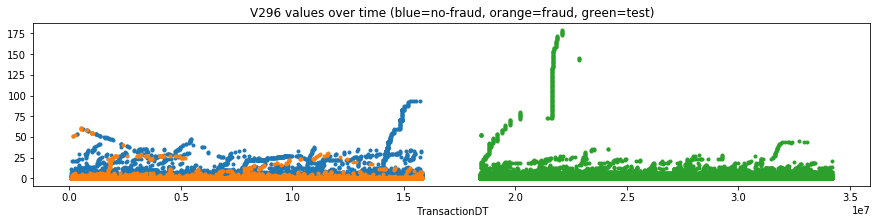

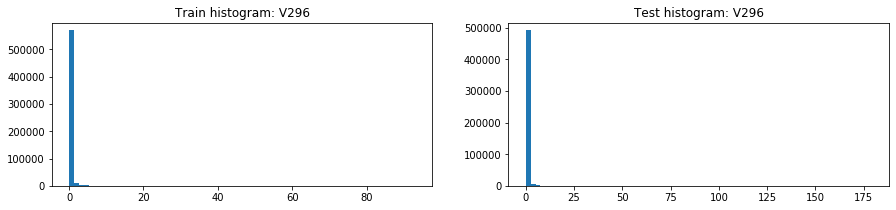

V296          Train   Train fraud  Train Not fraud  \
0           count  589271.000000  20617.000000    568654.000000   
1            mean       0.328917      0.400252         0.326330   
2             std       3.264745      2.481276         3.289619   
3             min       0.000000      0.000000         0.000000   
4             25%       0.000000      0.000000         0.000000   
5             50%       0.000000      0.000000         0.000000   
6             75%       0.000000      0.000000         0.000000   
7             max      93.000000     61.000000        93.000000   
8   unique values      95.000000     40.000000        95.000000   
9            NaNs    1269.000000     46.000000      1223.000000   
10     NaNs share       0.002100      0.002200         0.002100   

             Test    Test public   Test private  
0   500660.000000  100922.000000  399739.000000  
1        0.242122       0.358623       0.212709  
2        2.259073       3.892761       1.600554  
3        0.000000       0.000000       0.000000  
4        0.000000       0.000000       0.000000  
5        0.000000       0.000000       0.000000  
6        0.000000       0.000000       0.000000  
7      179.000000     158.000000     179.000000  
8      181.000000     160.000000      71.000000  
9     6031.000000     417.000000    5614.000000  
10       0.011900       0.004100       0.013800

V296  Count in train (desc)  Mean target  Sum target  Count in test
0    0.0                 536687     0.033737       18106         446958
1    1.0                  32376     0.042902        1389          33325
2    2.0                  10099     0.042083         425          11061
3    3.0                   3586     0.075293         270           4007
4    4.0                   1620     0.063580         103           1806
5 -999.0                   1269     0.036249          46           6031
6    5.0                    893     0.097424          87           1040
7   71.0                    871     0.000000           0              1
8    6.0                    609     0.041051          25            512
9    7.0                    336     0.047619          16            445

V296  Count in train  Mean target  Sum target (desc)  Count in test
0    0.0          536687     0.033737              18106         446958
1    1.0           32376     0.042902               1389          33325
2    2.0           10099     0.042083                425          11061
3    3.0            3586     0.075293                270           4007
4    4.0            1620     0.063580                103           1806
5    5.0             893     0.097424                 87           1040
6 -999.0            1269     0.036249                 46           6031
7   27.0             103     0.300971                 31             11
8    6.0             609     0.041051                 25            512
9    8.0             239     0.092050                 22            308

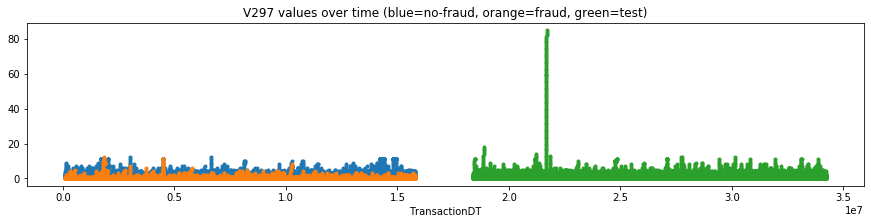

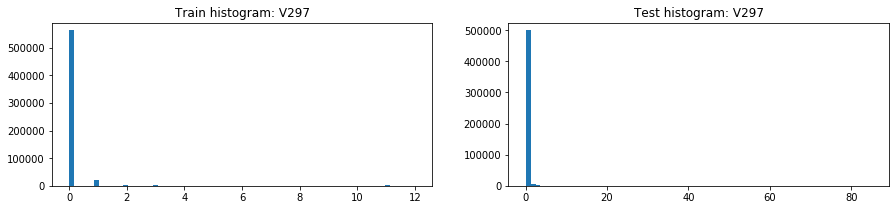

V297          Train   Train fraud  Train Not fraud  \
0           count  590528.000000  20661.000000    569867.000000   
1            mean       0.089034      0.097382         0.088731   
2             std       0.628352      0.504005         0.632400   
3             min       0.000000      0.000000         0.000000   
4             25%       0.000000      0.000000         0.000000   
5             50%       0.000000      0.000000         0.000000   
6             75%       0.000000      0.000000         0.000000   
7             max      12.000000     12.000000        12.000000   
8   unique values      14.000000     14.000000        14.000000   
9            NaNs      12.000000      2.000000        10.000000   
10     NaNs share       0.000000      0.000100         0.000000   

             Test    Test public   Test private  
0   506688.000000  101336.000000  405353.000000  
1        0.090622       0.121753       0.082839  
2        0.775113       1.512742       0.422627  
3        0.000000       0.000000       0.000000  
4        0.000000       0.000000       0.000000  
5        0.000000       0.000000       0.000000  
6        0.000000       0.000000       0.000000  
7       85.000000      85.000000      13.000000  
8       87.000000      87.000000      14.000000  
9        3.000000       3.000000       0.000000  
10       0.000000       0.000000       0.000000

V297  Count in train (desc)  Mean target  Sum target  Count in test
0   0.0                 562740     0.034430       19375         478167
1   1.0                  19398     0.047170         915          20504
2   2.0                   4605     0.049077         226           5068
3   3.0                   1435     0.055052          79           1626
4  11.0                   1299     0.003849           5             40
5   4.0                    519     0.048170          25            597
6   5.0                    240     0.045833          11            276
7   6.0                    123     0.056911           7            128
8   7.0                     74     0.054054           4             75
9   8.0                     41     0.097561           4             51

V297  Count in train  Mean target  Sum target (desc)  Count in test
0   0.0          562740     0.034430              19375         478167
1   1.0           19398     0.047170                915          20504
2   2.0            4605     0.049077                226           5068
3   3.0            1435     0.055052                 79           1626
4   4.0             519     0.048170                 25            597
5   5.0             240     0.045833                 11            276
6   6.0             123     0.056911                  7            128
7   9.0              31     0.193548                  6             23
8  11.0            1299     0.003849                  5             40
9   7.0              74     0.054054                  4             75

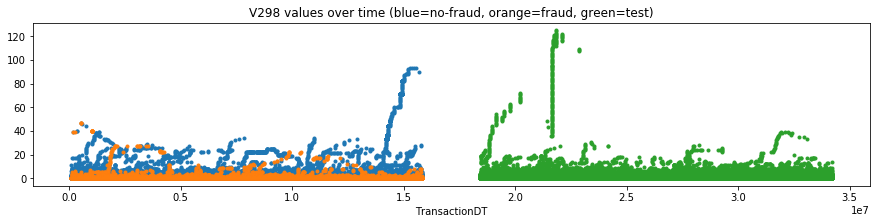

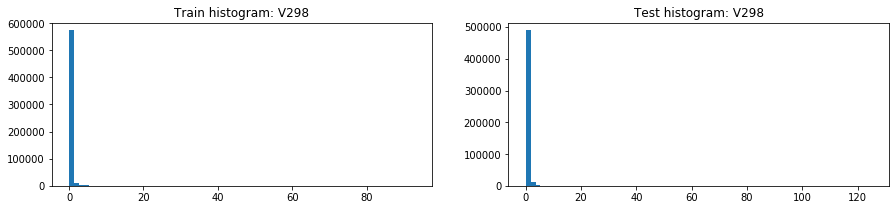

V298          Train   Train fraud  Train Not fraud  \
0           count  590528.000000  20661.000000    569867.000000   
1            mean       0.298829      0.320410         0.298047   
2             std       3.175062      1.848509         3.212883   
3             min       0.000000      0.000000         0.000000   
4             25%       0.000000      0.000000         0.000000   
5             50%       0.000000      0.000000         0.000000   
6             75%       0.000000      0.000000         0.000000   
7             max      93.000000     47.000000        93.000000   
8   unique values      95.000000     32.000000        95.000000   
9            NaNs      12.000000      2.000000        10.000000   
10     NaNs share       0.000000      0.000100         0.000000   

             Test    Test public   Test private  
0   506688.000000  101336.000000  405353.000000  
1        0.201655       0.284223       0.181013  
2        1.680034       2.842414       1.227283  
3        0.000000       0.000000       0.000000  
4        0.000000       0.000000       0.000000  
5        0.000000       0.000000       0.000000  
6        0.000000       0.000000       0.000000  
7      125.000000     121.000000     125.000000  
8      127.000000     123.000000      57.000000  
9        3.000000       3.000000       0.000000  
10       0.000000       0.000000       0.000000

V298  Count in train (desc)  Mean target  Sum target  Count in test
0   0.0                 542892     0.033657       18272         458214
1   1.0                  29739     0.045899        1365          30854
2   2.0                   9068     0.047861         434           9644
3   3.0                   3101     0.073202         227           3566
4   4.0                   1410     0.065957          93           1509
5  71.0                    871     0.000000           0              2
6   5.0                    821     0.097442          80            880
7   6.0                    462     0.043290          20            422
8   7.0                    302     0.046358          14            344
9  33.0                    290     0.000000           0              3

V298  Count in train  Mean target  Sum target (desc)  Count in test
0   0.0          542892     0.033657              18272         458214
1   1.0           29739     0.045899               1365          30854
2   2.0            9068     0.047861                434           9644
3   3.0            3101     0.073202                227           3566
4   4.0            1410     0.065957                 93           1509
5   5.0             821     0.097442                 80            880
6   8.0             192     0.135417                 26            238
7   6.0             462     0.043290                 20            422
8   9.0             124     0.137097                 17            164
9   7.0             302     0.046358                 14            344

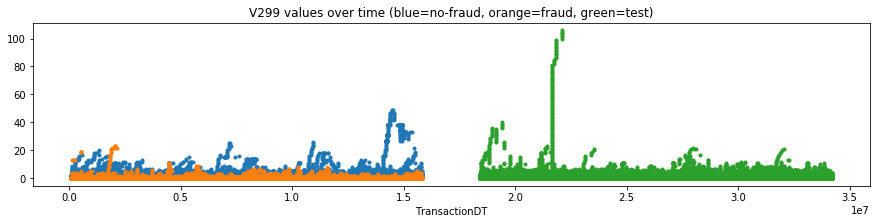

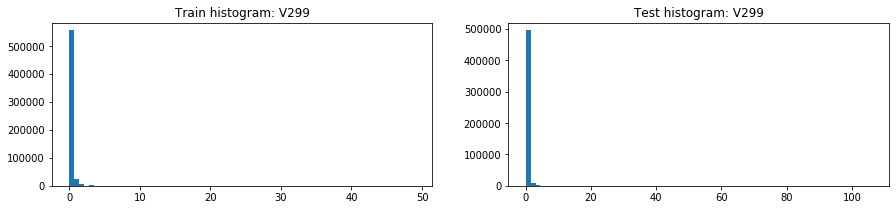

V299          Train   Train fraud  Train Not fraud  \
0           count  590528.000000  20661.000000    569867.000000   
1            mean       0.171655      0.168869         0.171756   
2             std       1.724218      0.881503         1.747153   
3             min       0.000000      0.000000         0.000000   
4             25%       0.000000      0.000000         0.000000   
5             50%       0.000000      0.000000         0.000000   
6             75%       0.000000      0.000000         0.000000   
7             max      49.000000     23.000000        49.000000   
8   unique values      51.000000     25.000000        51.000000   
9            NaNs      12.000000      2.000000        10.000000   
10     NaNs share       0.000000      0.000100         0.000000   

             Test    Test public   Test private  
0   506688.000000  101336.000000  405353.000000  
1        0.127406       0.168331       0.117174  
2        1.090215       1.680789       0.882574  
3        0.000000       0.000000       0.000000  
4        0.000000       0.000000       0.000000  
5        0.000000       0.000000       0.000000  
6        0.000000       0.000000       0.000000  
7      106.000000      85.000000     106.000000  
8      108.000000      87.000000      44.000000  
9        3.000000       3.000000       0.000000  
10       0.000000       0.000000       0.000000

V299  Count in train (desc)  Mean target  Sum target  Count in test
0   0.0                 555629     0.033904       18838         471406
1   1.0                  23124     0.051072        1181          23844
2   2.0                   6255     0.050679         317           6646
3   3.0                   2066     0.075024         155           2316
4   4.0                    858     0.078089          67           1020
5  38.0                    505     0.000000           0              2
6  34.0                    420     0.000000           0              3
7   5.0                    398     0.077889          31            507
8  27.0                    286     0.000000           0              3
9   6.0                    208     0.091346          19            245

V299  Count in train  Mean target  Sum target (desc)  Count in test
0   0.0          555629     0.033904              18838         471406
1   1.0           23124     0.051072               1181          23844
2   2.0            6255     0.050679                317           6646
3   3.0            2066     0.075024                155           2316
4   4.0             858     0.078089                 67           1020
5   5.0             398     0.077889                 31            507
6   6.0             208     0.091346                 19            245
7   7.0             128     0.109375                 14            181
8   8.0              98     0.061224                  6            106
9  22.0               8     0.500000                  4              6

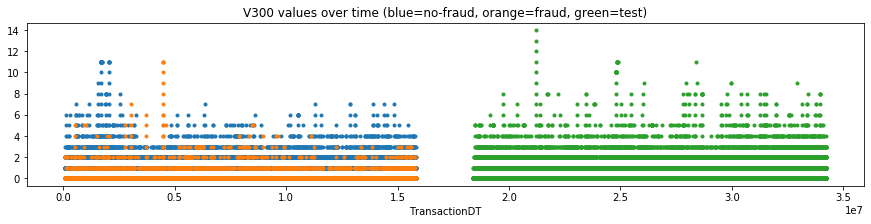

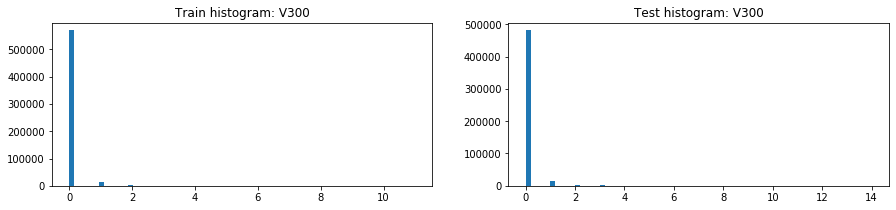

V300          Train   Train fraud  Train Not fraud  \
0           count  589271.000000  20617.000000    568654.000000   
1            mean       0.045507      0.084008         0.044111   
2             std       0.289573      0.420798         0.283579   
3             min       0.000000      0.000000         0.000000   
4             25%       0.000000      0.000000         0.000000   
5             50%       0.000000      0.000000         0.000000   
6             75%       0.000000      0.000000         0.000000   
7             max      11.000000     11.000000        11.000000   
8   unique values      13.000000     13.000000        13.000000   
9            NaNs    1269.000000     46.000000      1223.000000   
10     NaNs share       0.002100      0.002200         0.002100   

             Test    Test public   Test private  
0   500660.000000  100922.000000  399739.000000  
1        0.056685       0.050812       0.058168  
2        0.336923       0.318466       0.341409  
3        0.000000       0.000000       0.000000  
4        0.000000       0.000000       0.000000  
5        0.000000       0.000000       0.000000  
6        0.000000       0.000000       0.000000  
7       14.000000      14.000000      11.000000  
8       16.000000      16.000000      13.000000  
9     6031.000000     417.000000    5614.000000  
10       0.011900       0.004100       0.013800

V300  Count in train (desc)  Mean target  Sum target  Count in test
0    0.0                 569522     0.034108       19425         480736
1    1.0                  15133     0.057755         874          14679
2    2.0                   3183     0.062834         200           3505
3 -999.0                   1269     0.036249          46           6031
4    3.0                    938     0.081023          76           1059
5    4.0                    285     0.063158          18            342
6    5.0                    103     0.116505          12            179
7    6.0                     44     0.090909           4             47
8   11.0                     29     0.103448           3              9
9    7.0                     17     0.117647           2             35

V300  Count in train  Mean target  Sum target (desc)  Count in test
0    0.0          569522     0.034108              19425         480736
1    1.0           15133     0.057755                874          14679
2    2.0            3183     0.062834                200           3505
3    3.0             938     0.081023                 76           1059
4 -999.0            1269     0.036249                 46           6031
5    4.0             285     0.063158                 18            342
6    5.0             103     0.116505                 12            179
7    6.0              44     0.090909                  4             47
8   11.0              29     0.103448                  3              9
9    7.0              17     0.117647                  2             35

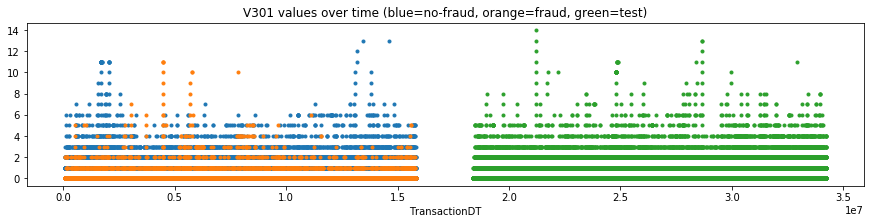

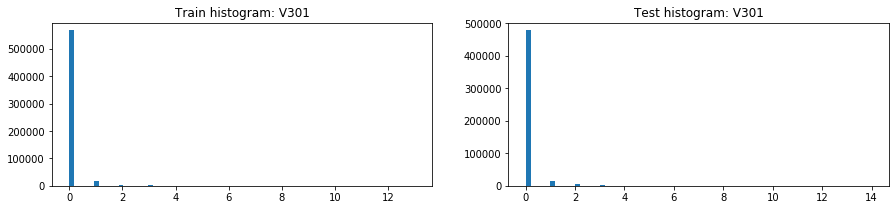

V301          Train   Train fraud  Train Not fraud  \
0           count  589271.000000  20617.000000    568654.000000   
1            mean       0.052002      0.105641         0.050057   
2             std       0.318310      0.494239         0.309888   
3             min       0.000000      0.000000         0.000000   
4             25%       0.000000      0.000000         0.000000   
5             50%       0.000000      0.000000         0.000000   
6             75%       0.000000      0.000000         0.000000   
7             max      13.000000     11.000000        13.000000   
8   unique values      15.000000     13.000000        15.000000   
9            NaNs    1269.000000     46.000000      1223.000000   
10     NaNs share       0.002100      0.002200         0.002100   

             Test    Test public   Test private  
0   500660.000000  100922.000000  399739.000000  
1        0.065931       0.059472       0.067562  
2        0.370363       0.346818       0.376057  
3        0.000000       0.000000       0.000000  
4        0.000000       0.000000       0.000000  
5        0.000000       0.000000       0.000000  
6        0.000000       0.000000       0.000000  
7       14.000000      14.000000      13.000000  
8       16.000000      16.000000      15.000000  
9     6031.000000     417.000000    5614.000000  
10       0.011900       0.004100       0.013800

V301  Count in train (desc)  Mean target  Sum target  Count in test
0    0.0                 567409     0.033801       19179         478263
1    1.0                  16292     0.064019        1043          15934
2    2.0                   3778     0.061673         233           4209
3 -999.0                   1269     0.036249          46           6031
4    3.0                   1141     0.073620          84           1313
5    4.0                    324     0.117284          38            518
6    5.0                    155     0.122581          19            218
7    6.0                     91     0.076923           7             86
8   11.0                     30     0.100000           3             11
9    7.0                     20     0.150000           3             40

V301  Count in train  Mean target  Sum target (desc)  Count in test
0    0.0          567409     0.033801              19179         478263
1    1.0           16292     0.064019               1043          15934
2    2.0            3778     0.061673                233           4209
3    3.0            1141     0.073620                 84           1313
4 -999.0            1269     0.036249                 46           6031
5    4.0             324     0.117284                 38            518
6    5.0             155     0.122581                 19            218
7    6.0              91     0.076923                  7             86
8   10.0               8     0.500000                  4             29
9   11.0              30     0.100000                  3             11

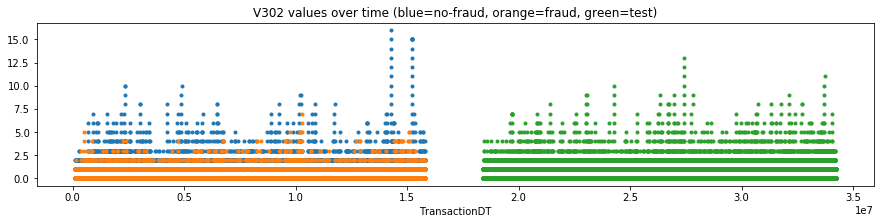

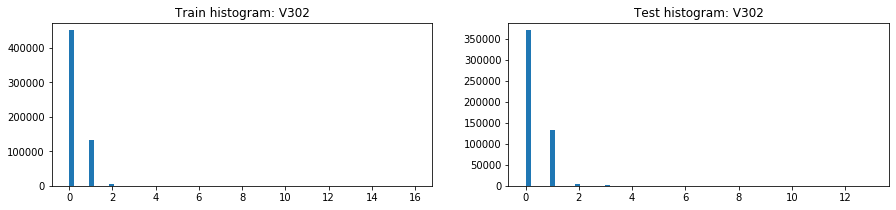

V302          Train   Train fraud  Train Not fraud  \
0           count  590528.000000  20661.000000    569867.000000   
1            mean       0.251761      0.588113         0.239566   
2             std       0.481889      0.604951         0.472353   
3             min       0.000000      0.000000         0.000000   
4             25%       0.000000      0.000000         0.000000   
5             50%       0.000000      1.000000         0.000000   
6             75%       0.000000      1.000000         0.000000   
7             max      16.000000      7.000000        16.000000   
8   unique values      18.000000      9.000000        18.000000   
9            NaNs      12.000000      2.000000        10.000000   
10     NaNs share       0.000000      0.000100         0.000000   

             Test    Test public   Test private  
0   506688.000000  101336.000000  405353.000000  
1        0.286762       0.192271       0.310384  
2        0.502396       0.443210       0.513423  
3        0.000000       0.000000       0.000000  
4        0.000000       0.000000       0.000000  
5        0.000000       0.000000       0.000000  
6        1.000000       0.000000       1.000000  
7       13.000000       8.000000      13.000000  
8       15.000000      10.000000      14.000000  
9        3.000000       3.000000       0.000000  
10       0.000000       0.000000       0.000000

V302  Count in train (desc)  Mean target  Sum target  Count in test
0    0.0                 450191     0.021164        9528       369321.0
1    1.0                 134072     0.076899       10310       131660.0
2    2.0                   5155     0.131329         677         4457.0
3    3.0                    683     0.159590         109          769.0
4    4.0                    219     0.127854          28          241.0
5    5.0                     97     0.072165           7          115.0
6    6.0                     47     0.021277           1           60.0
7    7.0                     23     0.043478           1           31.0
8    8.0                     14     0.000000           0           18.0
9 -999.0                     12     0.166667           2            3.0

V302  Count in train  Mean target  Sum target (desc)  Count in test
0    1.0          134072     0.076899              10310         131660
1    0.0          450191     0.021164               9528         369321
2    2.0            5155     0.131329                677           4457
3    3.0             683     0.159590                109            769
4    4.0             219     0.127854                 28            241
5    5.0              97     0.072165                  7            115
6 -999.0              12     0.166667                  2              3
7    7.0              23     0.043478                  1             31
8    6.0              47     0.021277                  1             60
9    8.0              14     0.000000                  0             18

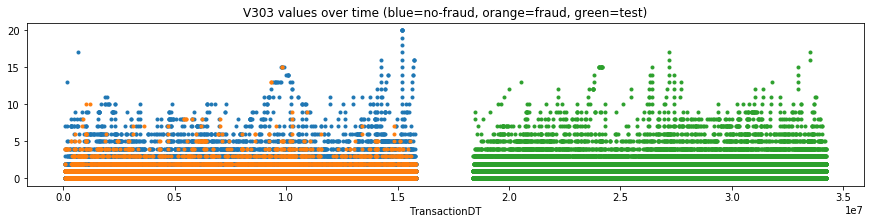

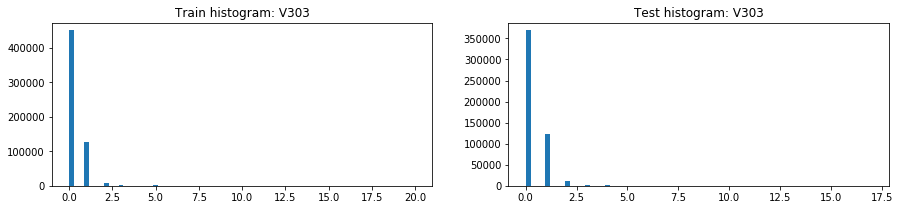

V303          Train   Train fraud  Train Not fraud  \
0           count  590528.000000  20661.000000    569867.000000   
1            mean       0.283140      0.690189         0.268382   
2             std       0.623608      0.846492         0.608920   
3             min       0.000000      0.000000         0.000000   
4             25%       0.000000      0.000000         0.000000   
5             50%       0.000000      1.000000         0.000000   
6             75%       0.000000      1.000000         0.000000   
7             max      20.000000     15.000000        20.000000   
8   unique values      22.000000     14.000000        22.000000   
9            NaNs      12.000000      2.000000        10.000000   
10     NaNs share       0.000000      0.000100         0.000000   

             Test    Test public   Test private  
0   506688.000000  101336.000000  405353.000000  
1        0.321849       0.222192       0.346762  
2        0.639583       0.572844       0.652834  
3        0.000000       0.000000       0.000000  
4        0.000000       0.000000       0.000000  
5        0.000000       0.000000       0.000000  
6        1.000000       0.000000       1.000000  
7       17.000000      13.000000      17.000000  
8       19.000000      15.000000      18.000000  
9        3.000000       3.000000       0.000000  
10       0.000000       0.000000       0.000000

V303  Count in train (desc)  Mean target  Sum target  Count in test
0   0.0                 449499     0.020990        9435       368773.0
1   1.0                 126757     0.073195        9278       122648.0
2   2.0                   9113     0.149347        1361        10537.0
3   3.0                   2332     0.138937         324         2607.0
4   5.0                   1375     0.046545          64          455.0
5   4.0                    834     0.179856         150          970.0
6   6.0                    216     0.101852          22          251.0
7   7.0                    123     0.081301          10          171.0
8   8.0                     86     0.104651           9          102.0
9   9.0                     68     0.029412           2           77.0

V303  Count in train  Mean target  Sum target (desc)  Count in test
0   0.0          449499     0.020990               9435         368773
1   1.0          126757     0.073195               9278         122648
2   2.0            9113     0.149347               1361          10537
3   3.0            2332     0.138937                324           2607
4   4.0             834     0.179856                150            970
5   5.0            1375     0.046545                 64            455
6   6.0             216     0.101852                 22            251
7   7.0             123     0.081301                 10            171
8   8.0              86     0.104651                  9            102
9   9.0              68     0.029412                  2             77

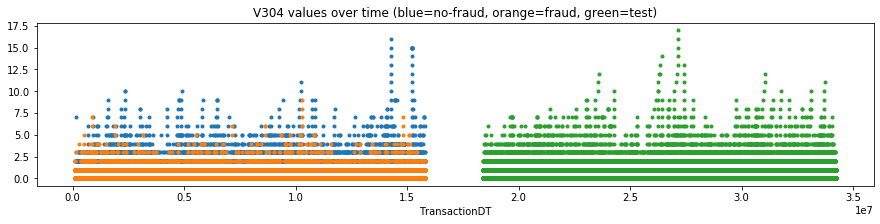

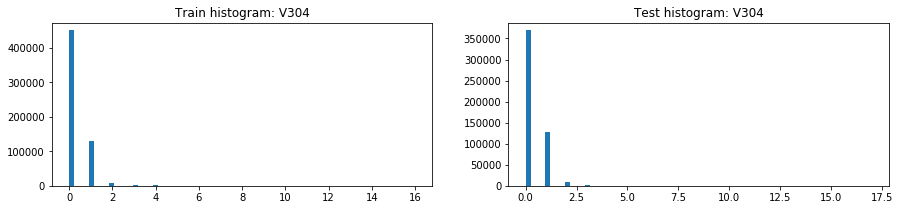

V304          Train   Train fraud  Train Not fraud  \
0           count  590528.000000  20661.000000    569867.000000   
1            mean       0.264208      0.629011         0.250981   
2             std       0.528238      0.686876         0.516766   
3             min       0.000000      0.000000         0.000000   
4             25%       0.000000      0.000000         0.000000   
5             50%       0.000000      1.000000         0.000000   
6             75%       0.000000      1.000000         0.000000   
7             max      16.000000      9.000000        16.000000   
8   unique values      18.000000     11.000000        18.000000   
9            NaNs      12.000000      2.000000        10.000000   
10     NaNs share       0.000000      0.000100         0.000000   

             Test    Test public   Test private  
0   506688.000000  101336.000000  405353.000000  
1        0.301547       0.205583       0.325536  
2        0.555264       0.495821       0.566621  
3        0.000000       0.000000       0.000000  
4        0.000000       0.000000       0.000000  
5        0.000000       0.000000       0.000000  
6        1.000000       0.000000       1.000000  
7       17.000000       8.000000      17.000000  
8       19.000000      10.000000      18.000000  
9        3.000000       3.000000       0.000000  
10       0.000000       0.000000       0.000000

V304  Count in train (desc)  Mean target  Sum target  Count in test
0   0.0                 449830     0.021070        9478         369035
1   1.0                 130542     0.075079        9801         127251
2   2.0                   7212     0.150998        1089           7846
3   3.0                   1601     0.127420         204           1521
4   4.0                    962     0.062370          60            528
5   5.0                    189     0.089947          17            236
6   6.0                     84     0.083333           7            119
7   7.0                     40     0.075000           3             69
8   9.0                     24     0.041667           1             18
9   8.0                     21     0.047619           1             35

V304  Count in train  Mean target  Sum target (desc)  Count in test
0    1.0          130542     0.075079               9801         127251
1    0.0          449830     0.021070               9478         369035
2    2.0            7212     0.150998               1089           7846
3    3.0            1601     0.127420                204           1521
4    4.0             962     0.062370                 60            528
5    5.0             189     0.089947                 17            236
6    6.0              84     0.083333                  7            119
7    7.0              40     0.075000                  3             69
8 -999.0              12     0.166667                  2              3
9    8.0              21     0.047619                  1             35

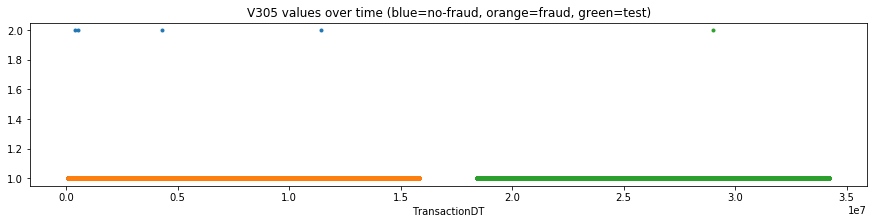

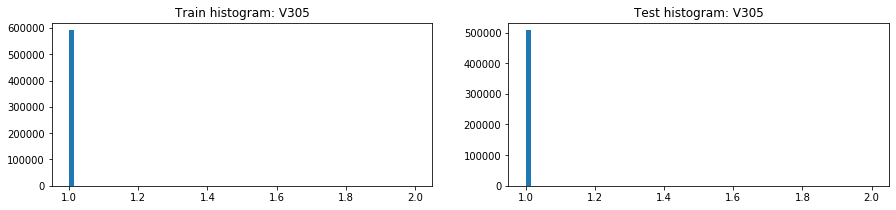

V305          Train  Train fraud  Train Not fraud           Test  \
0           count  590528.000000   20661.0000    569867.000000  506688.000000   
1            mean       1.000007       1.0000         1.000007       1.000002   
2             std       0.002603       0.0000         0.002649       0.001405   
3             min       1.000000       1.0000         1.000000       1.000000   
4             25%       1.000000       1.0000         1.000000       1.000000   
5             50%       1.000000       1.0000         1.000000       1.000000   
6             75%       1.000000       1.0000         1.000000       1.000000   
7             max       2.000000       1.0000         2.000000       2.000000   
8   unique values       3.000000       2.0000         3.000000       3.000000   
9            NaNs      12.000000       2.0000        10.000000       3.000000   
10     NaNs share       0.000000       0.0001         0.000000       0.000000   

    Test public   Test private  
0      101336.0  405353.000000  
1           1.0       1.000002  
2           0.0       0.001571  
3           1.0       1.000000  
4           1.0       1.000000  
5           1.0       1.000000  
6           1.0       1.000000  
7           1.0       2.000000  
8           2.0       2.000000  
9           3.0       0.000000  
10          0.0       0.000000

V305  Count in train (desc)  Mean target  Sum target  Count in test
0    1.0                 590524     0.034988       20661         506687
1 -999.0                     12     0.166667           2              3
2    2.0                      4     0.000000           0              1

V305  Count in train  Mean target  Sum target (desc)  Count in test
0    1.0          590524     0.034988              20661         506687
1 -999.0              12     0.166667                  2              3
2    2.0               4     0.000000                  0              1

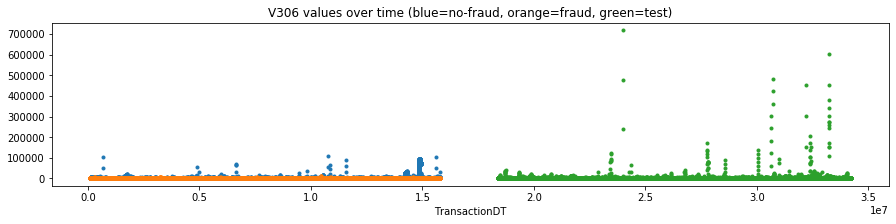

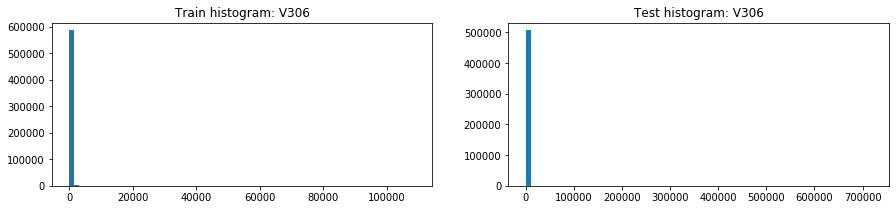

V306          Train   Train fraud  Train Not fraud  \
0           count  590528.000000  20661.000000    569867.000000   
1            mean     139.748713    116.765349       140.581994   
2             std    2348.849634    402.869710      2389.815422   
3             min       0.000000      0.000000         0.000000   
4             25%       0.000000      0.000000         0.000000   
5             50%       0.000000      0.000000         0.000000   
6             75%       0.000000     54.225399         0.000000   
7             max  108800.000000  11848.000000    108800.000000   
8   unique values   16211.000000   2419.000000     15414.000000   
9            NaNs      12.000000      2.000000        10.000000   
10     NaNs share       0.000000      0.000100         0.000000   

             Test    Test public   Test private  
0   506688.000000  101336.000000  405353.000000  
1       83.783107      67.174093      87.935061  
2     2706.035763     552.762877    3012.766523  
3        0.000000       0.000000       0.000000  
4        0.000000       0.000000       0.000000  
5        0.000000       0.000000       0.000000  
6        0.000000       0.000000       0.000000  
7   718740.000000   39840.000000  718740.000000  
8    13261.000000    4189.000000   11413.000000  
9        3.000000       3.000000       0.000000  
10       0.000000       0.000000       0.000000

V306  Count in train (desc)  Mean target  Sum target  Count in test
0    0.000000                 492169     0.028626       14089       418709.0
1  117.000000                   3838     0.042470         163         3424.0
2   59.000000                   3768     0.035563         134         3474.0
3  100.000000                   2194     0.053783         118         1531.0
4   49.000000                   1996     0.054108         108         1852.0
5  226.000000                   1664     0.058293          97         1559.0
6  107.949997                   1595     0.030721          49         1364.0
7   57.950001                   1568     0.006378          10         1299.0
8   50.000000                   1467     0.047716          70          922.0
9  200.000000                   1370     0.073723         101         1283.0

V306  Count in train  Mean target  Sum target (desc)  Count in test
0    0.0          492169     0.028626              14089         418709
1  117.0            3838     0.042470                163           3424
2   59.0            3768     0.035563                134           3474
3  100.0            2194     0.053783                118           1531
4   49.0            1996     0.054108                108           1852
5  150.0            1143     0.091864                105            765
6  200.0            1370     0.073723                101           1283
7  226.0            1664     0.058293                 97           1559
8  300.0             912     0.098684                 90            769
9   50.0            1467     0.047716                 70            922

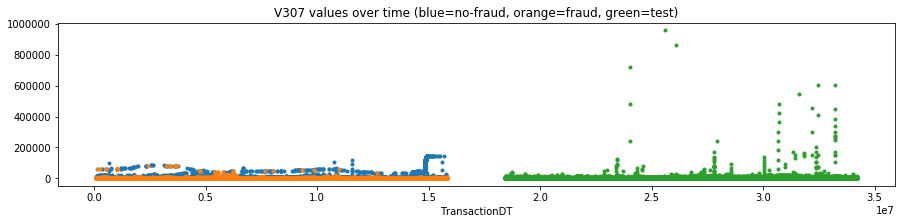

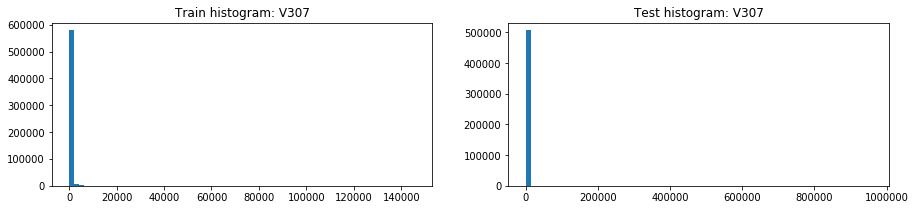

V307          Train   Train fraud  Train Not fraud  \
0           count  590528.000000  20661.000000    569867.000000   
1            mean     408.682375    545.881593       403.708103   
2             std    4391.992977   3097.849804      4431.742064   
3             min       0.000000      0.000000         0.000000   
4             25%       0.000000      0.000000         0.000000   
5             50%       0.000000     12.809000         0.000000   
6             75%     151.380680    273.850006       150.000000   
7             max  145765.000000  83258.367188    145765.000000   
8   unique values   37368.000000   5121.000000     35731.000000   
9            NaNs      12.000000      2.000000        10.000000   
10     NaNs share       0.000000      0.000100         0.000000   

             Test    Test public   Test private  
0   506688.000000  101336.000000  405353.000000  
1      259.371829     242.870752     263.496612  
2     3643.584651     861.480557    4050.792690  
3        0.000000       0.000000       0.000000  
4        0.000000       0.000000       0.000000  
5        0.000000      15.000000       0.000000  
6      156.000000     177.000000     150.000000  
7   958320.000000   39840.000000  958320.000000  
8    29593.000000   10859.000000   25696.000000  
9        3.000000       3.000000       0.000000  
10       0.000000       0.000000       0.000000

V307  Count in train (desc)  Mean target  Sum target  Count in test
0    0.000000                 316650     0.032023       10140       267260.0
1  107.949997                   6360     0.007862          50         5410.0
2   57.950001                   5672     0.004231          24         4930.0
3   59.000000                   5418     0.014766          80         5037.0
4  117.000000                   5247     0.023442         123         4901.0
5  100.000000                   3307     0.037194         123         1954.0
6   49.000000                   2687     0.026796          72         2358.0
7   50.000000                   2291     0.031864          73         1248.0
8  226.000000                   2280     0.032456          74         2144.0
9   47.950001                   2248     0.003559           8         1926.0

V307  Count in train  Mean target  Sum target (desc)  Count in test
0    0.0          316650     0.032023              10140         267260
1  117.0            5247     0.023442                123           4901
2  100.0            3307     0.037194                123           1954
3  150.0            1586     0.073770                117            991
4  300.0            1183     0.089603                106            886
5  200.0            2005     0.052868                106           1608
6   59.0            5418     0.014766                 80           5037
7  226.0            2280     0.032456                 74           2144
8   50.0            2291     0.031864                 73           1248
9   49.0            2687     0.026796                 72           2358

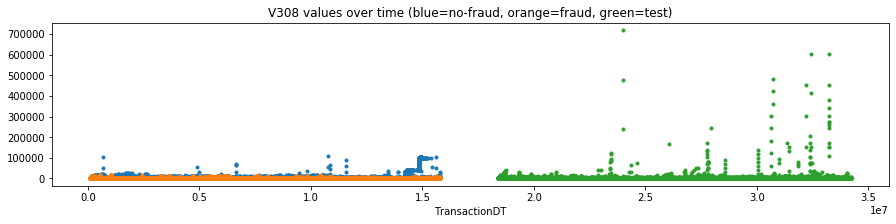

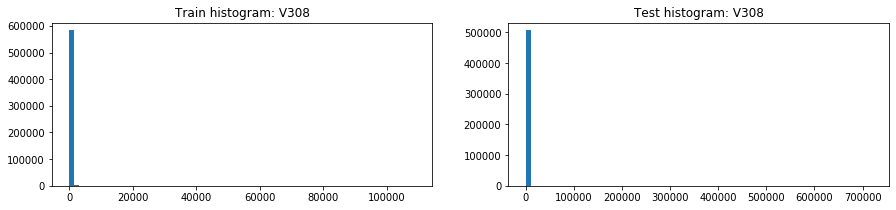

V308          Train   Train fraud  Train Not fraud  \
0           count  590528.000000  20661.000000    569867.000000   
1            mean     230.413180    282.044788       228.541233   
2             std    3021.924247   1032.666247      3069.911131   
3             min       0.000000      0.000000         0.000000   
4             25%       0.000000      0.000000         0.000000   
5             50%       0.000000      0.000000         0.000000   
6             75%      35.970001    156.774002        34.000000   
7             max  108800.000000  18123.957031    108800.000000   
8   unique values   23065.000000   3839.000000     21832.000000   
9            NaNs      12.000000      2.000000        10.000000   
10     NaNs share       0.000000      0.000100         0.000000   

             Test    Test public   Test private  
0   506688.000000  101336.000000  405353.000000  
1      136.949416     119.572212     141.293283  
2     2976.740478     647.127217    3312.307298  
3        0.000000       0.000000       0.000000  
4        0.000000       0.000000       0.000000  
5        0.000000       0.000000       0.000000  
6       41.314602      52.950001      39.000000  
7   718740.000000   39840.000000  718740.000000  
8    18942.000000    6380.000000   16363.000000  
9        3.000000       3.000000       0.000000  
10       0.000000       0.000000       0.000000

V308  Count in train (desc)  Mean target  Sum target  Count in test
0    0.000000                 422464     0.027337       11549       356312.0
1   59.000000                   5724     0.019392         111         5389.0
2  117.000000                   5723     0.026035         149         5217.0
3   57.950001                   3809     0.006563          25         3062.0
4  107.949997                   3232     0.017327          56         2664.0
5   49.000000                   2812     0.028450          80         2680.0
6  100.000000                   2555     0.047750         122         1745.0
7  226.000000                   2376     0.037458          89         2320.0
8   39.000000                   1993     0.023081          46         1759.0
9   50.000000                   1864     0.041309          77         1162.0

V308  Count in train  Mean target  Sum target (desc)  Count in test
0    0.0          422464     0.027337              11549         356312
1  117.0            5723     0.026035                149           5217
2  100.0            2555     0.047750                122           1745
3  150.0            1324     0.091390                121            876
4   59.0            5724     0.019392                111           5389
5  200.0            1589     0.066709                106           1430
6  300.0            1026     0.099415                102            825
7  226.0            2376     0.037458                 89           2320
8   49.0            2812     0.028450                 80           2680
9   50.0            1864     0.041309                 77           1162

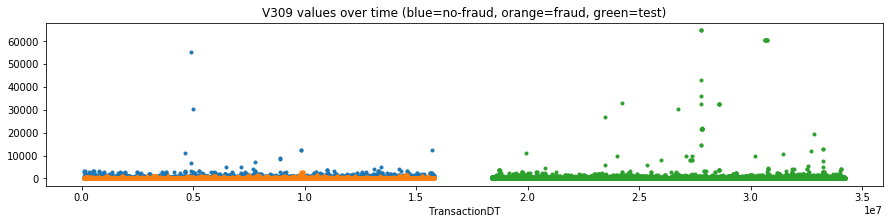

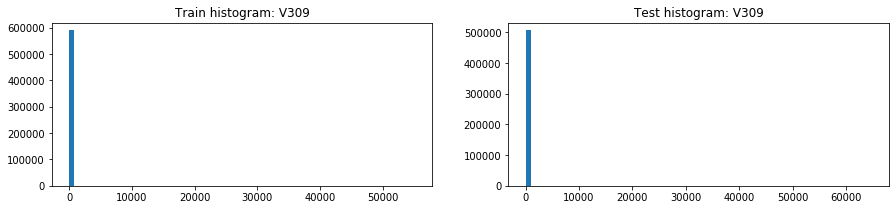

V309          Train   Train fraud  Train Not fraud  \
0           count  590528.000000  20661.000000    569867.000000   
1            mean      10.995986     23.363125        10.547606   
2             std     116.254277    104.910410       116.620286   
3             min       0.000000      0.000000         0.000000   
4             25%       0.000000      0.000000         0.000000   
5             50%       0.000000      0.000000         0.000000   
6             75%       0.000000      0.000000         0.000000   
7             max   55125.000000   2793.000000     55125.000000   
8   unique values    4237.000000    572.000000      4082.000000   
9            NaNs      12.000000      2.000000        10.000000   
10     NaNs share       0.000000      0.000100         0.000000   

             Test    Test public   Test private  
0   506688.000000  101336.000000  405353.000000  
1       12.838856      10.592444      13.400415  
2      337.427648      82.167110     375.008726  
3        0.000000       0.000000       0.000000  
4        0.000000       0.000000       0.000000  
5        0.000000       0.000000       0.000000  
6        0.000000       0.000000       0.000000  
7    64800.000000   11000.000000   64800.000000  
8     3205.000000    1070.000000    2862.000000  
9        3.000000       3.000000       0.000000  
10       0.000000       0.000000       0.000000

V309  Count in train (desc)  Mean target  Sum target  Count in test
0    0.000000                 545552     0.033047       18029       468718.0
1   59.000000                   3160     0.042405         134         2675.0
2  117.000000                   2903     0.065794         191         2571.0
3   49.000000                   1625     0.054769          89         1502.0
4   39.000000                   1187     0.045493          54          920.0
5  226.000000                   1133     0.088261         100         1023.0
6   29.000000                   1016     0.058071          59          756.0
7  107.949997                    957     0.050157          48          776.0
8   57.950001                    954     0.011530          11          753.0
9   77.000000                    866     0.078522          68          753.0

V309  Count in train  Mean target  Sum target (desc)  Count in test
0    0.0          545552     0.033047              18029         468718
1  117.0            2903     0.065794                191           2571
2   59.0            3160     0.042405                134           2675
3  226.0            1133     0.088261                100           1023
4   49.0            1625     0.054769                 89           1502
5   77.0             866     0.078522                 68            753
6  335.0             566     0.116608                 66            495
7   29.0            1016     0.058071                 59            756
8   39.0            1187     0.045493                 54            920
9  171.0             783     0.062580                 49            709

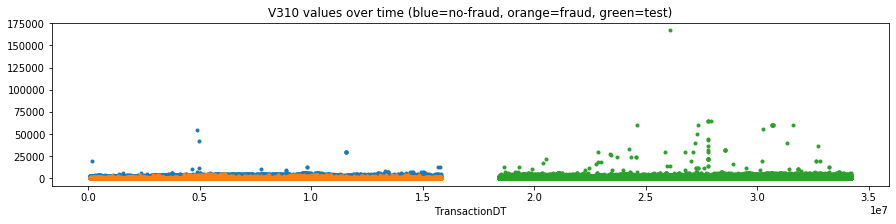

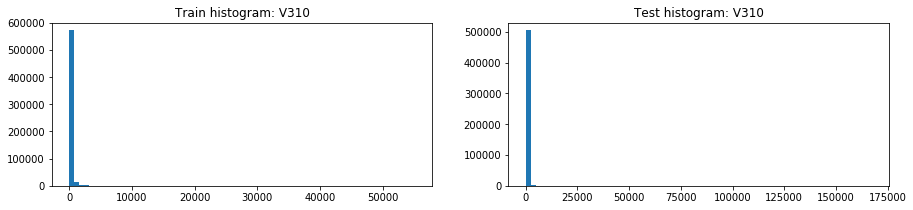

V310          Train   Train fraud  Train Not fraud  \
0           count  590528.000000  20661.000000    569867.000000   
1            mean     118.195658    138.719226       117.451559   
2             std     352.983093    402.308240       351.042468   
3             min       0.000000      0.000000         0.000000   
4             25%       0.000000      0.000000         0.000000   
5             50%       0.000000      0.000000         0.000000   
6             75%     107.949997     97.000000       107.949997   
7             max   55125.000000   5216.000000     55125.000000   
8   unique values   19137.000000   1747.000000     18850.000000   
9            NaNs      12.000000      2.000000        10.000000   
10     NaNs share       0.000000      0.000100         0.000000   

             Test    Test public   Test private  
0   506688.000000  101336.000000  405353.000000  
1      127.198552     129.273296     126.679810  
2      606.911563     365.256465     653.506621  
3        0.000000       0.000000       0.000000  
4        0.000000       0.000000       0.000000  
5        0.000000       0.000000       0.000000  
6      106.000000     115.900002      99.900002  
7   167200.000000   22400.000000  167200.000000  
8    15385.000000    6243.000000   13753.000000  
9        3.000000       3.000000       0.000000  
10       0.000000       0.000000       0.000000

V310  Count in train (desc)  Mean target  Sum target  Count in test
0    0.000000                 354815     0.038147       13535       303975.0
1  107.949997                   6520     0.008589          56         5534.0
2   59.000000                   6245     0.020176         126         5612.0
3  117.000000                   5804     0.041178         239         5654.0
4   57.950001                   5757     0.005385          31         5073.0
5   49.000000                   3083     0.037301         115         2738.0
6  226.000000                   2453     0.053812         132         2365.0
7   47.950001                   2293     0.003489           8         1948.0
8   39.000000                   2008     0.021912          44         1740.0
9   35.950001                   1992     0.005020          10         1826.0

V310  Count in train  Mean target  Sum target (desc)  Count in test
0    0.0          354815     0.038147              13535         303975
1  117.0            5804     0.041178                239           5654
2  226.0            2453     0.053812                132           2365
3   59.0            6245     0.020176                126           5612
4   49.0            3083     0.037301                115           2738
5  171.0            1508     0.052387                 79           1383
6  445.0             451     0.155211                 70            463
7  335.0            1102     0.060799                 67           1096
8   98.0             729     0.085048                 62            662
9   77.0            1389     0.042477                 59           1212

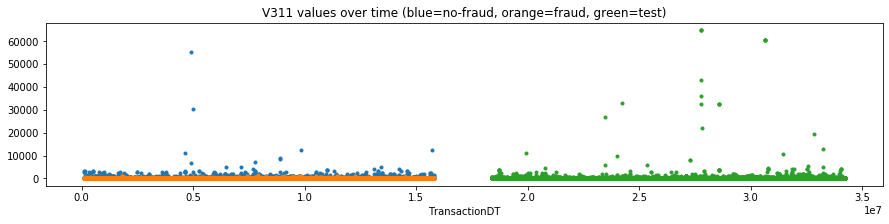

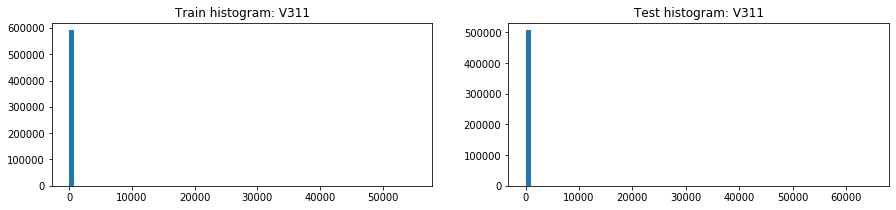

V311          Train   Train fraud  Train Not fraud  \
0           count  590528.000000  20661.000000    569867.000000   
1            mean       4.202175      4.901211         4.176831   
2             std     102.374938     42.340216       103.901884   
3             min       0.000000      0.000000         0.000000   
4             25%       0.000000      0.000000         0.000000   
5             50%       0.000000      0.000000         0.000000   
6             75%       0.000000      0.000000         0.000000   
7             max   55125.000000   1448.500000     55125.000000   
8   unique values    3099.000000    308.000000      3006.000000   
9            NaNs      12.000000      2.000000        10.000000   
10     NaNs share       0.000000      0.000100         0.000000   

             Test    Test public   Test private  
0   506688.000000  101336.000000  405353.000000  
1        5.153783       3.407071       5.590439  
2      278.305451      60.175142     309.694436  
3        0.000000       0.000000       0.000000  
4        0.000000       0.000000       0.000000  
5        0.000000       0.000000       0.000000  
6        0.000000       0.000000       0.000000  
7    64800.000000   11000.000000   64800.000000  
8     2313.000000     677.000000    2063.000000  
9        3.000000       3.000000       0.000000  
10       0.000000       0.000000       0.000000

V311  Count in train (desc)  Mean target  Sum target  Count in test
0    0.000000                 573290     0.034848       19978       492506.0
1   59.000000                    823     0.018226          15          661.0
2  117.000000                    805     0.024845          20          611.0
3  107.949997                    611     0.040917          25          432.0
4   57.950001                    585     0.017094          10          487.0
5   49.000000                    394     0.035533          14          301.0
6   39.000000                    297     0.037037          11          184.0
7   29.000000                    286     0.080420          23          198.0
8  100.000000                    283     0.038869          11          223.0
9  226.000000                    271     0.066421          18          227.0

V311  Count in train  Mean target  Sum target (desc)  Count in test
0    0.000000          573290     0.034848              19978         492506
1  107.949997             611     0.040917                 25            432
2   29.000000             286     0.080420                 23            198
3  117.000000             805     0.024845                 20            611
4  226.000000             271     0.066421                 18            227
5  150.000000             135     0.125926                 17             86
6   59.000000             823     0.018226                 15            661
7  311.950012              90     0.155556                 14             60
8   49.000000             394     0.035533                 14            301
9  100.000000             283     0.038869                 11            223

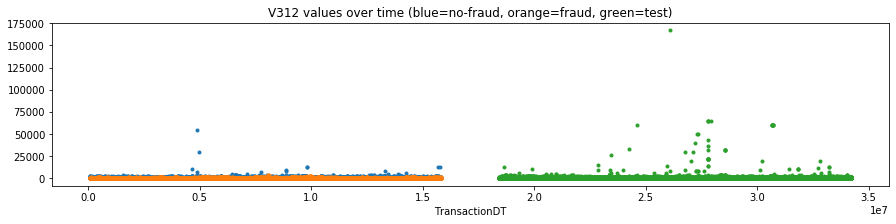

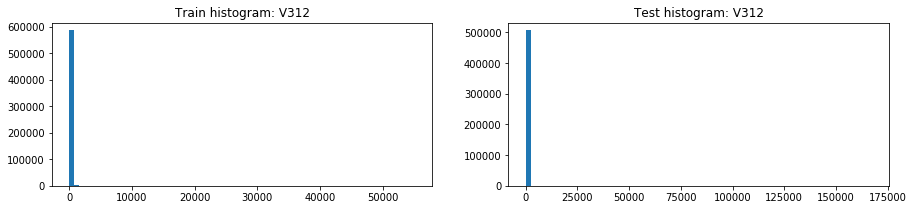

V312          Train   Train fraud  Train Not fraud  \
0           count  590528.000000  20661.000000    569867.000000   
1            mean      39.173910     73.144119        37.942292   
2             std     172.128339    221.490399       169.942491   
3             min       0.000000      0.000000         0.000000   
4             25%       0.000000      0.000000         0.000000   
5             50%       0.000000      0.000000         0.000000   
6             75%       0.000000     30.950001         0.000000   
7             max   55125.000000   3981.000000     55125.000000   
8   unique values    8069.000000   1103.000000      7849.000000   
9            NaNs      12.000000      2.000000        10.000000   
10     NaNs share       0.000000      0.000100         0.000000   

             Test    Test public   Test private  
0   506688.000000  101336.000000  405353.000000  
1       42.733066      41.554030      43.027713  
2      467.654628     162.602639     516.492310  
3        0.000000       0.000000       0.000000  
4        0.000000       0.000000       0.000000  
5        0.000000       0.000000       0.000000  
6        0.000000       0.000000       0.000000  
7   167200.000000   12500.000000  167200.000000  
8     6439.000000    2519.000000    5776.000000  
9        3.000000       3.000000       0.000000  
10       0.000000       0.000000       0.000000

V312  Count in train (desc)  Mean target  Sum target  Count in test
0    0.000000                 466863     0.032099       14986       398789.0
1   59.000000                   6301     0.026662         168         5629.0
2  117.000000                   6102     0.045067         275         5608.0
3   57.950001                   3472     0.008065          28         2744.0
4   49.000000                   3085     0.046677         144         2876.0
5  107.949997                   2827     0.020870          59         2284.0
6  226.000000                   2406     0.051953         125         2424.0
7   39.000000                   2233     0.027318          61         1805.0
8   29.000000                   1820     0.024725          45         1525.0
9  171.000000                   1591     0.062225          99         1477.0

V312  Count in train  Mean target  Sum target (desc)  Count in test
0    0.0          466863     0.032099              14986         398789
1  117.0            6102     0.045067                275           5608
2   59.0            6301     0.026662                168           5629
3   49.0            3085     0.046677                144           2876
4  226.0            2406     0.051953                125           2424
5  171.0            1591     0.062225                 99           1477
6   97.0            1015     0.075862                 77           1000
7  335.0            1136     0.065141                 74           1121
8  445.0             462     0.155844                 72            488
9   77.0            1522     0.045992                 70           1438

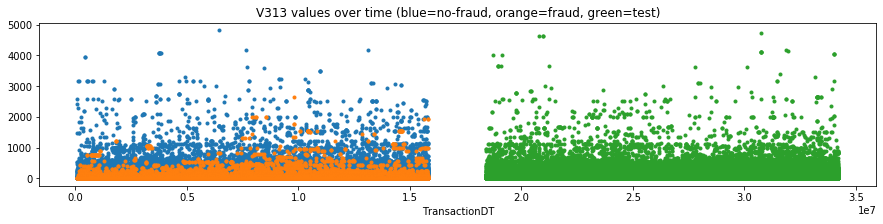

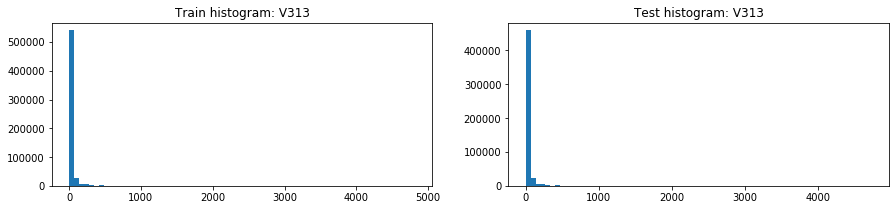

V313          Train   Train fraud  Train Not fraud  \
0           count  589271.000000  20617.000000    568654.000000   
1            mean      21.351473     42.250735        20.593754   
2             std      95.902970    139.558705        93.852655   
3             min       0.000000      0.000000         0.000000   
4             25%       0.000000      0.000000         0.000000   
5             50%       0.000000      0.000000         0.000000   
6             75%       0.000000      0.000000         0.000000   
7             max    4817.470215   2652.000000      4817.470215   
8   unique values    5530.000000    641.000000      5366.000000   
9            NaNs    1269.000000     46.000000      1223.000000   
10     NaNs share       0.002100      0.002200         0.002100   

             Test    Test public   Test private  
0   500660.000000  100922.000000  399739.000000  
1       21.238136      22.302349      20.969402  
2       94.662615     102.446235      92.592182  
3        0.000000       0.000000       0.000000  
4        0.000000       0.000000       0.000000  
5        0.000000       0.000000       0.000000  
6        0.000000       0.000000       0.000000  
7     4727.959961    4624.439941    4727.959961  
8     4113.000000    1449.000000    3642.000000  
9     6031.000000     417.000000    5614.000000  
10       0.011900       0.004100       0.013800

V313  Count in train (desc)  Mean target  Sum target  Count in test
0    0.000000                 489641     0.032507       15917       415370.0
1   59.000000                   6654     0.030508         203         5568.0
2  117.000000                   5319     0.058658         312         5195.0
3   57.950001                   3608     0.009978          36         2931.0
4  107.949997                   3472     0.016705          58         2783.0
5   49.000000                   3096     0.062984         195         2769.0
6  226.000000                   2368     0.086571         205         2070.0
7   39.000000                   2331     0.059631         139         1723.0
8  100.000000                   2186     0.027905          61          659.0
9   29.000000                   1666     0.032413          54         1435.0

V313  Count in train  Mean target  Sum target (desc)  Count in test
0    0.0          489641     0.032507              15917         415370
1  117.0            5319     0.058658                312           5195
2  226.0            2368     0.086571                205           2070
3   59.0            6654     0.030508                203           5568
4   49.0            3096     0.062984                195           2769
5   39.0            2331     0.059631                139           1723
6   87.0             550     0.214545                118            388
7  171.0            1423     0.075896                108           1296
8  335.0             852     0.092723                 79            935
9  445.0             420     0.180952                 76            388

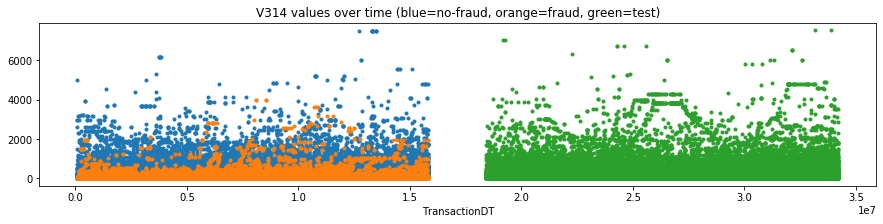

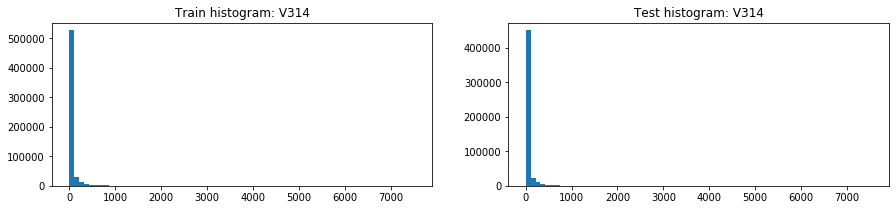

V314          Train   Train fraud  Train Not fraud  \
0           count  589271.000000  20617.000000    568654.000000   
1            mean      43.319174     78.456388        42.045247   
2             std     173.619028    258.446060       169.612774   
3             min       0.000000      0.000000         0.000000   
4             25%       0.000000      0.000000         0.000000   
5             50%       0.000000      0.000000         0.000000   
6             75%       0.000000      0.000000         0.000000   
7             max    7519.870117   3981.000000      7519.870117   
8   unique values   11378.000000   1109.000000     11123.000000   
9            NaNs    1269.000000     46.000000      1223.000000   
10     NaNs share       0.002100      0.002200         0.002100   

             Test    Test public   Test private  
0   500660.000000  100922.000000  399739.000000  
1       43.269524      43.257986      43.272328  
2      195.591901     177.564475     199.886368  
3        0.000000       0.000000       0.000000  
4        0.000000       0.000000       0.000000  
5        0.000000       0.000000       0.000000  
6        0.000000       0.000000       0.000000  
7     7539.750000    7015.899902    7539.750000  
8     9052.000000    3269.000000    8028.000000  
9     6031.000000     417.000000    5614.000000  
10       0.011900       0.004100       0.013800

V314  Count in train (desc)  Mean target  Sum target  Count in test
0    0.000000                 473273     0.032702       15477       402663.0
1   59.000000                   4262     0.026044         111         3631.0
2  117.000000                   3839     0.058088         223         3602.0
3  107.949997                   2671     0.019468          52         2143.0
4   57.950001                   2567     0.006623          17         2226.0
5   49.000000                   2161     0.044424          96         1895.0
6  226.000000                   1574     0.062897          99         1523.0
7   39.000000                   1420     0.026056          37         1150.0
8  740.000000                   1412     0.002125           3           23.0
9 -999.000000                   1269     0.036249          46         6031.0

V314  Count in train  Mean target  Sum target (desc)  Count in test
0    0.000000          473273     0.032702              15477         402663
1  117.000000            3839     0.058088                223           3602
2   59.000000            4262     0.026044                111           3631
3  226.000000            1574     0.062897                 99           1523
4   49.000000            2161     0.044424                 96           1895
5  171.000000             969     0.068111                 66            919
6  445.000000             276     0.228261                 63            311
7  335.000000             626     0.092652                 58            730
8  107.949997            2671     0.019468                 52           2143
9   78.000000             326     0.156442                 51            274

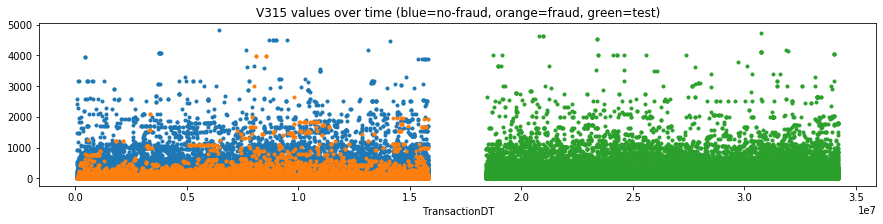

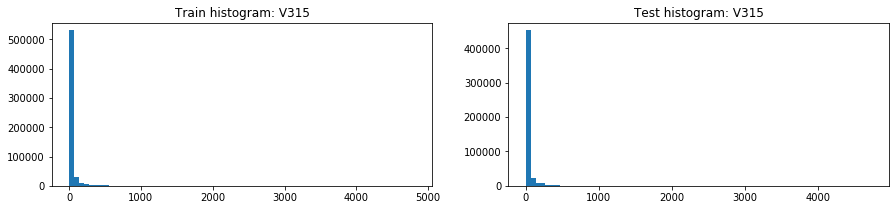

V315          Train   Train fraud  Train Not fraud  \
0           count  589271.000000  20617.000000    568654.000000   
1            mean      26.806977     56.447212        25.732347   
2             std     116.853222    187.113982       113.346437   
3             min       0.000000      0.000000         0.000000   
4             25%       0.000000      0.000000         0.000000   
5             50%       0.000000      0.000000         0.000000   
6             75%       0.000000      0.000000         0.000000   
7             max    4817.470215   3981.000000      4817.470215   
8   unique values    6974.000000    791.000000      6777.000000   
9            NaNs    1269.000000     46.000000      1223.000000   
10     NaNs share       0.002100      0.002200         0.002100   

             Test    Test public   Test private  
0   500660.000000  100922.000000  399739.000000  
1       26.730428      27.597875      26.511357  
2      115.676311     119.085237     114.798635  
3        0.000000       0.000000       0.000000  
4        0.000000       0.000000       0.000000  
5        0.000000       0.000000       0.000000  
6        0.000000       0.000000       0.000000  
7     4727.959961    4624.439941    4727.959961  
8     5377.000000    1894.000000    4782.000000  
9     6031.000000     417.000000    5614.000000  
10       0.011900       0.004100       0.013800

V315  Count in train (desc)  Mean target  Sum target  Count in test
0    0.000000                 487073     0.032394       15778       413471.0
1   59.000000                   5114     0.022878         117         4278.0
2  117.000000                   4360     0.052752         230         4022.0
3  107.949997                   3048     0.015748          48         2391.0
4   57.950001                   3012     0.009960          30         2547.0
5   49.000000                   2474     0.055780         138         2188.0
6  100.000000                   2154     0.012071          26          662.0
7  226.000000                   1766     0.070781         125         1645.0
8   39.000000                   1655     0.022356          37         1387.0
9   29.000000                   1297     0.026214          34         1153.0

V315  Count in train  Mean target  Sum target (desc)  Count in test
0    0.0          487073     0.032394              15778         413471
1  117.0            4360     0.052752                230           4022
2   49.0            2474     0.055780                138           2188
3  226.0            1766     0.070781                125           1645
4   59.0            5114     0.022878                117           4278
5  171.0            1153     0.080659                 93           1074
6  445.0             291     0.219931                 64            333
7   78.0             397     0.153652                 61            223
8  335.0             643     0.083981                 54            758
9   77.0            1035     0.050242                 52            946

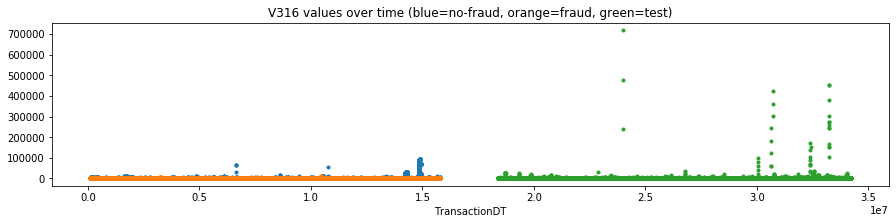

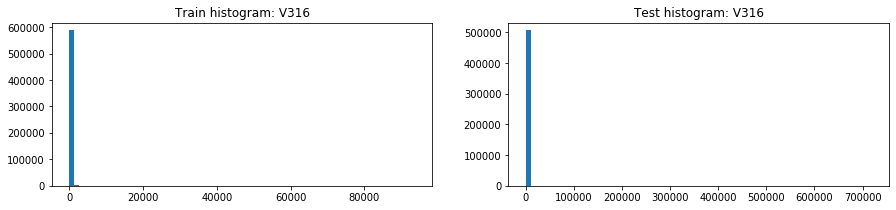

V316          Train   Train fraud  Train Not fraud  \
0           count  590528.000000  20661.000000    569867.000000   
1            mean     109.818544     74.526581       111.098084   
2             std    2270.033202    336.081637      2309.921526   
3             min       0.000000      0.000000         0.000000   
4             25%       0.000000      0.000000         0.000000   
5             50%       0.000000      0.000000         0.000000   
6             75%       0.000000      0.000000         0.000000   
7             max   93736.000000  11848.000000     93736.000000   
8   unique values    9815.000000   1675.000000      9156.000000   
9            NaNs      12.000000      2.000000        10.000000   
10     NaNs share       0.000000      0.000100         0.000000   

             Test    Test public   Test private  
0   506688.000000  101336.000000  405353.000000  
1       42.077887      28.979343      45.352346  
2     2249.338097     379.278283    2507.658140  
3        0.000000       0.000000       0.000000  
4        0.000000       0.000000       0.000000  
5        0.000000       0.000000       0.000000  
6        0.000000       0.000000       0.000000  
7   718740.000000   26400.000000  718740.000000  
8     7561.000000    2307.000000    6547.000000  
9        3.000000       3.000000       0.000000  
10       0.000000       0.000000       0.000000

V316  Count in train (desc)  Mean target  Sum target  Count in test
0    0.0                 546442     0.030129       16464       471485.0
1  117.0                   1727     0.068327         118         1263.0
2   59.0                   1504     0.060505          91         1109.0
3  100.0                    949     0.062171          59          530.0
4   49.0                    878     0.086560          76          595.0
5  226.0                    804     0.067164          54          594.0
6   50.0                    678     0.061947          42          322.0
7  171.0                    575     0.080000          46          378.0
8  150.0                    563     0.133215          75          345.0
9  200.0                    561     0.110517          62          477.0

V316  Count in train  Mean target  Sum target (desc)  Count in test
0    0.0          546442     0.030129              16464         471485
1  117.0            1727     0.068327                118           1263
2   59.0            1504     0.060505                 91           1109
3   49.0             878     0.086560                 76            595
4  150.0             563     0.133215                 75            345
5  200.0             561     0.110517                 62            477
6  100.0             949     0.062171                 59            530
7  300.0             451     0.126386                 57            296
8  226.0             804     0.067164                 54            594
9  171.0             575     0.080000                 46            378

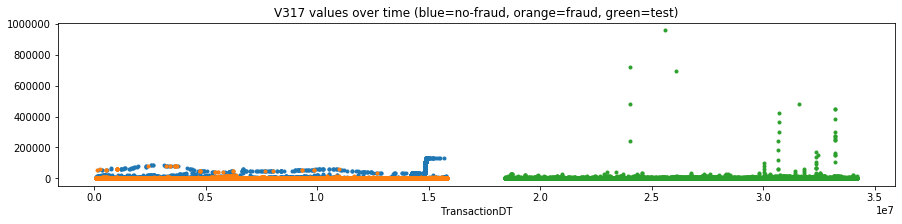

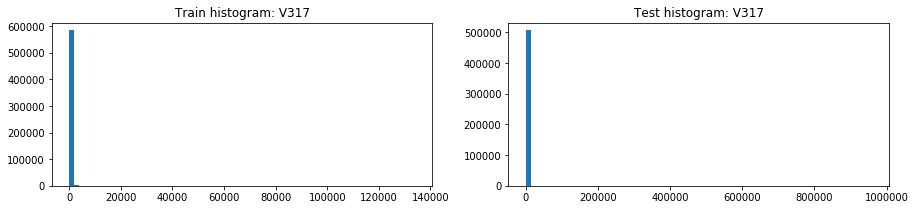

V317          Train   Train fraud  Train Not fraud  \
0           count  590528.000000  20661.000000    569867.000000   
1            mean     247.606741    352.323304       243.810156   
2             std    3980.042828   2912.608406      4013.364529   
3             min       0.000000      0.000000         0.000000   
4             25%       0.000000      0.000000         0.000000   
5             50%       0.000000      0.000000         0.000000   
6             75%       0.000000     65.004501         0.000000   
7             max  134021.000000  82130.953125    134021.000000   
8   unique values   15185.000000   3030.000000     13820.000000   
9            NaNs      12.000000      2.000000        10.000000   
10     NaNs share       0.000000      0.000100         0.000000   

             Test    Test public   Test private  
0   506688.000000  101336.000000  405353.000000  
1       83.808337      64.203518      88.709227  
2     2919.418027     506.202211    3254.152821  
3        0.000000       0.000000       0.000000  
4        0.000000       0.000000       0.000000  
5        0.000000       0.000000       0.000000  
6        0.000000       0.000000       0.000000  
7   958320.000000   26400.000000  958320.000000  
8    11280.000000    3703.000000    9620.000000  
9        3.000000       3.000000       0.000000  
10       0.000000       0.000000       0.000000

V317  Count in train (desc)  Mean target  Sum target  Count in test
0    0.0                 519413     0.027015       14032       452784.0
1  117.0                   2224     0.051259         114         1512.0
2   59.0                   1827     0.035577          65         1359.0
3  226.0                   1045     0.046890          49          760.0
4  100.0                   1039     0.065448          68          589.0
5   49.0                    963     0.066459          64          685.0
6   50.0                    742     0.066038          49          369.0
7  171.0                    720     0.069444          50          454.0
8  234.0                    676     0.069527          47          522.0
9   77.0                    663     0.063348          42          465.0

V317  Count in train  Mean target  Sum target (desc)  Count in test
0    0.0          519413     0.027015              14032         452784
1  117.0            2224     0.051259                114           1512
2  150.0             608     0.136513                 83            415
3  100.0            1039     0.065448                 68            589
4  200.0             641     0.102964                 66            529
5  300.0             498     0.132530                 66            328
6   59.0            1827     0.035577                 65           1359
7   49.0             963     0.066459                 64            685
8  335.0             559     0.096601                 54            391
9  171.0             720     0.069444                 50            454

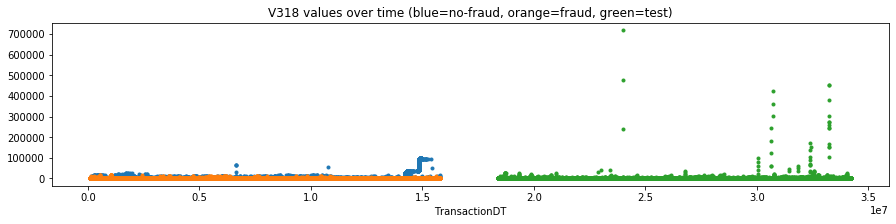

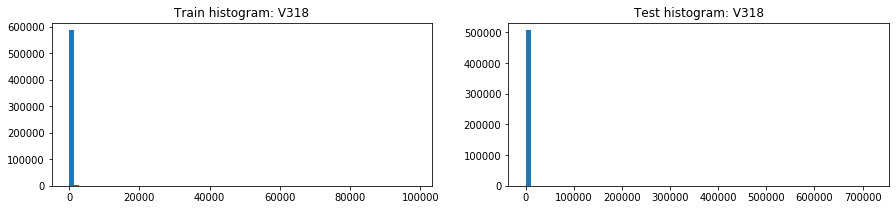

V318          Train   Train fraud  Train Not fraud  \
0           count  590528.000000  20661.000000    569867.000000   
1            mean     162.153398    176.781527       161.623043   
2             std    2793.343636    894.133506      2838.427857   
3             min       0.000000      0.000000         0.000000   
4             25%       0.000000      0.000000         0.000000   
5             50%       0.000000      0.000000         0.000000   
6             75%       0.000000     28.397400         0.000000   
7             max   98476.000000  18123.957031     98476.000000   
8   unique values   12310.000000   2434.000000     11293.000000   
9            NaNs      12.000000      2.000000        10.000000   
10     NaNs share       0.000000      0.000100         0.000000   

             Test    Test public   Test private  
0   506688.000000  101336.000000  405353.000000  
1       56.090776      43.122257      59.332695  
2     2263.811948     432.303319    2521.754357  
3        0.000000       0.000000       0.000000  
4        0.000000       0.000000       0.000000  
5        0.000000       0.000000       0.000000  
6        0.000000       0.000000       0.000000  
7   718740.000000   26400.000000  718740.000000  
8     9490.000000    3005.000000    8174.000000  
9        3.000000       3.000000       0.000000  
10       0.000000       0.000000       0.000000

V318  Count in train (desc)  Mean target  Sum target  Count in test
0    0.0                 535074     0.028159       15067       463263.0
1  117.0                   1937     0.059886         116         1315.0
2   59.0                   1586     0.052333          83         1183.0
3  100.0                    991     0.065590          65          561.0
4  226.0                    873     0.057274          50          636.0
5   49.0                    872     0.060780          53          585.0
6   50.0                    698     0.071633          50          345.0
7  171.0                    626     0.073482          46          389.0
8  200.0                    603     0.111111          67          503.0
9  150.0                    595     0.137815          82          396.0

V318  Count in train  Mean target  Sum target (desc)  Count in test
0    0.0          535074     0.028159              15067         463263
1  117.0            1937     0.059886                116           1315
2   59.0            1586     0.052333                 83           1183
3  150.0             595     0.137815                 82            396
4  200.0             603     0.111111                 67            503
5  100.0             991     0.065590                 65            561
6  300.0             488     0.122951                 60            326
7   49.0             872     0.060780                 53            585
8  226.0             873     0.057274                 50            636
9   50.0             698     0.071633                 50            345

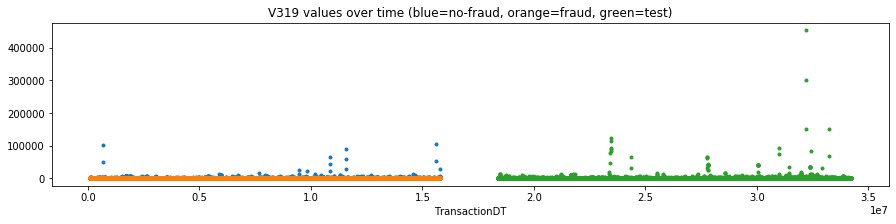

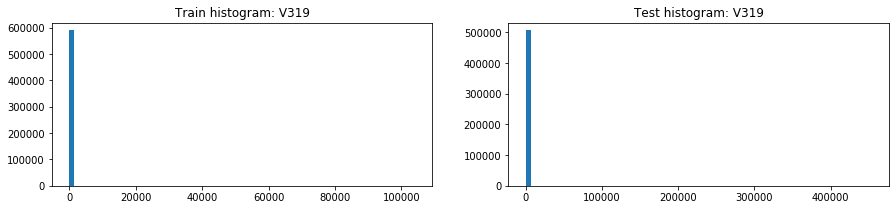

V319          Train   Train fraud  Train Not fraud  \
0           count  590528.000000  20661.000000    569867.000000   
1            mean      18.372476     18.478514        18.368631   
2             std     332.304848    123.652990       337.454879   
3             min       0.000000      0.000000         0.000000   
4             25%       0.000000      0.000000         0.000000   
5             50%       0.000000      0.000000         0.000000   
6             75%       0.000000      0.000000         0.000000   
7             max  104060.000000   4528.899902    104060.000000   
8   unique values    4800.000000    420.000000      4677.000000   
9            NaNs      12.000000      2.000000        10.000000   
10     NaNs share       0.000000      0.000100         0.000000   

             Test    Test public   Test private  
0   506688.000000  101336.000000  405353.000000  
1       27.620156      26.444595      27.913972  
2      999.900445     291.969644    1108.346677  
3        0.000000       0.000000       0.000000  
4        0.000000       0.000000       0.000000  
5        0.000000       0.000000       0.000000  
6        0.000000       0.000000       0.000000  
7   453750.000000   14597.879883  453750.000000  
8     4904.000000    1596.000000    4155.000000  
9        3.000000       3.000000       0.000000  
10       0.000000       0.000000       0.000000

V319  Count in train (desc)  Mean target  Sum target  Count in test
0     0.000000                 562740     0.034430       19375       478167.0
1   100.000000                   1040     0.041346          43          878.0
2  1165.000000                    870     0.000000           0            NaN
3   117.000000                    778     0.044987          35          816.0
4   200.000000                    747     0.061580          46          743.0
5    59.000000                    633     0.044234          28          808.0
6   150.000000                    547     0.093236          51          429.0
7   107.949997                    516     0.007752           4          562.0
8    57.950001                    512     0.000000           0          566.0
9    50.000000                    502     0.049801          25          434.0

V319  Count in train  Mean target  Sum target (desc)  Count in test
0    0.0          562740     0.034430              19375         478167
1  150.0             547     0.093236                 51            429
2  200.0             747     0.061580                 46            743
3  300.0             470     0.091489                 43            446
4  100.0            1040     0.041346                 43            878
5  117.0             778     0.044987                 35            816
6   59.0             633     0.044234                 28            808
7  226.0             447     0.062640                 28            524
8   50.0             502     0.049801                 25            434
9   49.0             385     0.057143                 22            434

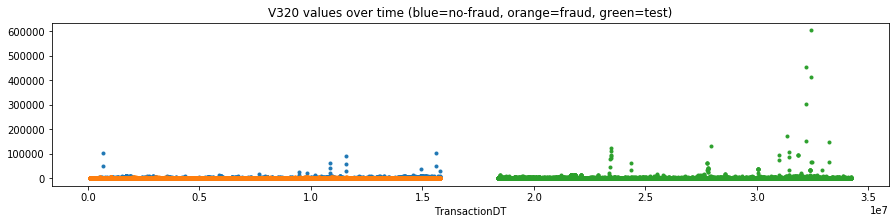

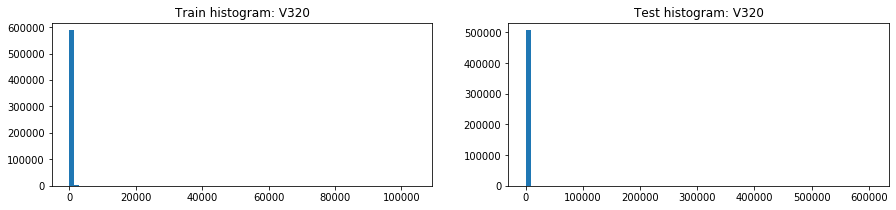

V320          Train   Train fraud  Train Not fraud  \
0           count  590528.000000  20661.000000    569867.000000   
1            mean      42.073133     54.409545        41.625866   
2             std     473.499307    307.351165       478.434705   
3             min       0.000000      0.000000         0.000000   
4             25%       0.000000      0.000000         0.000000   
5             50%       0.000000      0.000000         0.000000   
6             75%       0.000000      0.000000         0.000000   
7             max  104060.000000   5794.500000    104060.000000   
8   unique values    6440.000000    654.000000      6213.000000   
9            NaNs      12.000000      2.000000        10.000000   
10     NaNs share       0.000000      0.000100         0.000000   

             Test    Test public   Test private  
0   506688.000000  101336.000000  405353.000000  
1       46.835629      47.961275      46.554109  
2     1514.927745     411.917958    1681.166966  
3        0.000000       0.000000       0.000000  
4        0.000000       0.000000       0.000000  
5        0.000000       0.000000       0.000000  
6        0.000000       0.000000       0.000000  
7   605000.000000   14597.879883  605000.000000  
8     6480.000000    2221.000000    5379.000000  
9        3.000000       3.000000       0.000000  
10       0.000000       0.000000       0.000000

V320  Count in train (desc)  Mean target  Sum target  Count in test
0     0.000000                 542892     0.033657       18272       458214.0
1   117.000000                   1298     0.040062          52         1440.0
2    59.000000                   1256     0.043790          55         1570.0
3   100.000000                   1172     0.052048          61          962.0
4    57.950001                    978     0.000000           0         1128.0
5   107.949997                    922     0.014100          13         1026.0
6  7226.000000                    871     0.000000           0            NaN
7   200.000000                    796     0.061558          49          816.0
8   226.000000                    788     0.038071          30          783.0
9    49.000000                    690     0.049275          34          724.0

V320  Count in train  Mean target  Sum target (desc)  Count in test
0    0.0          542892     0.033657              18272         458214
1  100.0            1172     0.052048                 61            962
2  150.0             609     0.100164                 61            450
3   59.0            1256     0.043790                 55           1570
4  300.0             514     0.103113                 53            463
5  117.0            1298     0.040062                 52           1440
6  200.0             796     0.061558                 49            816
7  171.0             514     0.085603                 44            517
8   50.0             645     0.054264                 35            510
9   49.0             690     0.049275                 34            724

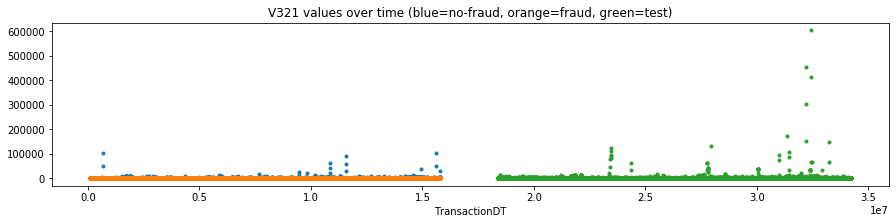

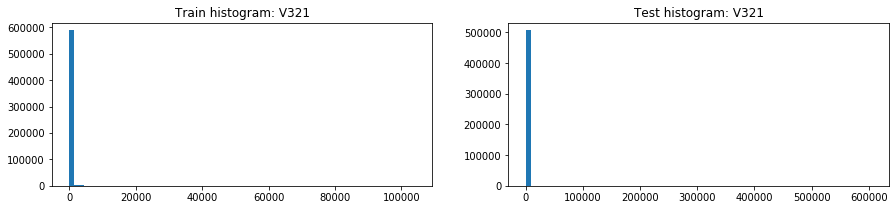

V321          Train   Train fraud  Train Not fraud  \
0           count  590528.000000  20661.000000    569867.000000   
1            mean      28.326584     31.691673        28.204580   
2             std     382.053171    177.831364       387.440031   
3             min       0.000000      0.000000         0.000000   
4             25%       0.000000      0.000000         0.000000   
5             50%       0.000000      0.000000         0.000000   
6             75%       0.000000      0.000000         0.000000   
7             max  104060.000000   4528.899902    104060.000000   
8   unique values    5561.000000    551.000000      5386.000000   
9            NaNs      12.000000      2.000000        10.000000   
10     NaNs share       0.000000      0.000100         0.000000   

             Test    Test public   Test private  
0   506688.000000  101336.000000  405353.000000  
1       36.772511      33.627887      37.558559  
2     1486.814768     314.357109    1654.856151  
3        0.000000       0.000000       0.000000  
4        0.000000       0.000000       0.000000  
5        0.000000       0.000000       0.000000  
6        0.000000       0.000000       0.000000  
7   605000.000000   14597.879883  605000.000000  
8     5616.000000    1851.000000    4732.000000  
9        3.000000       3.000000       0.000000  
10       0.000000       0.000000       0.000000

V321  Count in train (desc)  Mean target  Sum target  Count in test
0    0.000000                 555629     0.033904       18838       471406.0
1  100.000000                   1104     0.040761          45          919.0
2  117.000000                    981     0.063201          62         1085.0
3   59.000000                    881     0.047673          42         1038.0
4  200.000000                    769     0.059818          46          782.0
5   57.950001                    622     0.001608           1          685.0
6  107.949997                    613     0.008157           5          653.0
7  150.000000                    585     0.102564          60          442.0
8  226.000000                    571     0.049037          28          616.0
9   50.000000                    571     0.063047          36          461.0

V321  Count in train  Mean target  Sum target (desc)  Count in test
0    0.0          555629     0.033904              18838         471406
1  117.0             981     0.063201                 62           1085
2  150.0             585     0.102564                 60            442
3  300.0             494     0.097166                 48            464
4  200.0             769     0.059818                 46            782
5  100.0            1104     0.040761                 45            919
6   59.0             881     0.047673                 42           1038
7   50.0             571     0.063047                 36            461
8  171.0             373     0.085791                 32            353
9  226.0             571     0.049037                 28            616

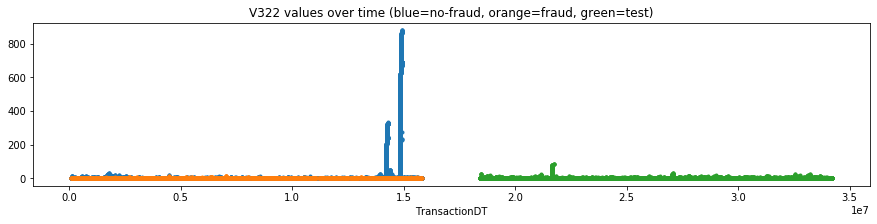

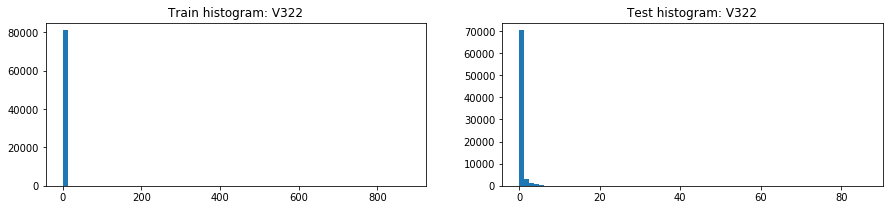

V322          Train   Train fraud  Train Not fraud  \
0           count   82351.000000   3686.000000     78665.000000   
1            mean       6.220289      0.645415         6.481510   
2             std      56.022561      1.371503        57.306006   
3             min       0.000000      0.000000         0.000000   
4             25%       0.000000      0.000000         0.000000   
5             50%       0.000000      0.000000         0.000000   
6             75%       0.000000      1.000000         0.000000   
7             max     880.000000     16.000000       880.000000   
8   unique values     882.000000     18.000000       882.000000   
9            NaNs  508189.000000  16977.000000    491212.000000   
10     NaNs share       0.860500      0.821600         0.862000   

             Test   Test public   Test private  
0    76431.000000   8971.000000   67460.000000  
1        0.436681      0.971687       0.365535  
2        2.129226      5.176320       1.237153  
3        0.000000      0.000000       0.000000  
4        0.000000      0.000000       0.000000  
5        0.000000      0.000000       0.000000  
6        0.000000      0.000000       0.000000  
7       86.000000     86.000000      32.000000  
8       88.000000     88.000000      34.000000  
9   430260.000000  92368.000000  337893.000000  
10       0.849200      0.911500       0.833600

V322  Count in train (desc)  Mean target  Sum target  Count in test
0 -999.0                 508189     0.033407       16977       430260.0
1    0.0                  65970     0.038290        2526        62414.0
2    1.0                   8562     0.072997         625         7848.0
3    2.0                   3226     0.077185         249         2945.0
4    3.0                   1502     0.086551         130         1348.0
5    4.0                    777     0.096525          75          712.0
6    5.0                    350     0.082857          29          338.0
7    6.0                    196     0.091837          18          198.0
8    7.0                    123     0.089431          11          132.0
9    8.0                     80     0.112500           9           97.0

V322  Count in train  Mean target  Sum target (desc)  Count in test
0 -999.0          508189     0.033407              16977         430260
1    0.0           65970     0.038290               2526          62414
2    1.0            8562     0.072997                625           7848
3    2.0            3226     0.077185                249           2945
4    3.0            1502     0.086551                130           1348
5    4.0             777     0.096525                 75            712
6    5.0             350     0.082857                 29            338
7    6.0             196     0.091837                 18            198
8    7.0             123     0.089431                 11            132
9    8.0              80     0.112500                  9             97

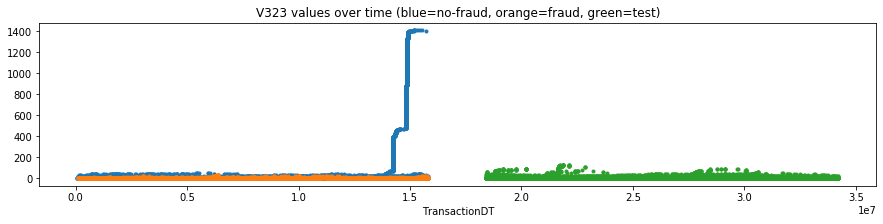

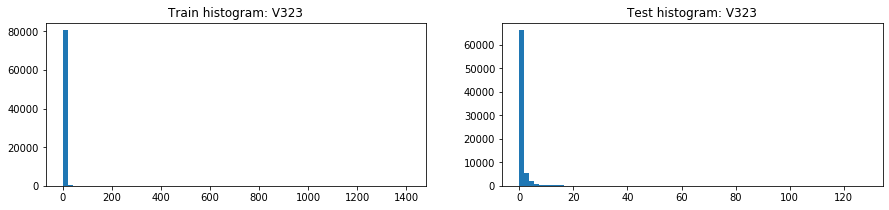

V323          Train   Train fraud  Train Not fraud  \
0           count   82351.000000   3686.000000     78665.000000   
1            mean      13.103775      1.600380        13.642789   
2             std     106.739813      3.709768       109.179292   
3             min       0.000000      0.000000         0.000000   
4             25%       0.000000      0.000000         0.000000   
5             50%       0.000000      0.000000         0.000000   
6             75%       1.000000      1.000000         1.000000   
7             max    1411.000000     34.000000      1411.000000   
8   unique values    1412.000000     36.000000      1412.000000   
9            NaNs  508189.000000  16977.000000    491212.000000   
10     NaNs share       0.860500      0.821600         0.862000   

             Test   Test public   Test private  
0    76431.000000   8971.000000   67460.000000  
1        1.216182      2.853862       0.998399  
2        5.925144     11.531003       4.657444  
3        0.000000      0.000000       0.000000  
4        0.000000      0.000000       0.000000  
5        0.000000      0.000000       0.000000  
6        0.000000      1.000000       0.000000  
7      128.000000    124.000000     128.000000  
8      130.000000    126.000000     109.000000  
9   430260.000000  92368.000000  337893.000000  
10       0.849200      0.911500       0.833600

V323  Count in train (desc)  Mean target  Sum target  Count in test
0 -999.0                 508189     0.033407       16977       430260.0
1    0.0                  60806     0.036526        2221        57454.0
2    1.0                   9407     0.063463         597         8580.0
3    2.0                   3857     0.067928         262         3510.0
4    3.0                   2027     0.075974         154         1830.0
5    4.0                   1235     0.085020         105         1111.0
6    5.0                    747     0.073628          55          719.0
7    6.0                    488     0.081967          40          492.0
8    7.0                    347     0.080692          28          375.0
9    8.0                    262     0.106870          28          306.0

V323  Count in train  Mean target  Sum target (desc)  Count in test
0 -999.0          508189     0.033407              16977         430260
1    0.0           60806     0.036526               2221          57454
2    1.0            9407     0.063463                597           8580
3    2.0            3857     0.067928                262           3510
4    3.0            2027     0.075974                154           1830
5    4.0            1235     0.085020                105           1111
6    5.0             747     0.073628                 55            719
7    6.0             488     0.081967                 40            492
8    7.0             347     0.080692                 28            375
9    8.0             262     0.106870                 28            306

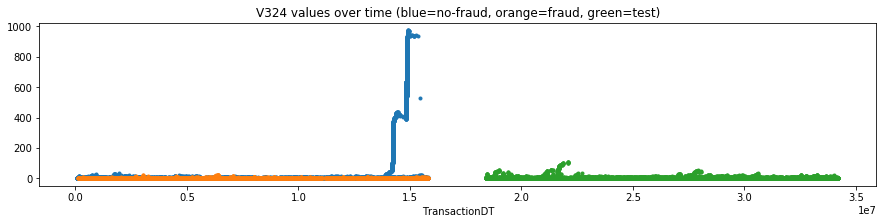

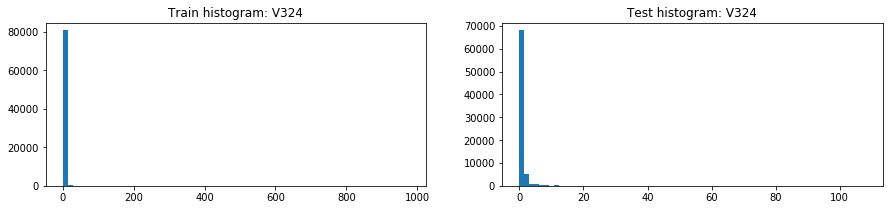

V324          Train   Train fraud  Train Not fraud  \
0           count   82351.000000   3686.000000     78665.000000   
1            mean       9.184612      1.019262         9.567215   
2             std      73.627893      2.257605        75.309861   
3             min       0.000000      0.000000         0.000000   
4             25%       0.000000      0.000000         0.000000   
5             50%       0.000000      0.000000         0.000000   
6             75%       0.000000      1.000000         0.000000   
7             max     976.000000     24.000000       976.000000   
8   unique values     977.000000     26.000000       977.000000   
9            NaNs  508189.000000  16977.000000    491212.000000   
10     NaNs share       0.860500      0.821600         0.862000   

             Test   Test public   Test private  
0    76431.000000   8971.000000   67460.000000  
1        0.693514      1.563371       0.577839  
2        3.343788      6.624241       2.592107  
3        0.000000      0.000000       0.000000  
4        0.000000      0.000000       0.000000  
5        0.000000      0.000000       0.000000  
6        0.000000      1.000000       0.000000  
7      108.000000     88.000000     108.000000  
8      110.000000     90.000000      74.000000  
9   430260.000000  92368.000000  337893.000000  
10       0.849200      0.911500       0.833600

V324  Count in train (desc)  Mean target  Sum target  Count in test
0 -999.0                 508189     0.033407       16977       430260.0
1    0.0                  62945     0.036508        2298        59518.0
2    1.0                   9152     0.068400         626         8494.0
3    2.0                   3782     0.075621         286         3411.0
4    3.0                   1931     0.089073         172         1712.0
5    4.0                   1133     0.105914         120          958.0
6    5.0                    631     0.093502          59          615.0
7    6.0                    405     0.079012          32          391.0
8    7.0                    252     0.087302          22          245.0
9    8.0                    175     0.091429          16          188.0

V324  Count in train  Mean target  Sum target (desc)  Count in test
0 -999.0          508189     0.033407              16977         430260
1    0.0           62945     0.036508               2298          59518
2    1.0            9152     0.068400                626           8494
3    2.0            3782     0.075621                286           3411
4    3.0            1931     0.089073                172           1712
5    4.0            1133     0.105914                120            958
6    5.0             631     0.093502                 59            615
7    6.0             405     0.079012                 32            391
8    7.0             252     0.087302                 22            245
9    8.0             175     0.091429                 16            188

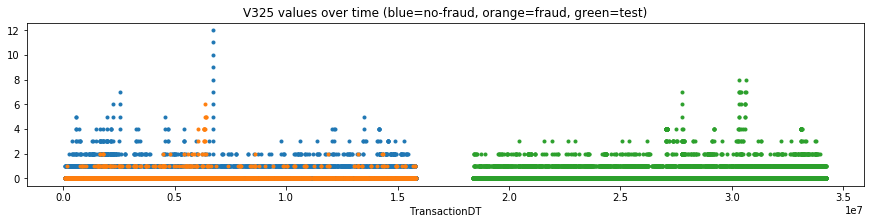

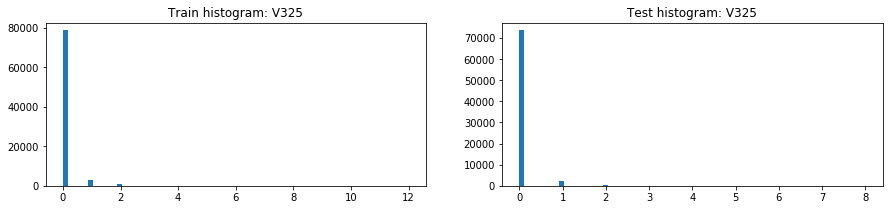

V325          Train   Train fraud  Train Not fraud  \
0           count   82351.000000   3686.000000     78665.000000   
1            mean       0.058494      0.069452         0.057980   
2             std       0.304415      0.354930         0.301833   
3             min       0.000000      0.000000         0.000000   
4             25%       0.000000      0.000000         0.000000   
5             50%       0.000000      0.000000         0.000000   
6             75%       0.000000      0.000000         0.000000   
7             max      12.000000      6.000000        12.000000   
8   unique values      14.000000      8.000000        14.000000   
9            NaNs  508189.000000  16977.000000    491212.000000   
10     NaNs share       0.860500      0.821600         0.862000   

             Test   Test public   Test private  
0    76431.000000   8971.000000   67460.000000  
1        0.047926      0.056181       0.046828  
2        0.282497      0.256397       0.285772  
3        0.000000      0.000000       0.000000  
4        0.000000      0.000000       0.000000  
5        0.000000      0.000000       0.000000  
6        0.000000      0.000000       0.000000  
7        8.000000      3.000000       8.000000  
8       10.000000      5.000000      10.000000  
9   430260.000000  92368.000000  337893.000000  
10       0.849200      0.911500       0.833600

V325  Count in train (desc)  Mean target  Sum target  Count in test
0 -999.0                 508189     0.033407       16977       430260.0
1    0.0                  78588     0.044447        3493        73546.0
2    1.0                   2948     0.053935         159         2409.0
3    2.0                    686     0.029155          20          315.0
4    3.0                     74     0.054054           4           66.0
5    4.0                     33     0.181818           6           75.0
6    5.0                     11     0.272727           3            5.0
7    6.0                      4     0.250000           1            6.0
8    7.0                      2     0.000000           0            7.0
9    8.0                      1     0.000000           0            2.0

V325  Count in train  Mean target  Sum target (desc)  Count in test
0 -999.0          508189     0.033407              16977         430260
1    0.0           78588     0.044447               3493          73546
2    1.0            2948     0.053935                159           2409
3    2.0             686     0.029155                 20            315
4    4.0              33     0.181818                  6             75
5    3.0              74     0.054054                  4             66
6    5.0              11     0.272727                  3              5
7    6.0               4     0.250000                  1              6
8    7.0               2     0.000000                  0              7
9    8.0               1     0.000000                  0              2

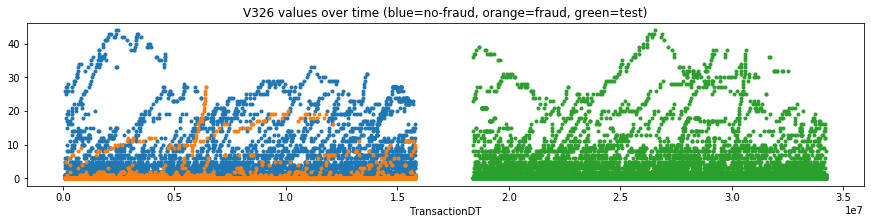

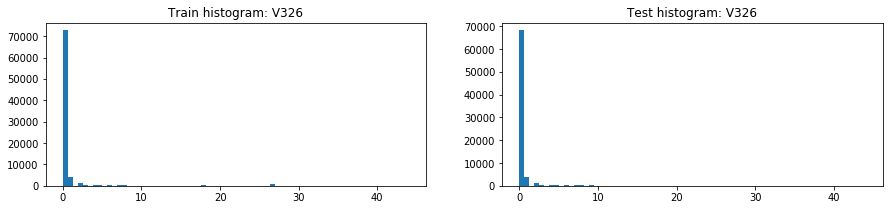

V326          Train   Train fraud  Train Not fraud  \
0           count   82351.000000   3686.000000     78665.000000   
1            mean       0.851040      0.726262         0.856887   
2             std       3.950295      2.788170         3.996386   
3             min       0.000000      0.000000         0.000000   
4             25%       0.000000      0.000000         0.000000   
5             50%       0.000000      0.000000         0.000000   
6             75%       0.000000      0.000000         0.000000   
7             max      44.000000     27.000000        44.000000   
8   unique values      46.000000     29.000000        46.000000   
9            NaNs  508189.000000  16977.000000    491212.000000   
10     NaNs share       0.860500      0.821600         0.862000   

             Test   Test public   Test private  
0    76431.000000   8971.000000   67460.000000  
1        0.482658      0.865790       0.431708  
2        2.555532      3.369686       2.422245  
3        0.000000      0.000000       0.000000  
4        0.000000      0.000000       0.000000  
5        0.000000      0.000000       0.000000  
6        0.000000      0.000000       0.000000  
7       44.000000     39.000000      44.000000  
8       46.000000     37.000000      46.000000  
9   430260.000000  92368.000000  337893.000000  
10       0.849200      0.911500       0.833600

V326  Count in train (desc)  Mean target  Sum target  Count in test
0 -999.0                 508189     0.033407       16977         430260
1    0.0                  72668     0.043307        3147          68210
2    1.0                   4231     0.050106         212           3887
3    2.0                   1097     0.089335          98           1169
4   27.0                    954     0.002096           2             24
5    3.0                    524     0.045802          24            538
6   18.0                    381     0.026247          10             56
7    4.0                    377     0.053050          20            460
8    5.0                    249     0.072289          18            328
9    6.0                    209     0.043062           9            262

V326  Count in train  Mean target  Sum target (desc)  Count in test
0 -999.0          508189     0.033407              16977         430260
1    0.0           72668     0.043307               3147          68210
2    1.0            4231     0.050106                212           3887
3    2.0            1097     0.089335                 98           1169
4    7.0             205     0.146341                 30            202
5    3.0             524     0.045802                 24            538
6    4.0             377     0.053050                 20            460
7   11.0             108     0.185185                 20             76
8    5.0             249     0.072289                 18            328
9    8.0             153     0.117647                 18            211

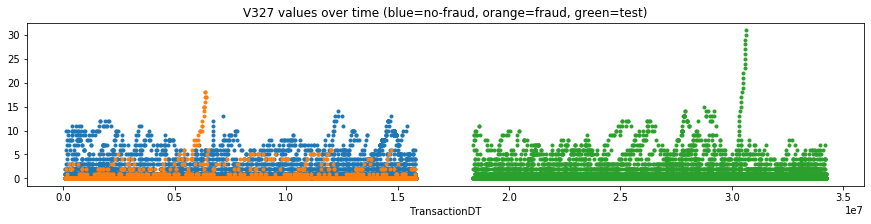

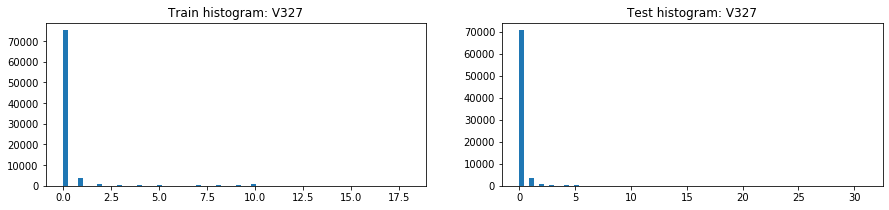

V327          Train   Train fraud  Train Not fraud  \
0           count   82351.000000   3686.000000     78665.000000   
1            mean       0.296633      0.290016         0.296943   
2             std       1.364356      1.257701         1.369157   
3             min       0.000000      0.000000         0.000000   
4             25%       0.000000      0.000000         0.000000   
5             50%       0.000000      0.000000         0.000000   
6             75%       0.000000      0.000000         0.000000   
7             max      18.000000     18.000000        14.000000   
8   unique values      20.000000     20.000000        16.000000   
9            NaNs  508189.000000  16977.000000    491212.000000   
10     NaNs share       0.860500      0.821600         0.862000   

             Test   Test public   Test private  
0    76431.000000   8971.000000   67460.000000  
1        0.163271      0.261509       0.150208  
2        0.850853      0.958242       0.834670  
3        0.000000      0.000000       0.000000  
4        0.000000      0.000000       0.000000  
5        0.000000      0.000000       0.000000  
6        0.000000      0.000000       0.000000  
7       31.000000     11.000000      31.000000  
8       33.000000     13.000000      33.000000  
9   430260.000000  92368.000000  337893.000000  
10       0.849200      0.911500       0.833600

V327  Count in train (desc)  Mean target  Sum target  Count in test
0 -999.0                 508189     0.033407       16977         430260
1    0.0                  75098     0.043410        3260          70596
2    1.0                   3630     0.059780         217           3487
3    2.0                    945     0.099471          94           1022
4   10.0                    692     0.005780           4             30
5    3.0                    423     0.078014          33            445
6    7.0                    419     0.007160           3             85
7    9.0                    331     0.003021           1             37
8    4.0                    264     0.113636          30            286
9    5.0                    199     0.100503          20            184

V327  Count in train  Mean target  Sum target (desc)  Count in test
0 -999.0          508189     0.033407              16977         430260
1    0.0           75098     0.043410               3260          70596
2    1.0            3630     0.059780                217           3487
3    2.0             945     0.099471                 94           1022
4    3.0             423     0.078014                 33            445
5    4.0             264     0.113636                 30            286
6    5.0             199     0.100503                 20            184
7    6.0             143     0.048951                  7            130
8   10.0             692     0.005780                  4             30
9   17.0               3     1.000000                  3              1

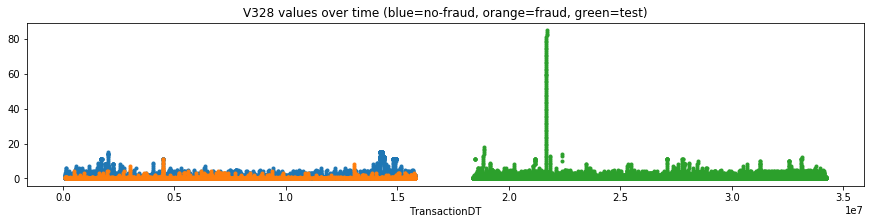

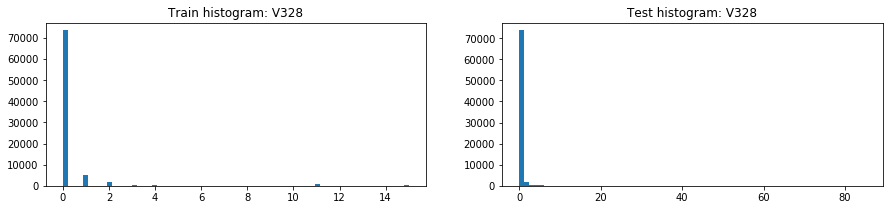

V328          Train   Train fraud  Train Not fraud  \
0           count   82351.000000   3686.000000     78665.000000   
1            mean       0.336790      0.256104         0.340571   
2             std       1.580144      0.786631         1.607652   
3             min       0.000000      0.000000         0.000000   
4             25%       0.000000      0.000000         0.000000   
5             50%       0.000000      0.000000         0.000000   
6             75%       0.000000      0.000000         0.000000   
7             max      15.000000     11.000000        15.000000   
8   unique values      17.000000     13.000000        17.000000   
9            NaNs  508189.000000  16977.000000    491212.000000   
10     NaNs share       0.860500      0.821600         0.862000   

             Test   Test public   Test private  
0    76431.000000   8971.000000   67460.000000  
1        0.220486      0.666035       0.161236  
2        1.789616      4.918845       0.617676  
3        0.000000      0.000000       0.000000  
4        0.000000      0.000000       0.000000  
5        0.000000      0.000000       0.000000  
6        0.000000      0.000000       0.000000  
7       85.000000     85.000000      14.000000  
8       87.000000     87.000000      16.000000  
9   430260.000000  92368.000000  337893.000000  
10       0.849200      0.911500       0.833600

V328  Count in train (desc)  Mean target  Sum target  Count in test
0 -999.0                 508189     0.033407       16977         430260
1    0.0                  73464     0.042592        3129          68348
2    1.0                   4947     0.068931         341           5321
3    2.0                   1574     0.082592         130           1599
4   11.0                   1005     0.001990           2             30
5    3.0                    587     0.093697          55            586
6    4.0                    221     0.063348          14            223
7   15.0                    215     0.000000           0              2
8    5.0                    100     0.040000           4             94
9   12.0                     72     0.000000           0              4

V328  Count in train  Mean target  Sum target (desc)  Count in test
0 -999.0          508189     0.033407              16977         430260
1    0.0           73464     0.042592               3129          68348
2    1.0            4947     0.068931                341           5321
3    2.0            1574     0.082592                130           1599
4    3.0             587     0.093697                 55            586
5    4.0             221     0.063348                 14            223
6    6.0              55     0.072727                  4             49
7    5.0             100     0.040000                  4             94
8    7.0              31     0.096774                  3             33
9   11.0            1005     0.001990                  2             30

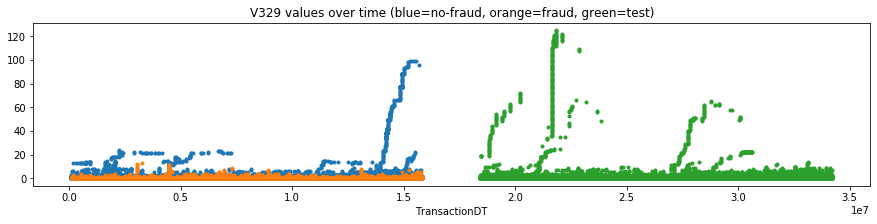

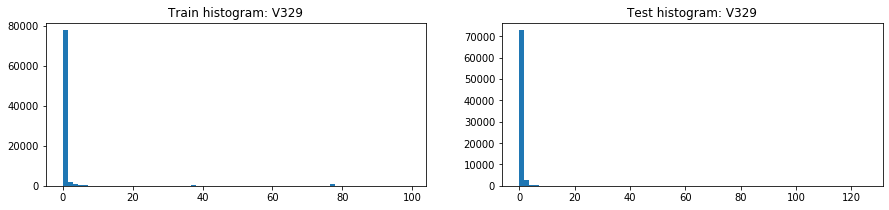

V329          Train   Train fraud  Train Not fraud  \
0           count   82351.000000   3686.000000     78665.000000   
1            mean       1.312844      0.377103         1.356690   
2             std       8.769083      1.063497         8.966832   
3             min       0.000000      0.000000         0.000000   
4             25%       0.000000      0.000000         0.000000   
5             50%       0.000000      0.000000         0.000000   
6             75%       0.000000      0.000000         0.000000   
7             max      99.000000     13.000000        99.000000   
8   unique values     101.000000     15.000000       101.000000   
9            NaNs  508189.000000  16977.000000    491212.000000   
10     NaNs share       0.860500      0.821600         0.862000   

             Test   Test public   Test private  
0    76431.000000   8971.000000   67460.000000  
1        0.460572      1.463493       0.327201  
2        4.228813      9.145929       2.997800  
3        0.000000      0.000000       0.000000  
4        0.000000      0.000000       0.000000  
5        0.000000      0.000000       0.000000  
6        0.000000      0.000000       0.000000  
7      125.000000    121.000000     125.000000  
8      127.000000    123.000000      85.000000  
9   430260.000000  92368.000000  337893.000000  
10       0.849200      0.911500       0.833600

V329  Count in train (desc)  Mean target  Sum target  Count in test
0 -999.0                 508189     0.033407       16977         430260
1    0.0                  72114     0.041490        2992          66984
2    1.0                   5428     0.069823         379           5696
3    2.0                   1796     0.081292         146           1851
4   77.0                    871     0.000000           0              1
5    3.0                    725     0.114483          83            734
6    4.0                    297     0.154882          46            287
7   38.0                    172     0.000000           0              3
8    5.0                    157     0.082803          13            221
9    6.0                    105     0.066667           7             76

V329  Count in train  Mean target  Sum target (desc)  Count in test
0 -999.0          508189     0.033407              16977         430260
1    0.0           72114     0.041490               2992          66984
2    1.0            5428     0.069823                379           5696
3    2.0            1796     0.081292                146           1851
4    3.0             725     0.114483                 83            734
5    4.0             297     0.154882                 46            287
6    5.0             157     0.082803                 13            221
7    6.0             105     0.066667                  7             76
8    7.0              60     0.100000                  6             80
9    8.0              57     0.070175                  4             31

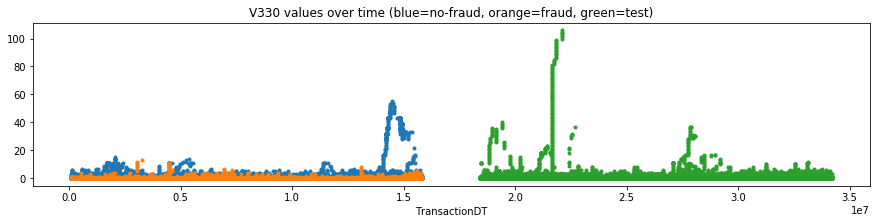

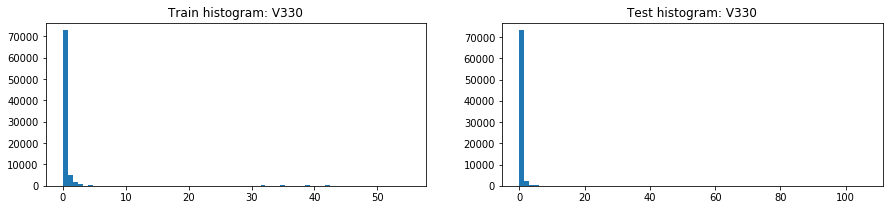

V330          Train   Train fraud  Train Not fraud  \
0           count   82351.000000   3686.000000     78665.000000   
1            mean       0.775874      0.313619         0.797534   
2             std       4.727971      0.960475         4.831921   
3             min       0.000000      0.000000         0.000000   
4             25%       0.000000      0.000000         0.000000   
5             50%       0.000000      0.000000         0.000000   
6             75%       0.000000      0.000000         0.000000   
7             max      55.000000     13.000000        55.000000   
8   unique values      57.000000     15.000000        57.000000   
9            NaNs  508189.000000  16977.000000    491212.000000   
10     NaNs share       0.860500      0.821600         0.862000   

             Test   Test public   Test private  
0    76431.000000   8971.000000   67460.000000  
1        0.309900      0.876714       0.234524  
2        2.632181      5.403554       1.979604  
3        0.000000      0.000000       0.000000  
4        0.000000      0.000000       0.000000  
5        0.000000      0.000000       0.000000  
6        0.000000      0.000000       0.000000  
7      106.000000     85.000000     106.000000  
8      108.000000     87.000000      60.000000  
9   430260.000000  92368.000000  337893.000000  
10       0.849200      0.911500       0.833600

V330  Count in train (desc)  Mean target  Sum target  Count in test
0 -999.0                 508189     0.033407       16977         430260
1    0.0                  72799     0.042185        3071          67667
2    1.0                   5199     0.068282         355           5511
3    2.0                   1739     0.079931         139           1730
4    3.0                    648     0.104938          68            651
5   35.0                    419     0.000000           0              4
6    4.0                    242     0.086777          21            253
7   39.0                    224     0.000000           0              2
8   32.0                    176     0.000000           0              5
9   42.0                    151     0.000000           0              1

V330  Count in train  Mean target  Sum target (desc)  Count in test
0 -999.0          508189     0.033407              16977         430260
1    0.0           72799     0.042185               3071          67667
2    1.0            5199     0.068282                355           5511
3    2.0            1739     0.079931                139           1730
4    3.0             648     0.104938                 68            651
5    4.0             242     0.086777                 21            253
6    5.0             128     0.070312                  9            153
7    6.0              56     0.125000                  7             53
8    7.0              29     0.137931                  4             46
9   11.0              54     0.055556                  3             32

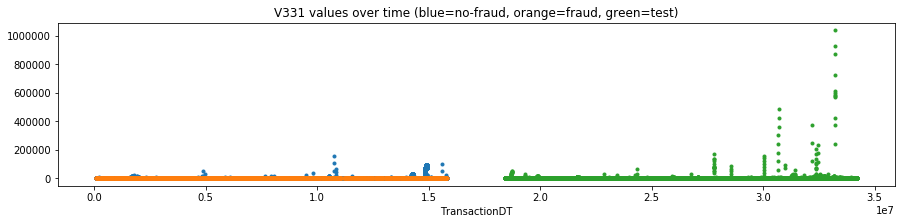

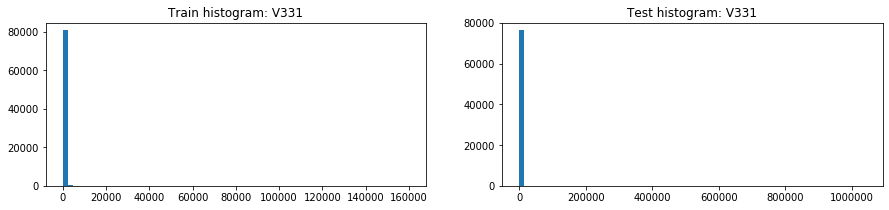

V331          Train   Train fraud  Train Not fraud          Test  \
0           count   82351.000000   3686.000000     78665.000000  7.643100e+04   
1            mean     721.741883     90.384699       751.325339  3.151286e+02   
2             std    6217.223583    227.643019      6359.489982  9.494045e+03   
3             min       0.000000      0.000000         0.000000  0.000000e+00   
4             25%       0.000000      0.000000         0.000000  0.000000e+00   
5             50%       0.000000      0.000000         0.000000  0.000000e+00   
6             75%       0.000000     75.000000         0.000000  0.000000e+00   
7             max  160000.000000   2600.000000    160000.000000  1.040658e+06   
8   unique values    1759.000000    115.000000      1743.000000  6.060000e+02   
9            NaNs  508189.000000  16977.000000    491212.000000  4.302600e+05   
10     NaNs share       0.860500      0.821600         0.862000  8.492000e-01   

     Test public  Test private  
0    8971.000000  6.746000e+04  
1     238.482488  3.253212e+02  
2    1796.757719  1.008432e+04  
3       0.000000  0.000000e+00  
4       0.000000  0.000000e+00  
5       0.000000  0.000000e+00  
6       0.000000  0.000000e+00  
7   50640.000000  1.040658e+06  
8     292.000000  4.700000e+02  
9   92368.000000  3.378930e+05  
10      0.911500  8.336000e-01

V331  Count in train (desc)  Mean target  Sum target  Count in test
0 -999.0                 508189     0.033407       16977       430260.0
1    0.0                  65970     0.038290        2526        62414.0
2  100.0                   2158     0.054680         118         1728.0
3  200.0                   1462     0.072503         106         1383.0
4   50.0                   1375     0.045091          62          990.0
5  150.0                   1222     0.097381         119          915.0
6  300.0                   1022     0.107632         110          884.0
7   25.0                    554     0.036101          20          457.0
8  400.0                    543     0.077348          42          688.0
9  250.0                    496     0.072581          36          512.0

V331  Count in train  Mean target  Sum target (desc)  Count in test
0 -999.0          508189     0.033407              16977         430260
1    0.0           65970     0.038290               2526          62414
2  150.0            1222     0.097381                119            915
3  100.0            2158     0.054680                118           1728
4  300.0            1022     0.107632                110            884
5  200.0            1462     0.072503                106           1383
6   50.0            1375     0.045091                 62            990
7  400.0             543     0.077348                 42            688
8  600.0             413     0.099274                 41            445
9  250.0             496     0.072581                 36            512

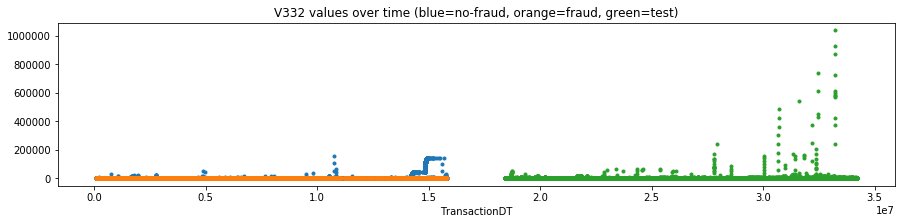

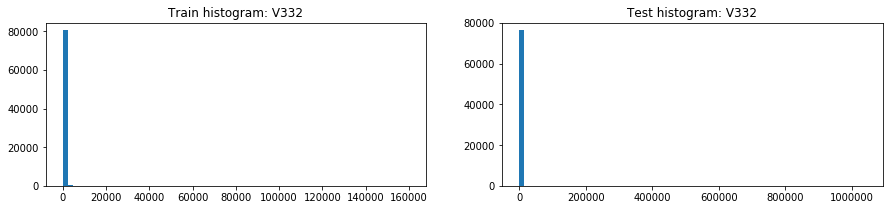

V332          Train   Train fraud  Train Not fraud          Test  \
0           count   82351.000000   3686.000000     78665.000000  7.643100e+04   
1            mean    1375.783644    164.859468      1432.523827  4.404643e+02   
2             std   11169.275702    436.287131     11424.424611  1.064843e+04   
3             min       0.000000      0.000000         0.000000  0.000000e+00   
4             25%       0.000000      0.000000         0.000000  0.000000e+00   
5             50%       0.000000      0.000000         0.000000  0.000000e+00   
6             75%      25.000000    150.000000        20.000000  0.000000e+00   
7             max  160000.000000   4700.000000    160000.000000  1.040658e+06   
8   unique values    2454.000000    230.000000      2400.000000  1.452000e+03   
9            NaNs  508189.000000  16977.000000    491212.000000  4.302600e+05   
10     NaNs share       0.860500      0.821600         0.862000  8.492000e-01   

     Test public  Test private  
0    8971.000000  6.746000e+04  
1     361.773472  4.509288e+02  
2    2004.031078  1.131075e+04  
3       0.000000  0.000000e+00  
4       0.000000  0.000000e+00  
5       0.000000  0.000000e+00  
6     100.000000  0.000000e+00  
7   50640.000000  1.040658e+06  
8     572.000000  1.190000e+03  
9   92368.000000  3.378930e+05  
10      0.911500  8.336000e-01

V332  Count in train (desc)  Mean target  Sum target  Count in test
0 -999.0                 508189     0.033407       16977       430260.0
1    0.0                  60806     0.036526        2221        57454.0
2  100.0                   2546     0.043598         111         2068.0
3   50.0                   1653     0.036903          61         1251.0
4  200.0                   1642     0.065773         108         1566.0
5  150.0                   1418     0.084626         120         1072.0
6  300.0                   1136     0.103873         118          952.0
7   25.0                    662     0.025680          17          526.0
8  250.0                    626     0.076677          48          579.0
9   75.0                    625     0.060800          38          476.0

V332  Count in train  Mean target  Sum target (desc)  Count in test
0 -999.0          508189     0.033407              16977         430260
1    0.0           60806     0.036526               2221          57454
2  150.0            1418     0.084626                120           1072
3  300.0            1136     0.103873                118            952
4  100.0            2546     0.043598                111           2068
5  200.0            1642     0.065773                108           1566
6   50.0            1653     0.036903                 61           1251
7  400.0             621     0.080515                 50            724
8  250.0             626     0.076677                 48            579
9  450.0             290     0.158621                 46            204

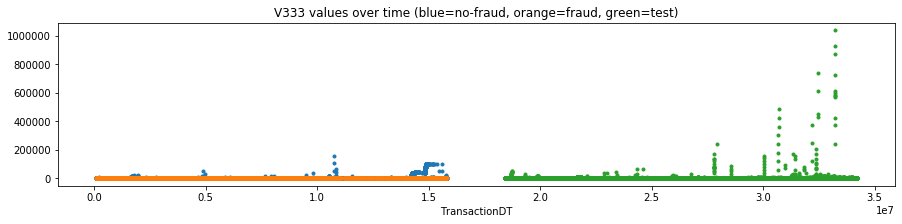

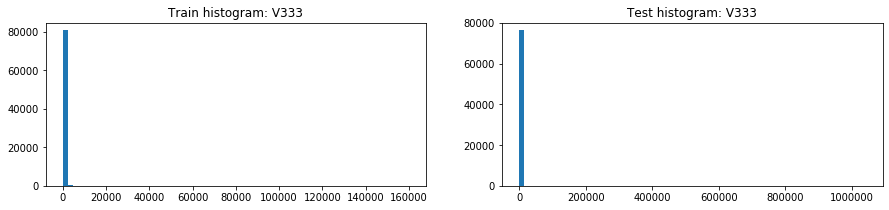

V333          Train   Train fraud  Train Not fraud          Test  \
0           count   82351.000000   3686.000000     78665.000000  7.643100e+04   
1            mean    1014.622782    127.633749      1056.184360  3.811021e+02   
2             std    7955.735482    339.856944      8137.291377  1.039556e+04   
3             min       0.000000      0.000000         0.000000  0.000000e+00   
4             25%       0.000000      0.000000         0.000000  0.000000e+00   
5             50%       0.000000      0.000000         0.000000  0.000000e+00   
6             75%       0.000000    100.000000         0.000000  0.000000e+00   
7             max  160000.000000   4285.000000    160000.000000  1.040658e+06   
8   unique values    1972.000000    170.000000      1929.000000  9.560000e+02   
9            NaNs  508189.000000  16977.000000    491212.000000  4.302600e+05   
10     NaNs share       0.860500      0.821600         0.862000  8.492000e-01   

     Test public  Test private  
0    8971.000000  6.746000e+04  
1     273.609676  3.953967e+02  
2    1819.657546  1.104522e+04  
3       0.000000  0.000000e+00  
4       0.000000  0.000000e+00  
5       0.000000  0.000000e+00  
6      50.000000  0.000000e+00  
7   50640.000000  1.040658e+06  
8     431.000000  7.740000e+02  
9   92368.000000  3.378930e+05  
10      0.911500  8.336000e-01

V333  Count in train (desc)  Mean target  Sum target  Count in test
0 -999.0                 508189     0.033407       16977       430260.0
1    0.0                  62945     0.036508        2298        59518.0
2  100.0                   2378     0.048360         115         1914.0
3  200.0                   1576     0.071066         112         1458.0
4   50.0                   1560     0.042308          66         1180.0
5  150.0                   1327     0.091937         122          998.0
6  300.0                   1087     0.109476         119          928.0
7   25.0                    651     0.039939          26          544.0
8  400.0                    602     0.078073          47          699.0
9   75.0                    578     0.079585          46          440.0

V333  Count in train  Mean target  Sum target (desc)  Count in test
0 -999.0          508189     0.033407              16977         430260
1    0.0           62945     0.036508               2298          59518
2  150.0            1327     0.091937                122            998
3  300.0            1087     0.109476                119            928
4  100.0            2378     0.048360                115           1914
5  200.0            1576     0.071066                112           1458
6   50.0            1560     0.042308                 66           1180
7  400.0             602     0.078073                 47            699
8   75.0             578     0.079585                 46            440
9  600.0             456     0.098684                 45            472

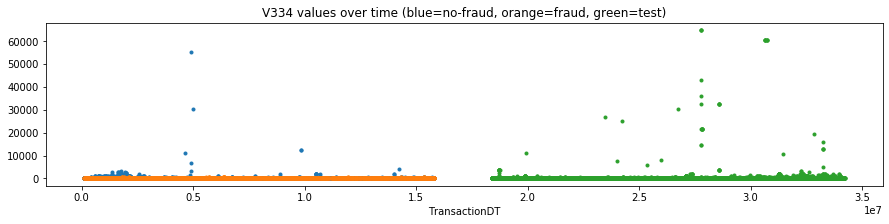

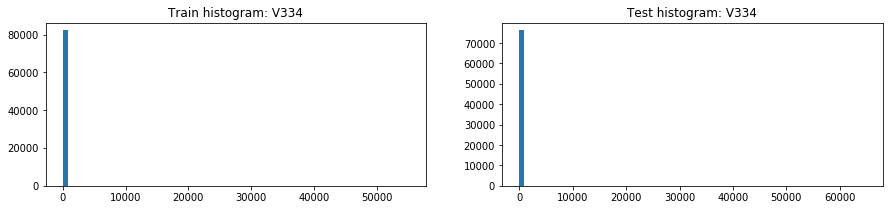

V334          Train   Train fraud  Train Not fraud  \
0           count   82351.000000   3686.000000     78665.000000   
1            mean       9.807015      9.299240         9.830808   
2             std     243.861391     51.502023       249.260209   
3             min       0.000000      0.000000         0.000000   
4             25%       0.000000      0.000000         0.000000   
5             50%       0.000000      0.000000         0.000000   
6             75%       0.000000      0.000000         0.000000   
7             max   55125.000000    635.000000     55125.000000   
8   unique values     144.000000     49.000000       131.000000   
9            NaNs  508189.000000  16977.000000    491212.000000   
10     NaNs share       0.860500      0.821600         0.862000   

             Test   Test public   Test private  
0    76431.000000   8971.000000   67460.000000  
1       24.708030     11.464608      26.469174  
2      842.913287    172.895557     894.978986  
3        0.000000      0.000000       0.000000  
4        0.000000      0.000000       0.000000  
5        0.000000      0.000000       0.000000  
6        0.000000      0.000000       0.000000  
7    64800.000000  11000.000000   64800.000000  
8      164.000000     46.000000     161.000000  
9   430260.000000  92368.000000  337893.000000  
10       0.849200      0.911500       0.833600

V334  Count in train (desc)  Mean target  Sum target  Count in test
0 -999.0                 508189     0.033407       16977       430260.0
1    0.0                  78588     0.044447        3493        73546.0
2  100.0                    590     0.038983          23          315.0
3   50.0                    385     0.023377           9          287.0
4   25.0                    228     0.057018          13          235.0
5  265.0                    193     0.000000           0            NaN
6  150.0                    180     0.155556          28          136.0
7   20.0                    178     0.011236           2          165.0
8  106.0                    169     0.000000           0            NaN
9  181.0                    146     0.000000           0            NaN

V334  Count in train  Mean target  Sum target (desc)  Count in test
0 -999.0          508189     0.033407              16977         430260
1    0.0           78588     0.044447               3493          73546
2  150.0             180     0.155556                 28            136
3  100.0             590     0.038983                 23            315
4  200.0             115     0.130435                 15            178
5   25.0             228     0.057018                 13            235
6  300.0              83     0.132530                 11             80
7   15.0             118     0.093220                 11             99
8   50.0             385     0.023377                  9            287
9  450.0              18     0.333333                  6             10

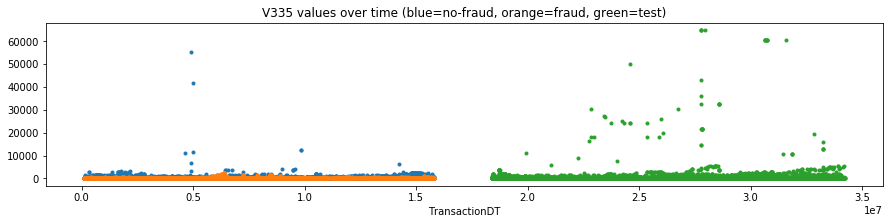

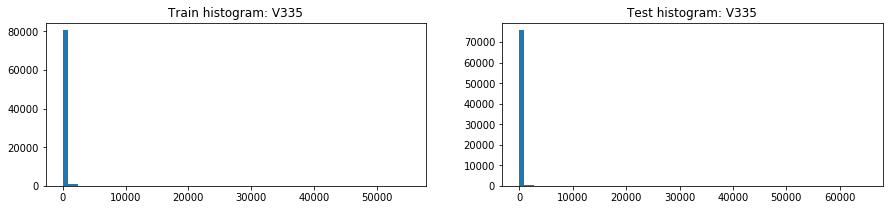

V335         Train   Train fraud  Train Not fraud           Test  \
0           count   82351.00000   3686.000000     78665.000000   76431.000000   
1            mean      59.16455     49.394466        59.622346      58.339468   
2             std     387.62948    201.848261       394.187771     990.361078   
3             min       0.00000      0.000000         0.000000       0.000000   
4             25%       0.00000      0.000000         0.000000       0.000000   
5             50%       0.00000      0.000000         0.000000       0.000000   
6             75%       0.00000      0.000000         0.000000       0.000000   
7             max   55125.00000   2430.000000     55125.000000   64800.000000   
8   unique values     673.00000    120.000000       655.000000     781.000000   
9            NaNs  508189.00000  16977.000000    491212.000000  430260.000000   
10     NaNs share       0.86050      0.821600         0.862000       0.849200   

     Test public  Test private  
0    8971.000000   67460.00000  
1      49.826376      59.47156  
2     248.558722    1050.24867  
3       0.000000       0.00000  
4       0.000000       0.00000  
5       0.000000       0.00000  
6       0.000000       0.00000  
7   11000.000000   64800.00000  
8     260.000000     704.00000  
9   92368.000000  337893.00000  
10      0.911500       0.83360

V335  Count in train (desc)  Mean target  Sum target  Count in test
0  -999.0                 508189     0.033407       16977       430260.0
1     0.0                  72668     0.043307        3147        68210.0
2  2301.0                    925     0.000000           0            1.0
3   100.0                    835     0.033533          28          735.0
4    50.0                    809     0.033375          27          645.0
5   150.0                    426     0.086854          37          357.0
6    25.0                    398     0.040201          16          341.0
7  1259.0                    326     0.000000           0            NaN
8   200.0                    315     0.085714          27          407.0
9    75.0                    254     0.043307          11          234.0

V335  Count in train  Mean target  Sum target (desc)  Count in test
0 -999.0          508189     0.033407              16977         430260
1    0.0           72668     0.043307               3147          68210
2  300.0             193     0.212435                 41            196
3  150.0             426     0.086854                 37            357
4  100.0             835     0.033533                 28            735
5  200.0             315     0.085714                 27            407
6   50.0             809     0.033375                 27            645
7  450.0              47     0.404255                 19             36
8   25.0             398     0.040201                 16            341
9   40.0             190     0.073684                 14            176

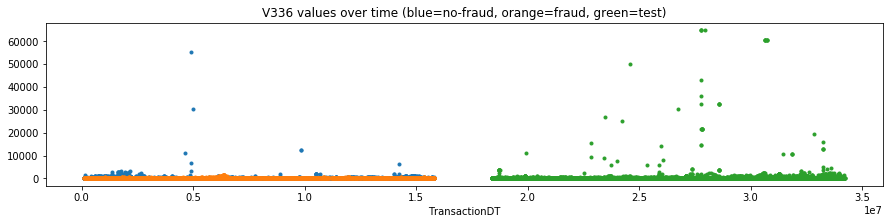

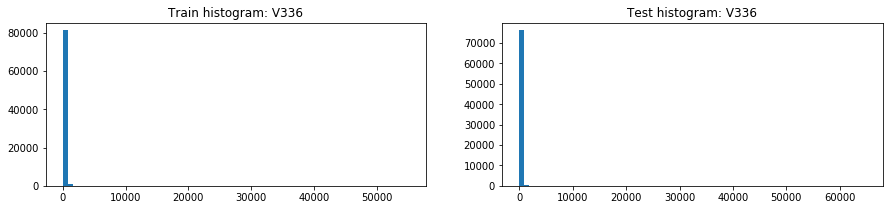

V336          Train   Train fraud  Train Not fraud  \
0           count   82351.000000   3686.000000     78665.000000   
1            mean      28.530903     25.483993        28.673672   
2             std     274.576920    117.938993       279.773375   
3             min       0.000000      0.000000         0.000000   
4             25%       0.000000      0.000000         0.000000   
5             50%       0.000000      0.000000         0.000000   
6             75%       0.000000      0.000000         0.000000   
7             max   55125.000000   1605.000000     55125.000000   
8   unique values     357.000000     81.000000       333.000000   
9            NaNs  508189.000000  16977.000000    491212.000000   
10     NaNs share       0.860500      0.821600         0.862000   

             Test   Test public   Test private  
0    76431.000000   8971.000000   67460.000000  
1       35.485643     21.291160      37.373261  
2      904.093921    179.121153     960.098348  
3        0.000000      0.000000       0.000000  
4        0.000000      0.000000       0.000000  
5        0.000000      0.000000       0.000000  
6        0.000000      0.000000       0.000000  
7    64800.000000  11000.000000   64800.000000  
8      370.000000    118.000000     353.000000  
9   430260.000000  92368.000000  337893.000000  
10       0.849200      0.911500       0.833600

V336  Count in train (desc)  Mean target  Sum target  Count in test
0  -999.0                 508189     0.033407       16977       430260.0
1     0.0                  75098     0.043410        3260        70596.0
2    50.0                    645     0.046512          30          526.0
3  1052.0                    645     0.000000           0            NaN
4   100.0                    604     0.046358          28          550.0
5    25.0                    381     0.062992          24          335.0
6   619.0                    325     0.000000           0            NaN
7   150.0                    284     0.119718          34          261.0
8   942.0                    280     0.000000           0            NaN
9    30.0                    258     0.054264          14          197.0

V336  Count in train  Mean target  Sum target (desc)  Count in test
0 -999.0          508189     0.033407              16977         430260
1    0.0           75098     0.043410               3260          70596
2  300.0             156     0.243590                 38            148
3  150.0             284     0.119718                 34            261
4   50.0             645     0.046512                 30            526
5  100.0             604     0.046358                 28            550
6  200.0             221     0.113122                 25            283
7   25.0             381     0.062992                 24            335
8   45.0              65     0.261538                 17             56
9   30.0             258     0.054264                 14            197

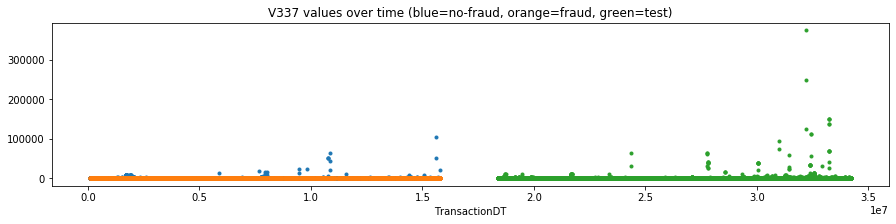

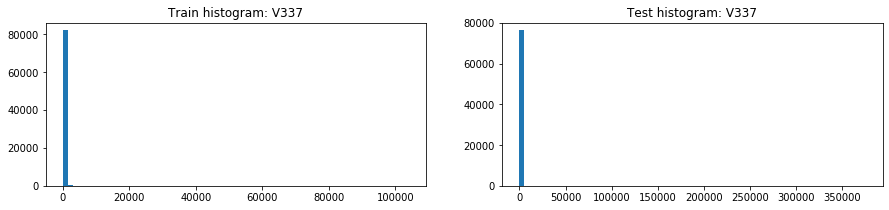

V337          Train   Train fraud  Train Not fraud  \
0           count   82351.000000   3686.000000     78665.000000   
1            mean      55.352422     37.742268        56.177580   
2             std     668.486833    142.505208       683.262438   
3             min       0.000000      0.000000         0.000000   
4             25%       0.000000      0.000000         0.000000   
5             50%       0.000000      0.000000         0.000000   
6             75%       0.000000      0.000000         0.000000   
7             max  104060.000000   2200.000000    104060.000000   
8   unique values     255.000000     63.000000       249.000000   
9            NaNs  508189.000000  16977.000000    491212.000000   
10     NaNs share       0.860500      0.821600         0.862000   

             Test   Test public   Test private  
0    76431.000000   8971.000000   67460.000000  
1       99.058760    107.998595      97.869918  
2     2436.074522    710.104693    2580.036475  
3        0.000000      0.000000       0.000000  
4        0.000000      0.000000       0.000000  
5        0.000000      0.000000       0.000000  
6        0.000000      0.000000       0.000000  
7   375000.000000  12000.000000  375000.000000  
8      329.000000    178.000000     242.000000  
9   430260.000000  92368.000000  337893.000000  
10       0.849200      0.911500       0.833600

V337  Count in train (desc)  Mean target  Sum target  Count in test
0  -999.0                 508189     0.033407       16977       430260.0
1     0.0                  73464     0.042592        3129        68348.0
2   100.0                   1243     0.045052          56         1108.0
3  1165.0                    870     0.000000           0            NaN
4   200.0                    861     0.058072          50          906.0
5   150.0                    661     0.089259          59          564.0
6    50.0                    619     0.063005          39          549.0
7   300.0                    582     0.121993          71          549.0
8   250.0                    311     0.048232          15          401.0
9   400.0                    280     0.050000          14          473.0

V337  Count in train  Mean target  Sum target (desc)  Count in test
0 -999.0          508189     0.033407              16977         430260
1    0.0           73464     0.042592               3129          68348
2  300.0             582     0.121993                 71            549
3  150.0             661     0.089259                 59            564
4  100.0            1243     0.045052                 56           1108
5  200.0             861     0.058072                 50            906
6   50.0             619     0.063005                 39            549
7  450.0             134     0.194030                 26             92
8   75.0             242     0.090909                 22            193
9  600.0             223     0.094170                 21            248

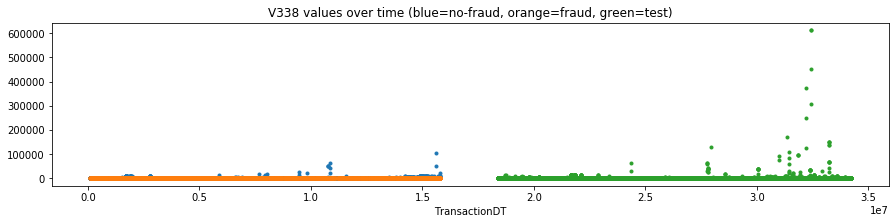

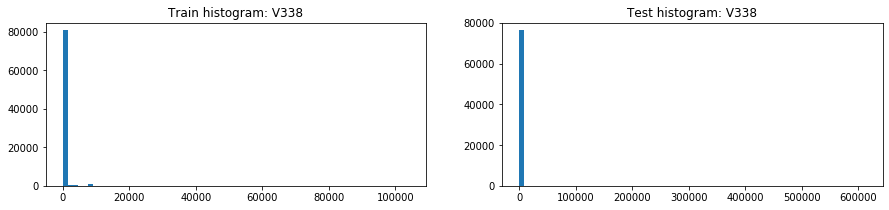

V338          Train   Train fraud  Train Not fraud  \
0           count   82351.000000   3686.000000     78665.000000   
1            mean     151.160542     53.242268       155.748691   
2             std    1095.034387    190.250383      1119.429005   
3             min       0.000000      0.000000         0.000000   
4             25%       0.000000      0.000000         0.000000   
5             50%       0.000000      0.000000         0.000000   
6             75%       0.000000      0.000000         0.000000   
7             max  104060.000000   2400.000000    104060.000000   
8   unique values     381.000000     79.000000       368.000000   
9            NaNs  508189.000000  16977.000000    491212.000000   
10     NaNs share       0.860500      0.821600         0.862000   

             Test   Test public   Test private  
0    76431.000000   8971.000000   67460.000000  
1      155.578153    173.271475     153.225250  
2     4544.303974   1037.100115    4822.225087  
3        0.000000      0.000000       0.000000  
4        0.000000      0.000000       0.000000  
5        0.000000      0.000000       0.000000  
6        0.000000      0.000000       0.000000  
7   612500.000000  14306.000000  612500.000000  
8      571.000000    270.000000     389.000000  
9   430260.000000  92368.000000  337893.000000  
10       0.849200      0.911500       0.833600

V338  Count in train (desc)  Mean target  Sum target  Count in test
0  -999.0                 508189     0.033407       16977       430260.0
1     0.0                  72114     0.041490        2992        66984.0
2   100.0                   1370     0.057664          79         1177.0
3   200.0                    929     0.055974          52          966.0
4  7709.0                    871     0.000000           0            NaN
5    50.0                    729     0.058985          43          589.0
6   150.0                    717     0.089261          64          592.0
7   300.0                    626     0.118211          74          591.0
8    25.0                    332     0.099398          33          241.0
9   250.0                    321     0.046729          15          420.0

V338  Count in train  Mean target  Sum target (desc)  Count in test
0 -999.0          508189     0.033407              16977         430260
1    0.0           72114     0.041490               2992          66984
2  100.0            1370     0.057664                 79           1177
3  300.0             626     0.118211                 74            591
4  150.0             717     0.089261                 64            592
5  200.0             929     0.055974                 52            966
6   50.0             729     0.058985                 43            589
7   25.0             332     0.099398                 33            241
8   75.0             265     0.124528                 33            218
9  450.0             152     0.210526                 32            102

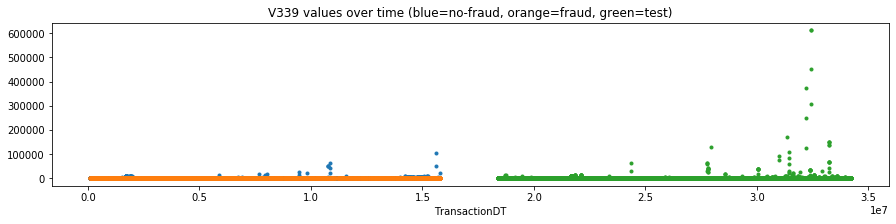

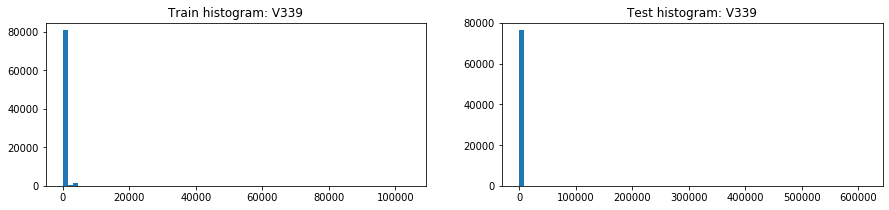

V339          Train   Train fraud  Train Not fraud  \
0           count   82351.000000   3686.000000     78665.000000   
1            mean     100.700882     45.496473       103.287590   
2             std     814.946722    175.966280       832.861349   
3             min       0.000000      0.000000         0.000000   
4             25%       0.000000      0.000000         0.000000   
5             50%       0.000000      0.000000         0.000000   
6             75%       0.000000      0.000000         0.000000   
7             max  104060.000000   2400.000000    104060.000000   
8   unique values     335.000000     73.000000       323.000000   
9            NaNs  508189.000000  16977.000000    491212.000000   
10     NaNs share       0.860500      0.821600         0.862000   

             Test   Test public   Test private  
0    76431.000000   8971.000000   67460.000000  
1      139.814706    121.494081     142.251029  
2     4493.728267    727.182798    4775.841711  
3        0.000000      0.000000       0.000000  
4        0.000000      0.000000       0.000000  
5        0.000000      0.000000       0.000000  
6        0.000000      0.000000       0.000000  
7   612500.000000  12000.000000  612500.000000  
8      448.000000    222.000000     334.000000  
9   430260.000000  92368.000000  337893.000000  
10       0.849200      0.911500       0.833600

V339  Count in train (desc)  Mean target  Sum target  Count in test
0  -999.0                 508189     0.033407       16977       430260.0
1     0.0                  72799     0.042185        3071        67667.0
2   100.0                   1319     0.045489          60         1143.0
3   200.0                    896     0.053571          48          935.0
4   150.0                    702     0.084046          59          582.0
5    50.0                    663     0.069382          46          572.0
6   300.0                    605     0.122314          74          575.0
7  3657.0                    416     0.000000           0            NaN
8   250.0                    322     0.052795          17          406.0
9    25.0                    294     0.074830          22          218.0

V339  Count in train  Mean target  Sum target (desc)  Count in test
0 -999.0          508189     0.033407              16977         430260
1    0.0           72799     0.042185               3071          67667
2  300.0             605     0.122314                 74            575
3  100.0            1319     0.045489                 60           1143
4  150.0             702     0.084046                 59            582
5  200.0             896     0.053571                 48            935
6   50.0             663     0.069382                 46            572
7  450.0             140     0.207143                 29             98
8   75.0             258     0.108527                 28            211
9  600.0             238     0.100840                 24            253

In [4]:
for col in list(tr.columns.values[300:]):
    proc(col)